In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lombscargle
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import acf
from arch import arch_model
from statsmodels.tsa.seasonal import STL
from scipy.stats import boxcox
from scipy.stats import boxcox_normmax
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

colours = {
    'cucumbers': '#4daf4a', # Green
    'guitars': '#f781bf',      # Pink
    'slingshots': '#984ea3',  # Purple
    'stocks': '#e41a1c',  # Red
    'sugar': '#ff7f00',      # Orange
    'water': '#377eb8',    # Blue
    'tranquillity': '#a65628' # Brown
}

# === Load and Clean Data ===
df = pd.read_csv("spiff_data.csv")
df = df.dropna(how='all', axis=1).dropna(how='all', axis=0)
df.replace(1000, np.nan, inplace=True)
df=df.drop(columns='Unnamed: 0')
df.rename(columns={'gurkor':'cucumbers'}, inplace=True)
# Save the cleaned dataframe to a new CSV file
df.to_csv('spiff_data_cleaned.csv', index=False)

# === Compute Log Returns ===
log_returns = np.log(df / df.shift(1))

In [395]:
df.head()

day  cucumbers   guitars  slingshots     stocks     sugar     water  \
0  1.0   6.154653  2.794285    2.136536  10.653684  3.324896  3.896149   
1  2.0   6.189623  2.843068    2.113582  10.674465  3.355736  3.899915   
2  3.0   6.168641  2.839644    2.116336  10.822372  3.336461  3.897404   
3  4.0   6.156401  2.823384    2.096137  10.848804  3.288274  3.901170   
4  5.0   6.124929  2.832798    2.099810  10.860731  3.303694  3.905355   

   tranquillity  
0      7.755880  
1      7.781310  
2      7.886205  
3      7.848061  
4      7.883026

In [396]:
summary_stats = df.describe()
summary_stats

day    cucumbers      guitars   slingshots       stocks  \
count  5455.000000  5201.000000  5201.000000  5201.000000  5201.000000   
mean   2728.816865     8.934701     5.758999     3.562496     6.354767   
std    1575.126349     2.268289     1.756993     0.973406     2.139400   
min       1.000000     5.942896     2.629048     2.001362     4.012346   
25%    1365.500000     6.947150     4.252728     2.804869     4.916920   
50%    2729.000000     8.905505     5.907840     3.383130     5.520531   
75%    4092.500000    10.183919     7.055568     4.291411     6.946382   
max    5456.000000    14.132395    10.719387     6.468982    13.613052   

             sugar        water  tranquillity  
count  5201.000000  5201.000000   5201.000000  
mean      2.663530     5.794586     11.552924  
std       0.727010     1.275024      3.067634  
min       1.370262     3.739412      6.614749  
25%       1.999030     4.996563      9.186268  
50%       2.605522     5.774852     10.584870  
75%       3.279982     6.488217     13.380483  
max       4.125193     8.949187     21.137953

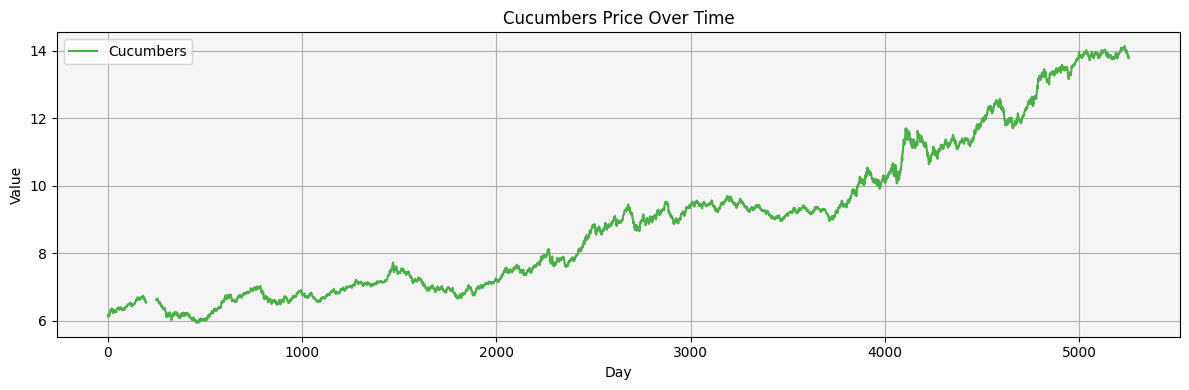

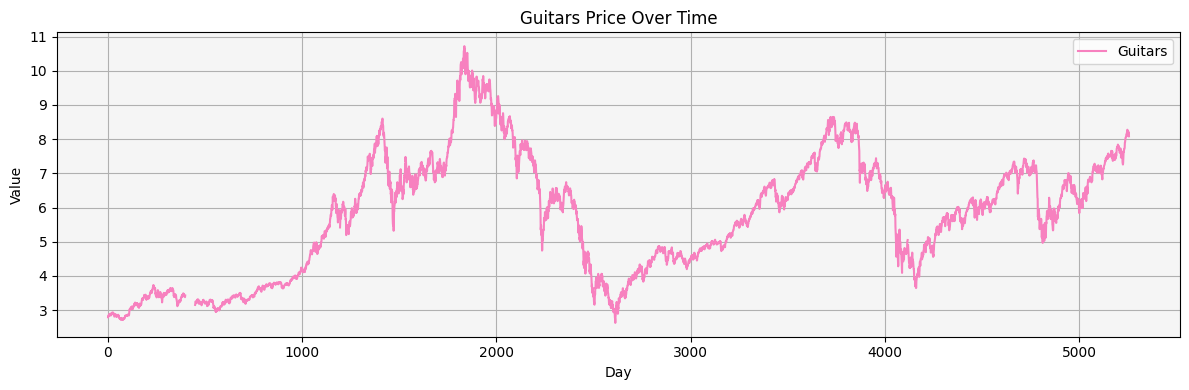

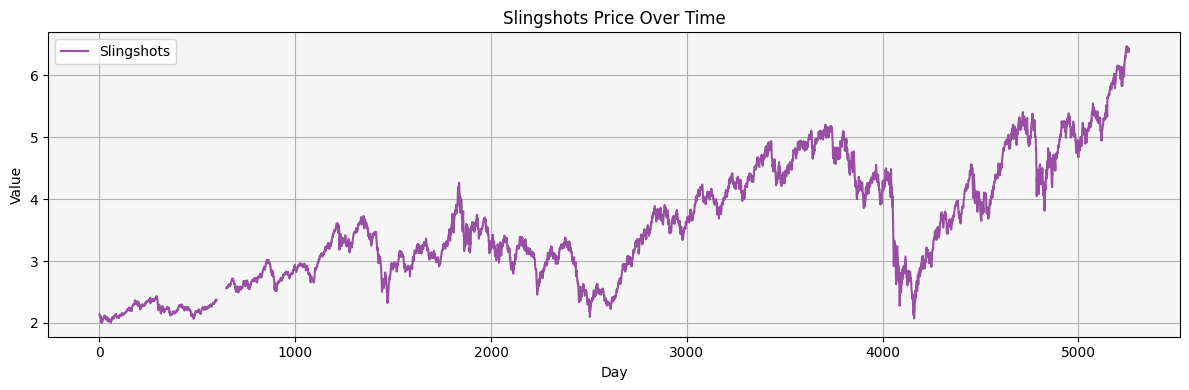

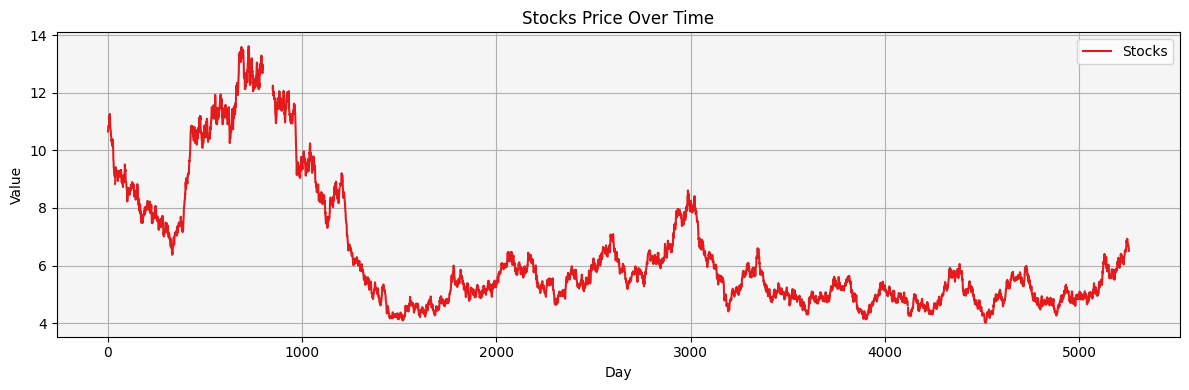

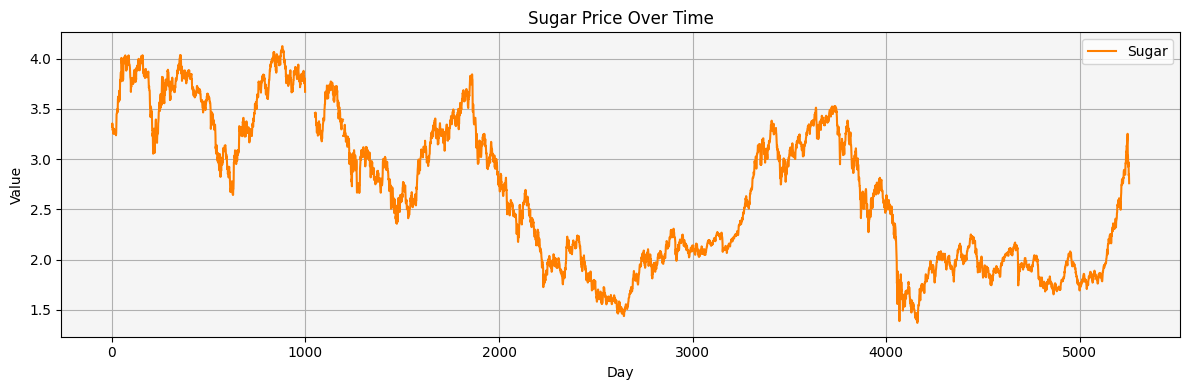

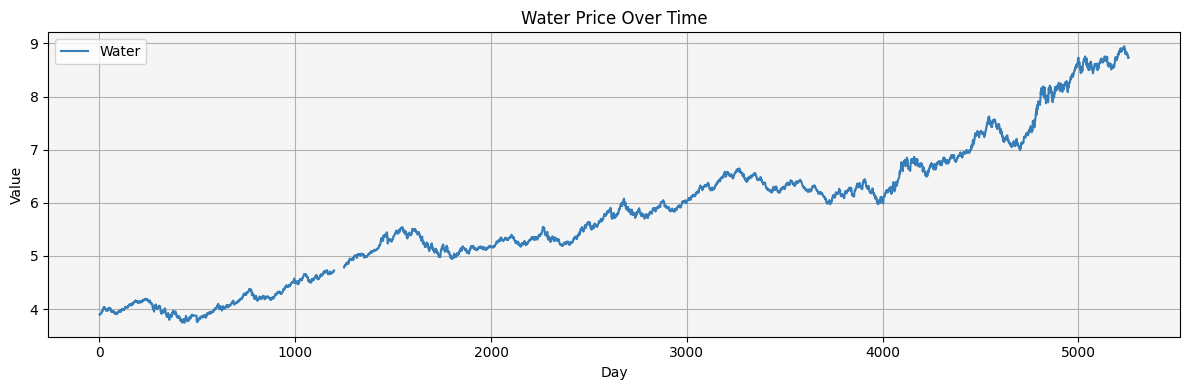

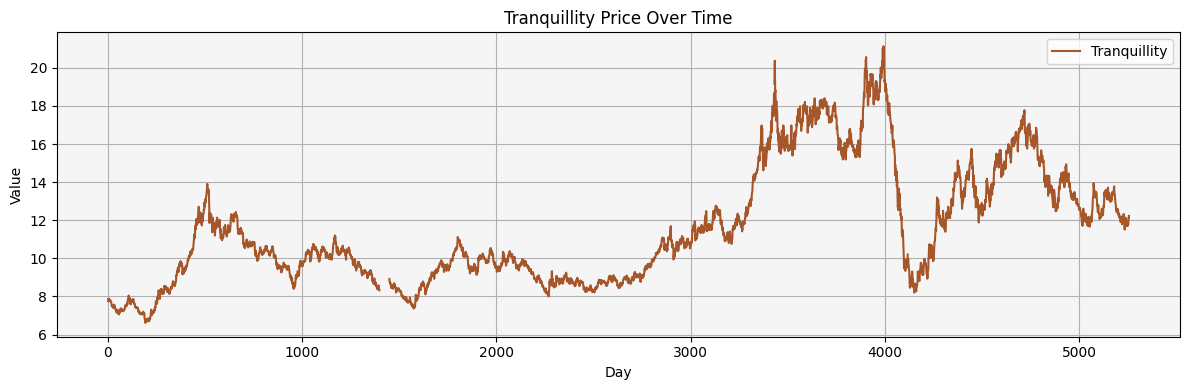

In [397]:
# Create a separate plot for each column
for column, color in colours.items():
    plt.figure(figsize=(12, 4))
    plt.plot(df['day'], df[column], color=color, label=column.capitalize())
    plt.title(f'{column.capitalize()} Price Over Time')
    plt.xlabel('Day')
    plt.ylabel('Value')
    plt.grid(True)
    plt.gca().set_facecolor("whitesmoke")
    plt.legend()
    plt.tight_layout()
    plt.show()

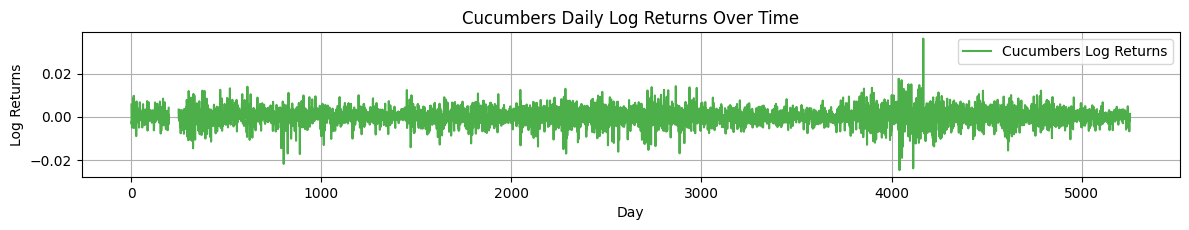

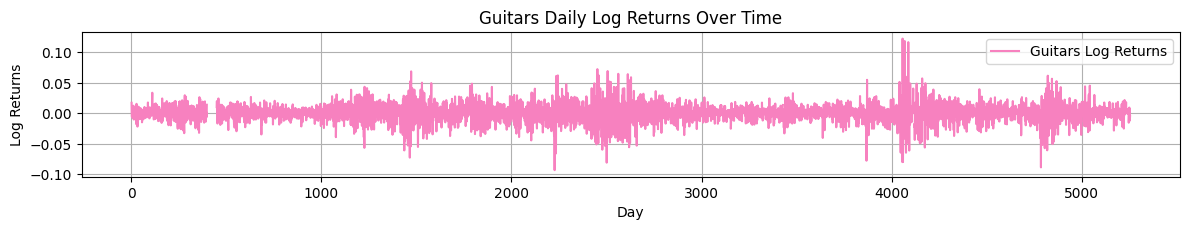

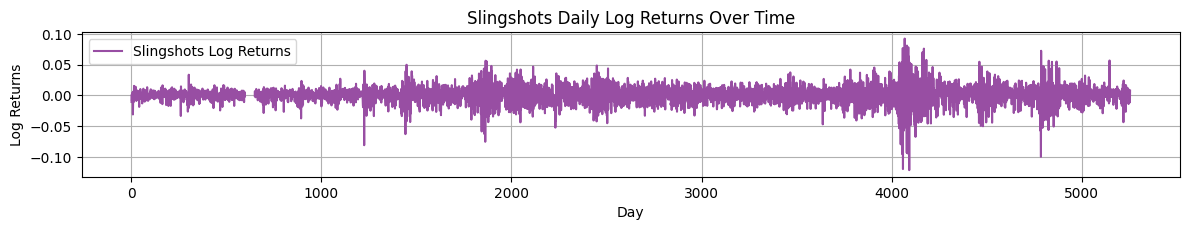

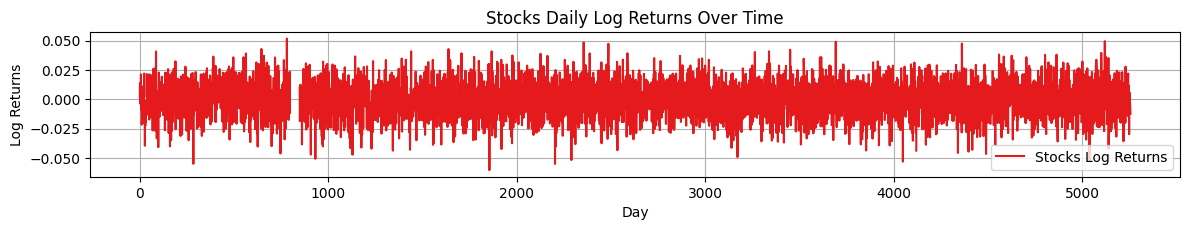

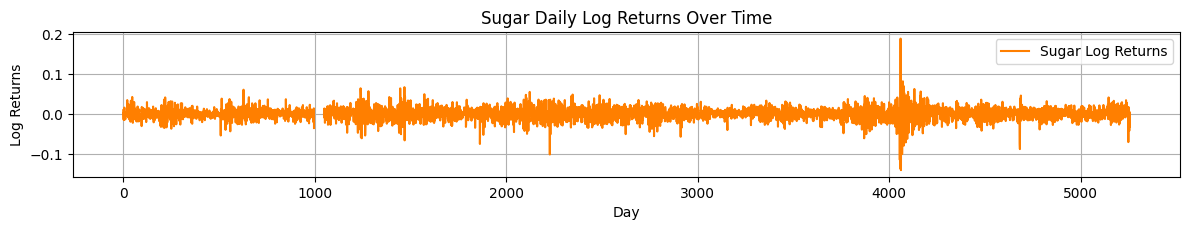

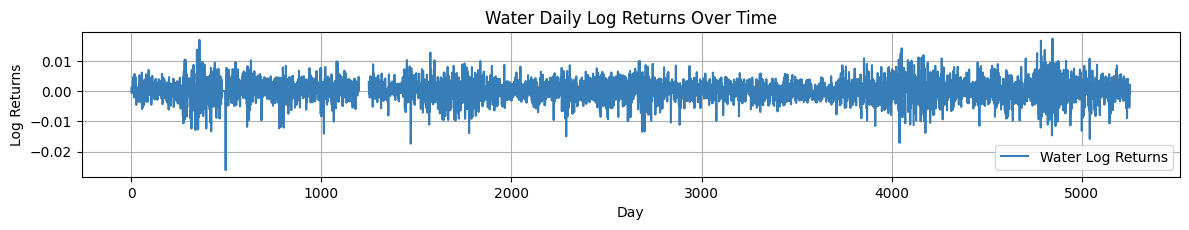

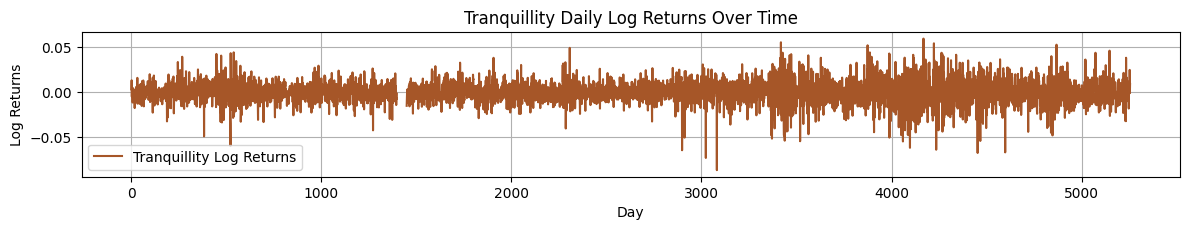

In [398]:
# Loop through each column for plotting
for column, color in colours.items():
    plt.figure(figsize=(12, 4))
    # Plot log returns
    plt.subplot(2, 1, 2)
    plt.plot(log_returns[column], color=color, label=f'{column.capitalize()} Log Returns')
    plt.title(f'{column.capitalize()} Daily Log Returns Over Time')
    plt.xlabel('Day')
    plt.ylabel('Log Returns')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

Correlation Matrix Raw data

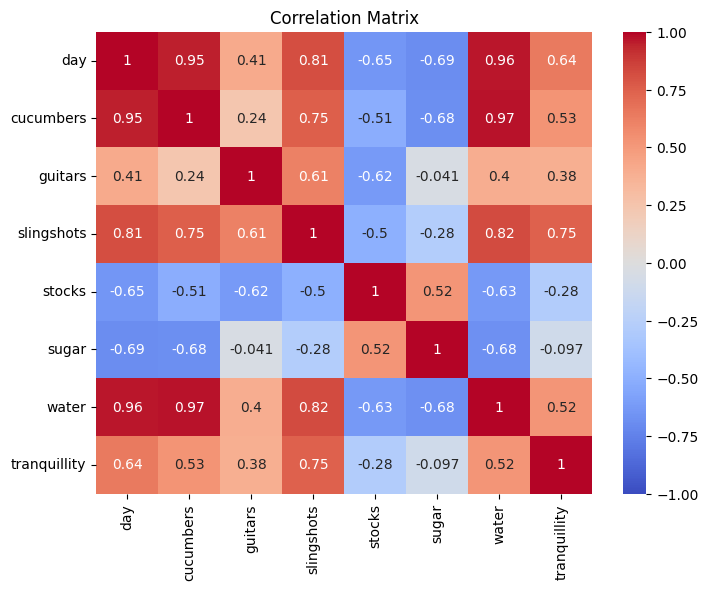

In [399]:
corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

Correlation Matrix log-returns data

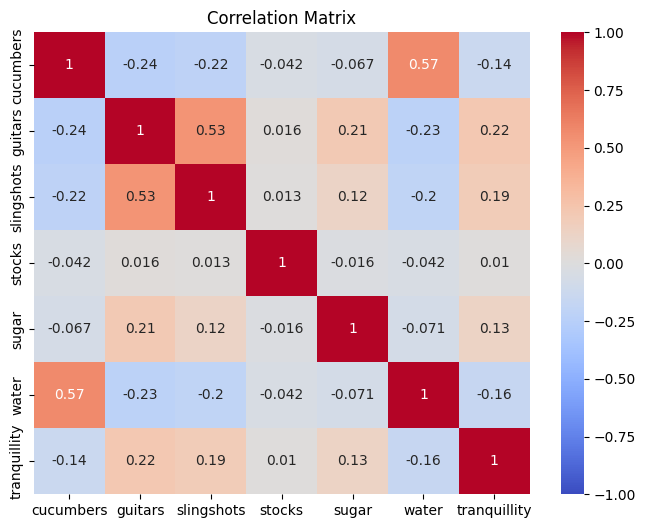

In [400]:
df=df.dropna()
plt.figure(figsize=(8,6))
sns.heatmap(log_returns.drop(columns='day').corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

ACF for log-returnes

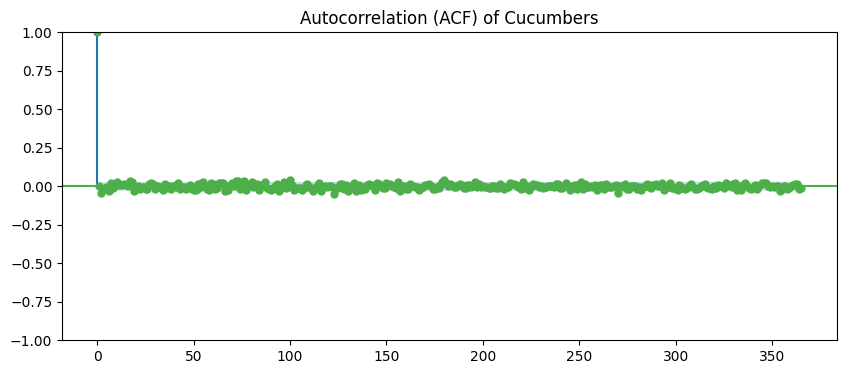

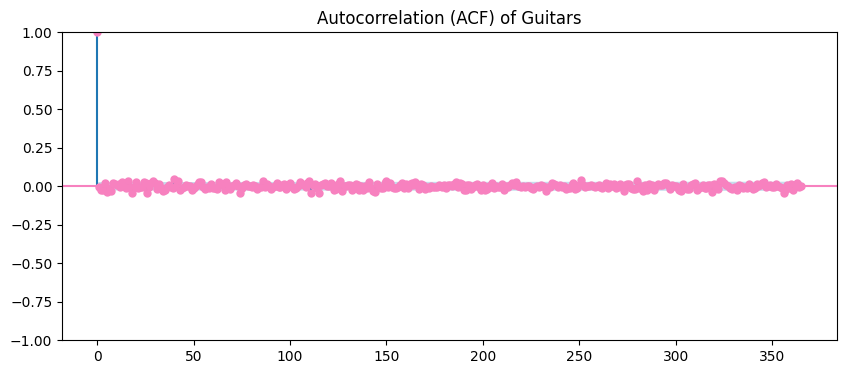

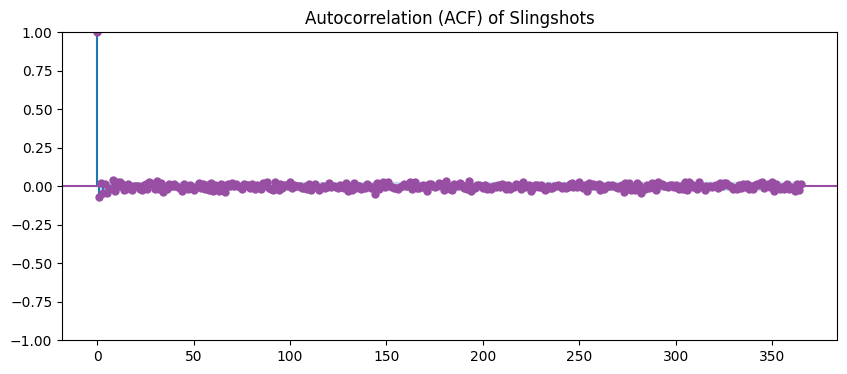

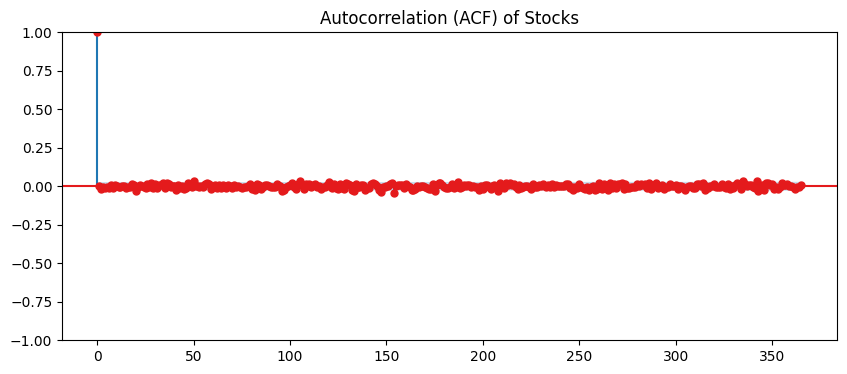

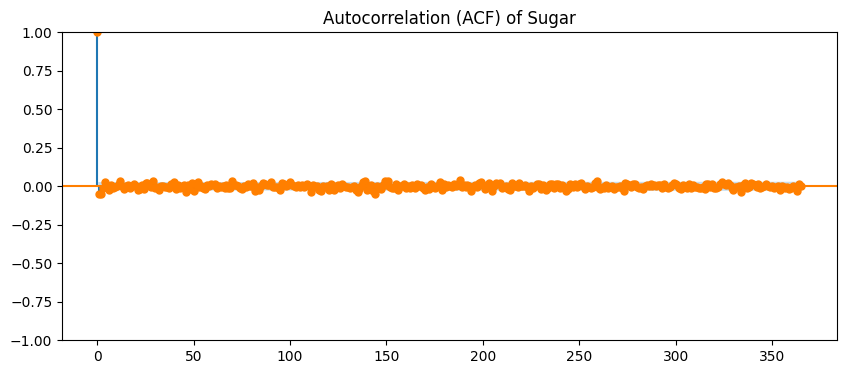

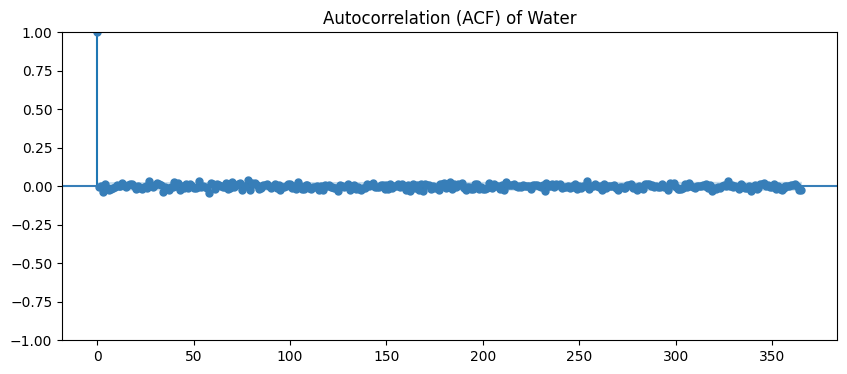

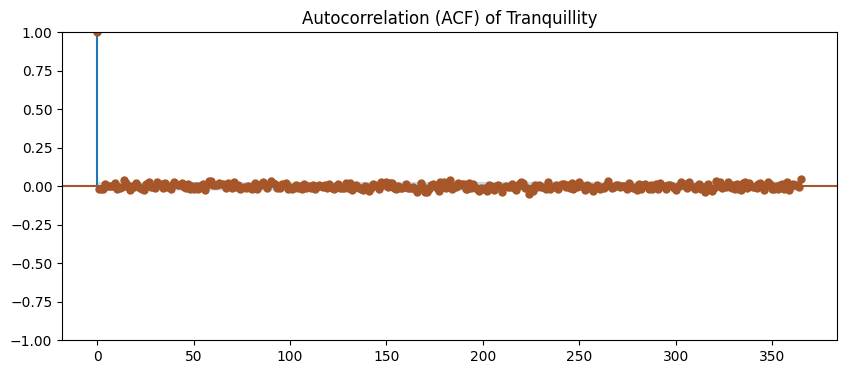

In [401]:
from statsmodels.graphics.tsaplots import plot_acf

for column, color in colours.items():
    series = log_returns[column].dropna()
    fig, ax = plt.subplots(figsize=(10, 4))
    plot_acf(series, ax=ax, lags=365, alpha=0.05, color=color)
    ax.set_title(f'Autocorrelation (ACF) of {column.capitalize()}')
    plt.show()


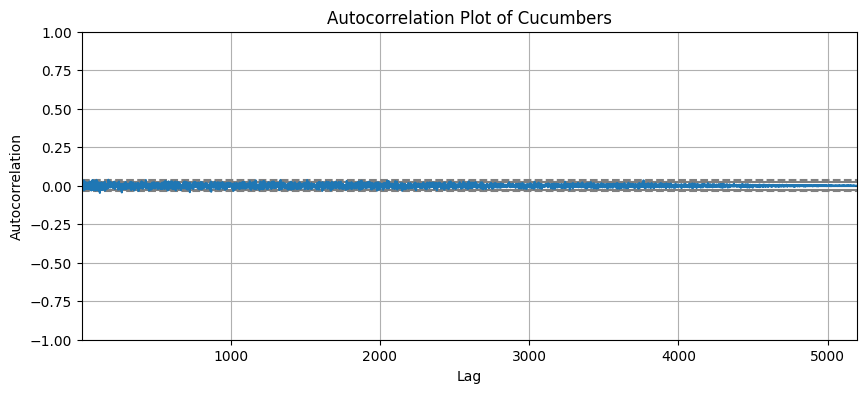

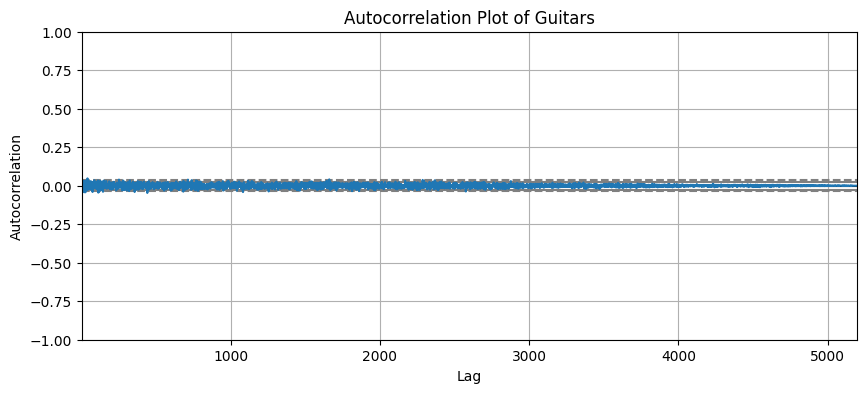

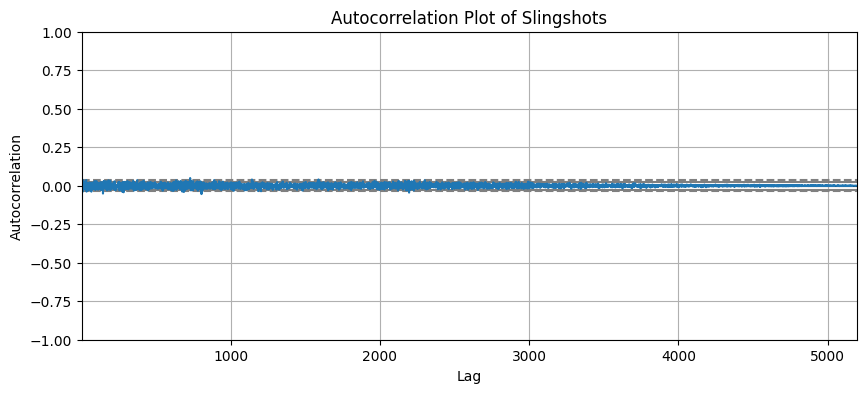

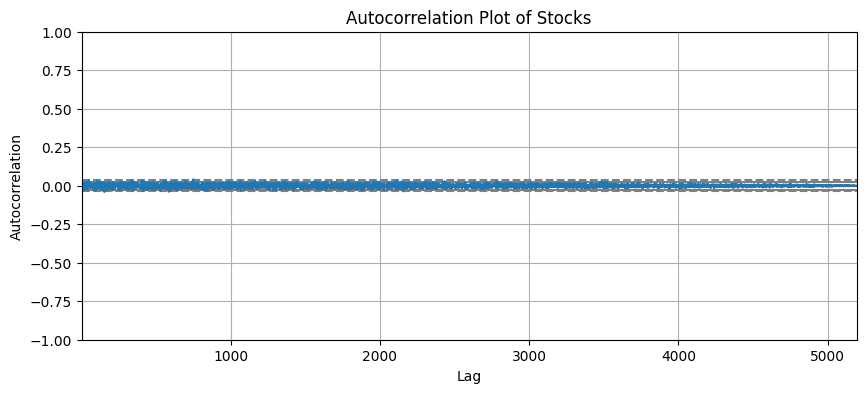

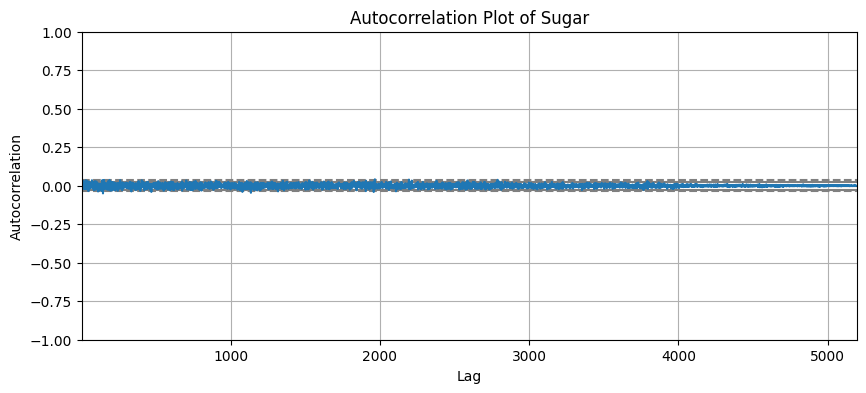

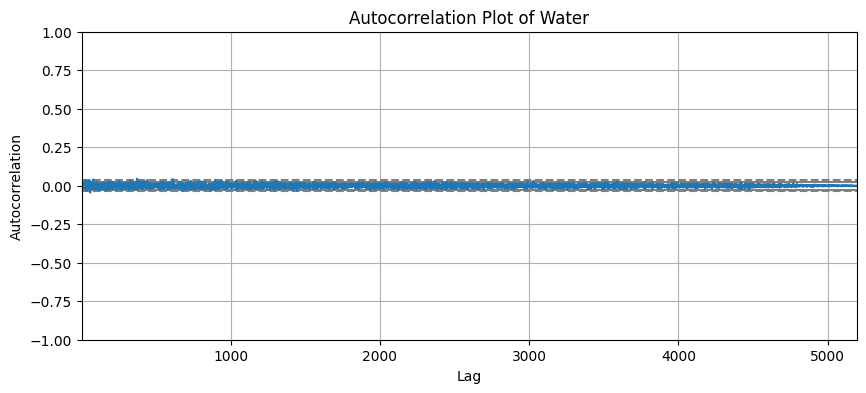

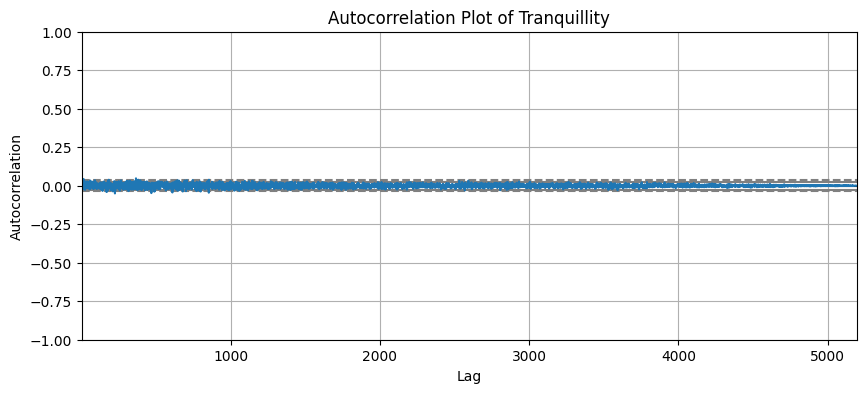

In [402]:
from pandas.plotting import autocorrelation_plot

for column, color in colours.items():
    series = log_returns[column].dropna()
    plt.figure(figsize=(10,4))
    autocorrelation_plot(series)
    plt.title(f'Autocorrelation Plot of {column.capitalize()}')
    plt.show()


Trying to fins a seasonal lag 

In [403]:
# Function to find the best seasonal lag based on the highest significant autocorrelation peak
def best_seasonal_lag(series, max_lag=365):
    acf_values, confint = acf(series, nlags=max_lag, alpha=0.05)
    # Ignore lag 0 and find the lag with the highest autocorrelation above confidence interval
    significant_lags = [(lag, val) for lag, val in enumerate(acf_values[1:], 1) if val > confint[lag][1]]
    if significant_lags:
        best_lag = max(significant_lags, key=lambda x: x[1])[0]
        return best_lag
    else:
        return None

# Find best seasonal lag for each time series
best_lags = {}
max_lag_to_check = 365*7
for col in df.columns:
    lag = best_seasonal_lag(log_returns[f'{col}'], max_lag=max_lag_to_check)
    best_lags[col] = lag

best_lags

{'day': None,
 'cucumbers': None,
 'guitars': None,
 'slingshots': None,
 'stocks': None,
 'sugar': None,
 'water': None,
 'tranquillity': None}

Stl helper fuctions

In [404]:
def calculate_seasonality_strength(result):
    """Strength = variance of seasonal / (variance of seasonal + variance of residual)"""
    seasonal_var = np.var(result.seasonal)
    residual_var = np.var(result.resid)
    return seasonal_var / (seasonal_var + residual_var)

def best_fixed_period(series, periods_to_test):
    """Find best period among a fixed set."""
    best_strength = -np.inf
    best_period = None
    
    for test_period in periods_to_test:
        if test_period >= len(series.dropna()) // 2:
            continue  # Skip if period is too long for data

        try:
            stl = STL(series, period=test_period, robust=True)
            result = stl.fit()
            strength = calculate_seasonality_strength(result)
            print(f"Tested Period {test_period} days: Strength = {strength:.3f}")
            
            if strength > best_strength:
                best_strength = strength
                best_period = test_period
        except Exception as e:
            print(f"Error testing period {test_period}: {e}")
            continue

    return best_period, best_strength

Box-Cox transformation with Guerrero method

In [405]:
# --- Guerrero lambda estimation ---
def guerrero_lambda(series, period=None):
    """Approximate Guerrero method for Box-Cox lambda selection."""
    series = series.dropna()
    if (series <= 0).any():
        raise ValueError("Guerrero requires all positive values")
    if period is None:
        period = max(10, len(series) // 10)  # heuristic fallback
    rolling_var = series.rolling(window=period, center=True, min_periods=1).var()
    mean_var_ratio = rolling_var.mean() / series.var()
    return max(-2, min(2, np.log(mean_var_ratio)))

# Containers
mle_transformed = {}
guerrero_transformed = {}
lambda_results = []

# Process each column
for col in df.columns:
    if col == 'day':
        continue
    series = df[col].dropna()

    if (series <= 0).any():
        print(f"Skipping {col} (contains non-positive values)")
        continue

    try:
        # Box-Cox MLE
        lambda_mle = boxcox_normmax(series, method='mle')
        transformed_mle = boxcox(series, lmbda=lambda_mle)

        # Guerrero lambda
        lambda_guerrero = guerrero_lambda(series)
        transformed_guerrero = boxcox(series, lmbda=lambda_guerrero)

        # Store
        mle_transformed[col] = transformed_mle
        guerrero_transformed[col] = transformed_guerrero
        lambda_results.append({
            "Instrument": col,
            "BoxCox_MLE_Lambda": round(lambda_mle, 6),
            "BoxCox_Guerrero_Lambda": round(lambda_guerrero, 6)
        })

        print(f"{col}: MLE λ = {lambda_mle:.4f}, Guerrero λ = {lambda_guerrero:.4f}")

    except Exception as e:
        print(f"Error processing {col}: {e}")

# Create result DataFrames
df_boxcox_mle = pd.DataFrame(mle_transformed)
df_boxcox_guerrero = pd.DataFrame(guerrero_transformed)
df_lambdas = pd.DataFrame(lambda_results)

cucumbers: MLE λ = -0.7630, Guerrero λ = -2.0000
guitars: MLE λ = 0.6651, Guerrero λ = -1.3906
slingshots: MLE λ = 0.1017, Guerrero λ = -1.7713
stocks: MLE λ = -2.2396, Guerrero λ = -1.4092
sugar: MLE λ = 0.0276, Guerrero λ = -1.5795
water: MLE λ = 0.1337, Guerrero λ = -2.0000
tranquillity: MLE λ = -0.8068, Guerrero λ = -1.3593


Seasonal strength on Diffrense detrending

Analyzing: cucumbers


<Figure size 800x400 with 0 Axes>

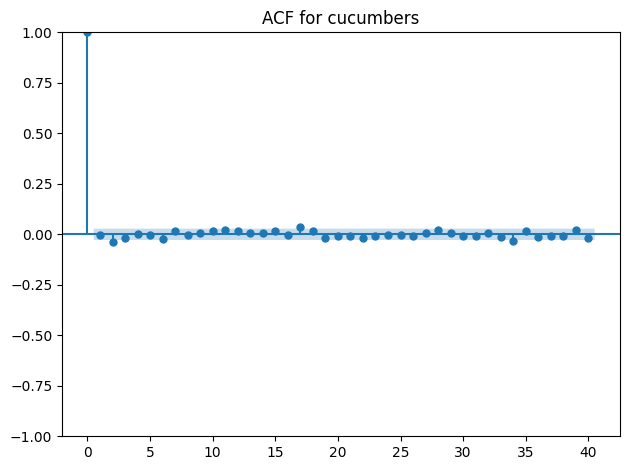

Box–Ljung Test for cucumbers (10 lags):
      lb_stat  lb_pvalue
10  14.295603    0.15993

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0225, FAP = 0.00000



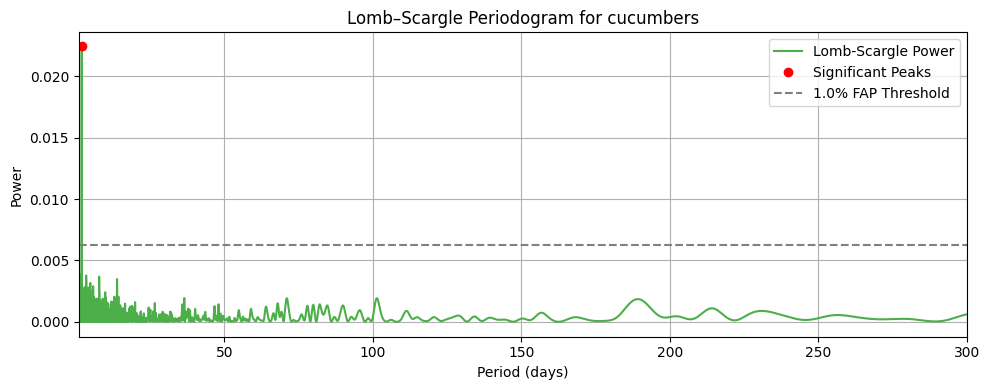

Analyzing: guitars


<Figure size 800x400 with 0 Axes>

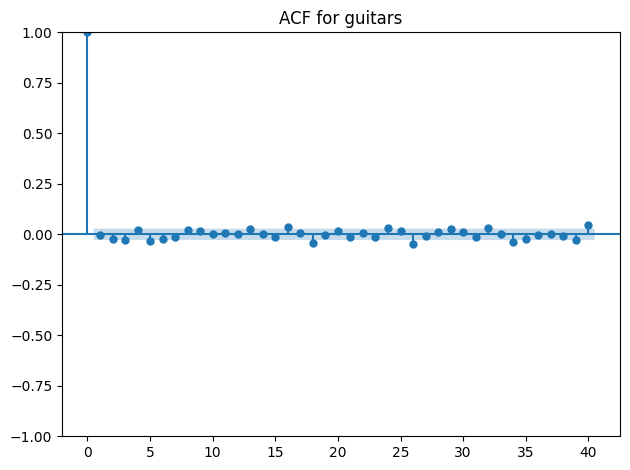

Box–Ljung Test for guitars (10 lags):
      lb_stat  lb_pvalue
10  21.975121   0.015232

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0115, FAP = 0.00000



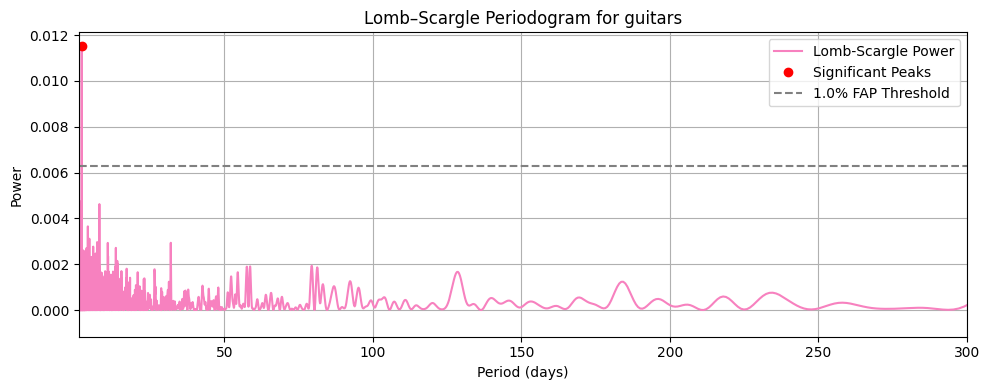

Analyzing: slingshots


<Figure size 800x400 with 0 Axes>

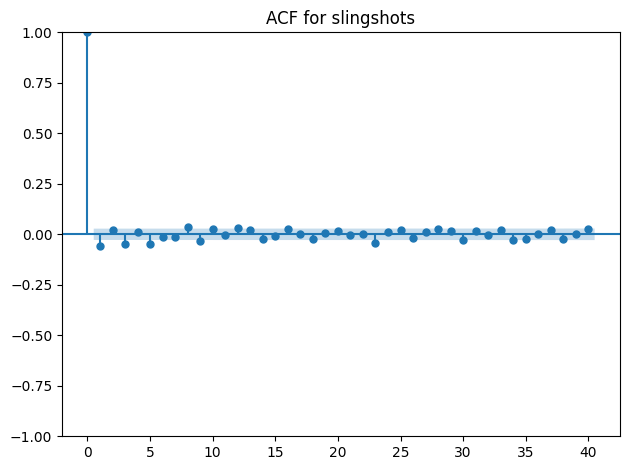

Box–Ljung Test for slingshots (10 lags):
      lb_stat     lb_pvalue
10  58.200615  7.924416e-09

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0382, FAP = 0.00000



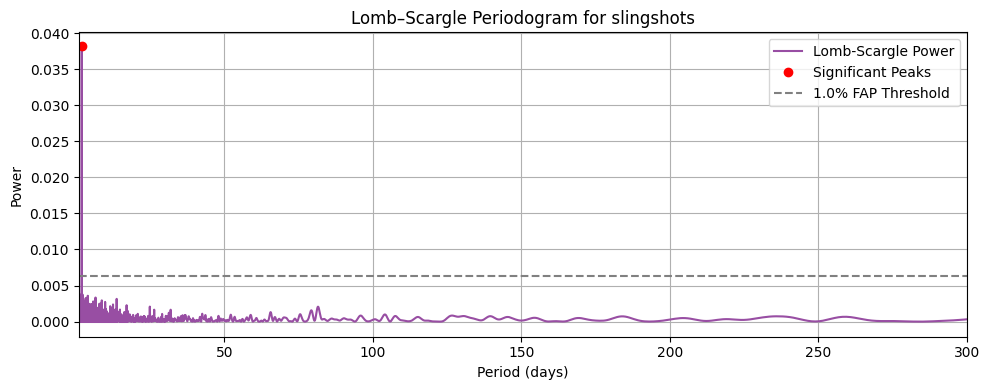

Analyzing: stocks


<Figure size 800x400 with 0 Axes>

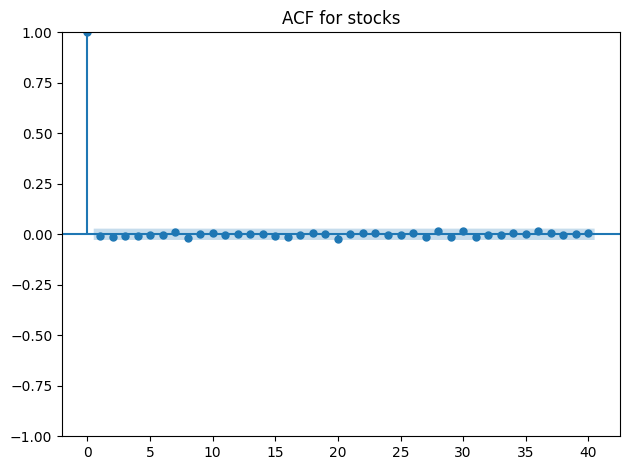

Box–Ljung Test for stocks (10 lags):
     lb_stat  lb_pvalue
10  4.900355   0.897734

Significant integer periods: []



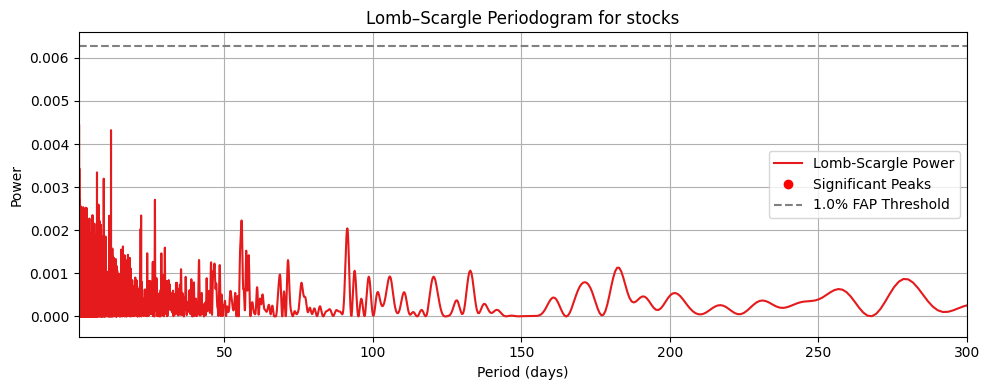

Analyzing: sugar


<Figure size 800x400 with 0 Axes>

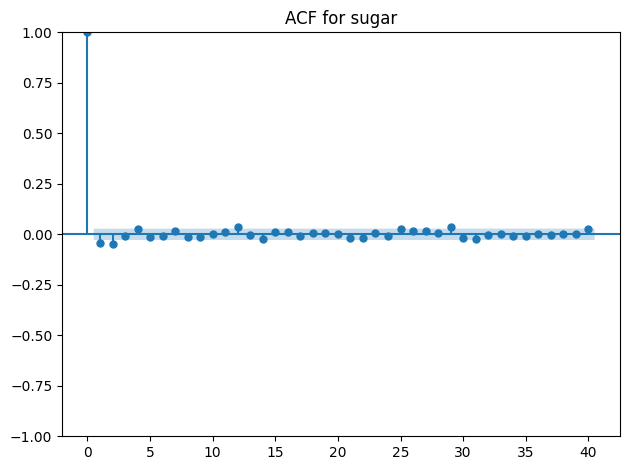

Box–Ljung Test for sugar (10 lags):
      lb_stat  lb_pvalue
10  29.007067   0.001243

Significant integer periods: []



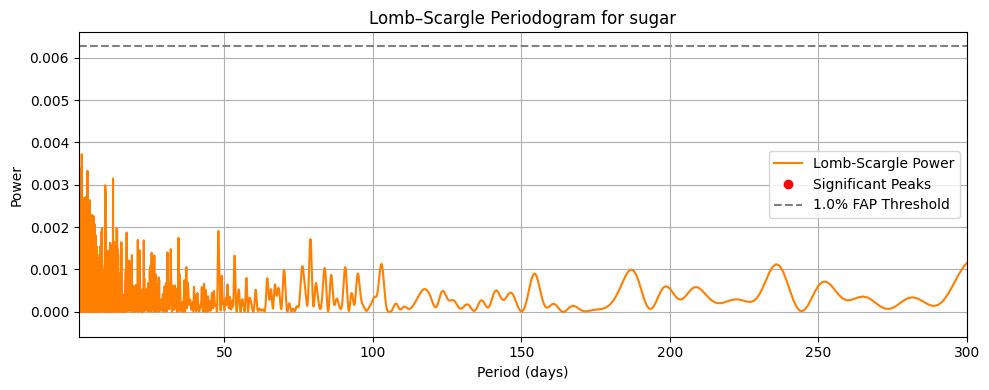

Analyzing: water


<Figure size 800x400 with 0 Axes>

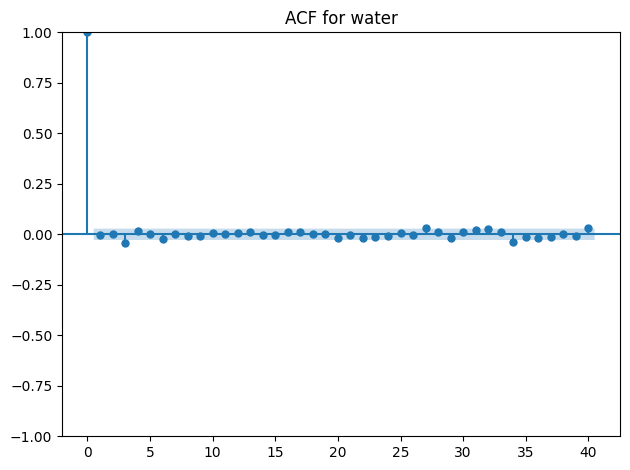

Box–Ljung Test for water (10 lags):
      lb_stat  lb_pvalue
10  13.713866   0.186448

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0492, FAP = 0.00000



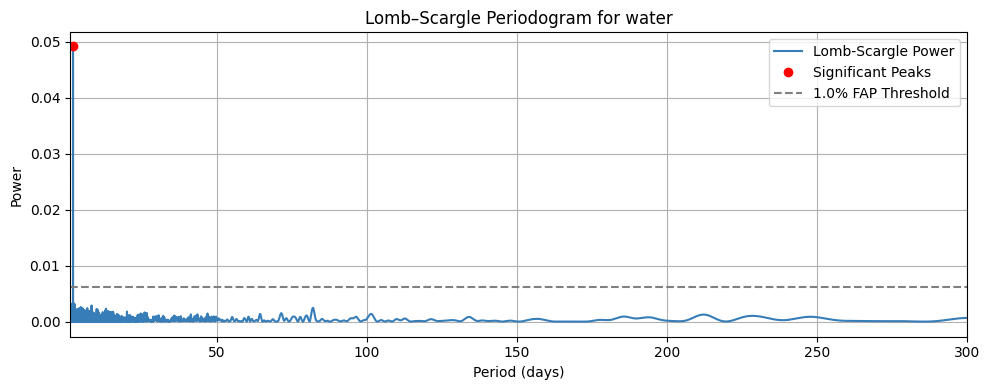

Analyzing: tranquillity


<Figure size 800x400 with 0 Axes>

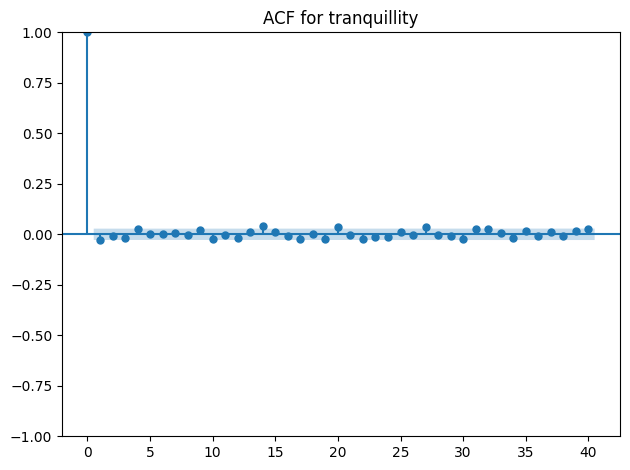

Box–Ljung Test for tranquillity (10 lags):
      lb_stat  lb_pvalue
10  14.409077   0.155137

Significant integer periods: []



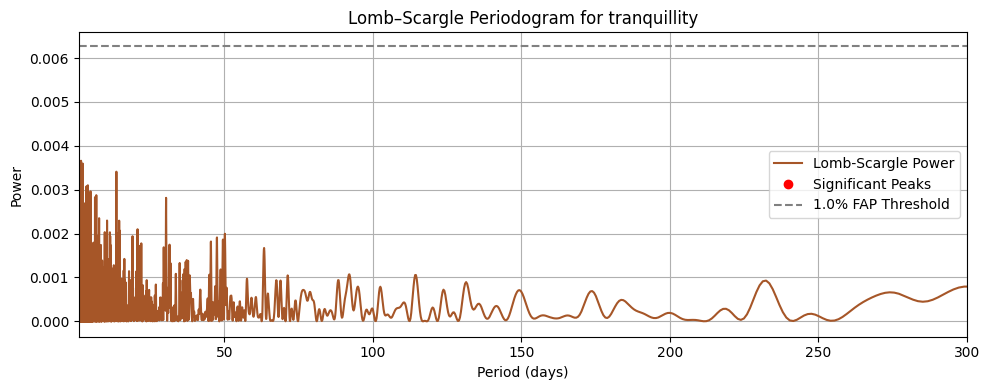

In [406]:
# Set significance threshold for peak detection
alpha = 0.01
periods_to_test = {}

# Loop over each instrument
for col in df.columns:
    if col == 'day':
        continue

    print(f"Analyzing: {col}")

    # Get price series
    price_series = df[col].dropna()
    color = colours.get(col, 'black')

    # Detrending
    series = np.log(price_series / price_series.shift(1)).dropna()

    # Plot the Autocorrelation Function (ACF)
    plt.figure(figsize=(8, 4))
    plot_acf(series, lags=40) #40?
    plt.title(f"ACF for {col}")
    plt.tight_layout()
    plt.show()
    
    # Perform the Box–Ljung test 
    # The test checks the null hypothesis that the series is independently distributed.
    lb_test = acorr_ljungbox(series, lags=[10], return_df=True) #10?
    print(f"Box–Ljung Test for {col} (10 lags):\n{lb_test}\n")
    
    
    # Prepare time and signal vectors
    t = np.arange(len(series))
    y = series.values - np.mean(series.values)

    # Lomb–Scargle Periodogram
    min_p, max_p = 1, 5000
    ls = LombScargle(t, y)
    frequency, power = ls.autopower(
        minimum_frequency=1/max_p,
        maximum_frequency=1/min_p,
        samples_per_peak=10
    )
    period = 1.0 / frequency

    # Peak Detection & Filtering 
    peak_indices, _ = find_peaks(power)
    peak_freqs = frequency[peak_indices]
    peak_periods = 1.0 / peak_freqs
    peak_powers = power[peak_indices]

    peak_faps = ls.false_alarm_probability(peak_powers)
    significant = peak_faps < alpha

    sig_periods = peak_periods[significant]
    sig_powers = peak_powers[significant]
    sig_faps = peak_faps[significant]

    # Round and deduplicate
    rounded_periods = np.round(sig_periods).astype(int)
    unique_rounded_periods = np.unique(rounded_periods[rounded_periods > 1])

    periods_to_test[col] = set(unique_rounded_periods)

    # Output Results
    print("Significant integer periods:", unique_rounded_periods)
    for p, powr, fap in zip(sig_periods, sig_powers, sig_faps):
        print(f"  Period = {p:.2f} days, Power = {powr:.4f}, FAP = {fap:.5f}")
    print()

    # Plot 
    fap_threshold = ls.false_alarm_level(alpha)
    plt.figure(figsize=(10, 4))
    plt.plot(period, power, label="Lomb-Scargle Power", color=color)
    plt.plot(sig_periods, sig_powers, 'ro', label='Significant Peaks')
    plt.axhline(fap_threshold, linestyle="--", color="gray", label=f"{alpha*100:.1f}% FAP Threshold")
    plt.xlim(1, 300)
    plt.xlabel("Period (days)")
    plt.ylabel("Power")
    plt.title(f"Lomb–Scargle Periodogram for {col}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Analyzing cucumbers...
Tested Period 2 days: Strength = 0.108
Best Period: 2 days (Strength: 0.108)

Analyzing guitars...
Tested Period 2 days: Strength = 0.116
Best Period: 2 days (Strength: 0.116)

Analyzing slingshots...
Tested Period 2 days: Strength = 0.129
Best Period: 2 days (Strength: 0.129)

Analyzing stocks...
No candidate periods found for stocks. Skipping.

Analyzing sugar...
No candidate periods found for sugar. Skipping.

Analyzing water...
Tested Period 2 days: Strength = 0.136
Best Period: 2 days (Strength: 0.136)

Analyzing tranquillity...
No candidate periods found for tranquillity. Skipping.


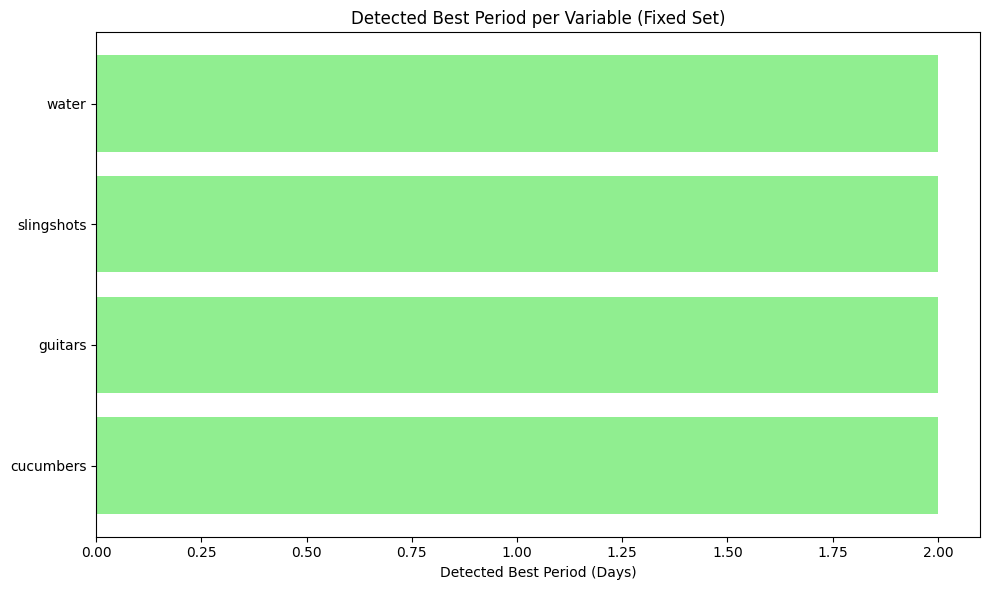

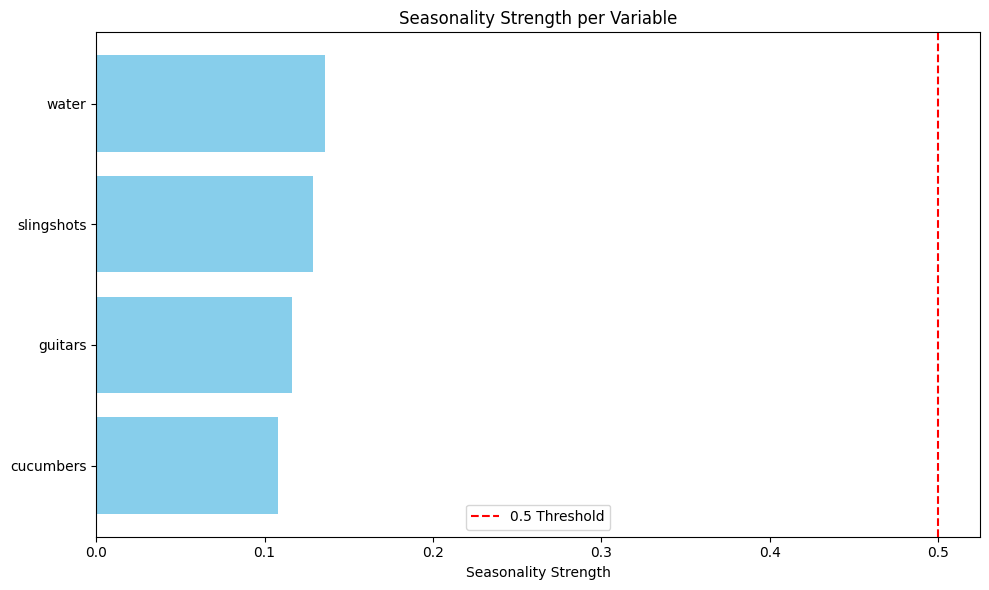

In [407]:
# Fixed periods to test
periods = periods_to_test[col]
best_periods= {}
seasonality_strengths = {}
# Analyze seasonality on transformed data
for col in df.columns:
    if col == 'day':
        continue
    print(f"\nAnalyzing {col}...")
    series = pd.Series(log_returns[col]).dropna()
    
    # Again get the periods for this column safely
    periods_for_col = list(periods_to_test.get(col, []))
    
    if not periods_for_col:
        print(f"No candidate periods found for {col}. Skipping.")
        continue
    
    best_period, best_strength = best_fixed_period(series, periods_for_col)
    
    if best_period is None:
        print(f"No good period found for {col}. Skipping.")
        continue
    
    best_periods[col] = best_period
    seasonality_strengths[col] = best_strength
    print(f"Best Period: {best_period} days (Strength: {best_strength:.3f})")

# --- Plot Results ---

plt.figure(figsize=(10, 6))
plt.barh(list(best_periods.keys()), list(best_periods.values()), color='lightgreen')
plt.xlabel("Detected Best Period (Days)")
plt.title("Detected Best Period per Variable (Fixed Set)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(list(seasonality_strengths.keys()), list(seasonality_strengths.values()), color='skyblue')
plt.xlabel("Seasonality Strength")
plt.title("Seasonality Strength per Variable")
plt.axvline(0.5, color='red', linestyle='--', label='0.5 Threshold')
plt.legend()
plt.tight_layout()
plt.show()


Seasonal strength of Guerrero Box-cox transformed and Diffrense detrending

Analyzing: cucumbers


<Figure size 800x400 with 0 Axes>

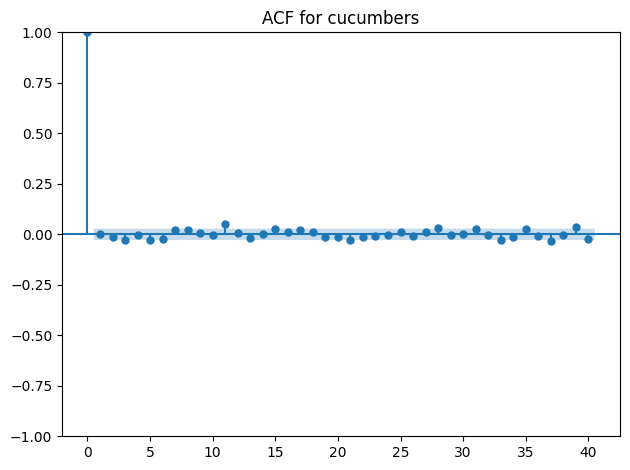

Box–Ljung Test for cucumbers (10 lags):
      lb_stat  lb_pvalue
10  17.735886   0.059586

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0305, FAP = 0.00000



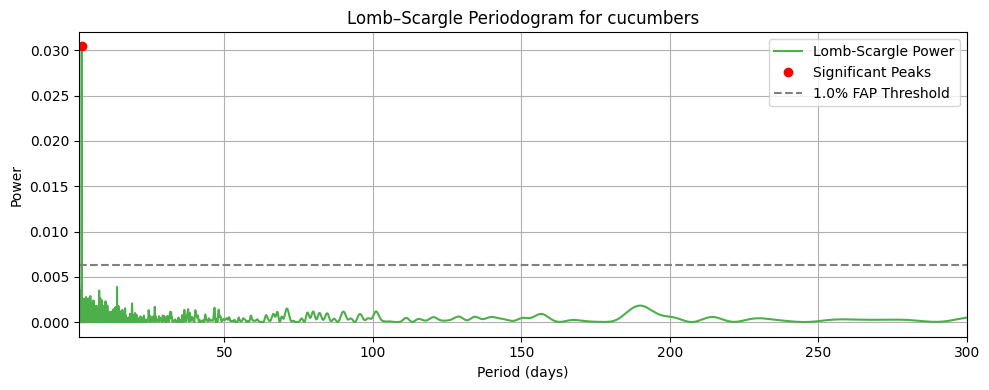

Analyzing: guitars


<Figure size 800x400 with 0 Axes>

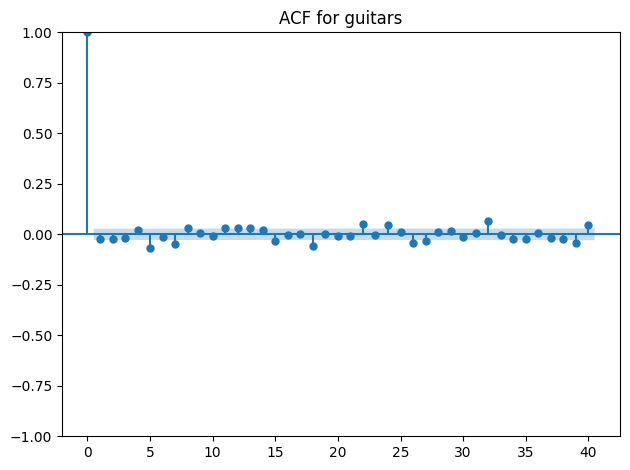

Box–Ljung Test for guitars (10 lags):
      lb_stat     lb_pvalue
10  50.030653  2.634661e-07

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0070, FAP = 0.00165



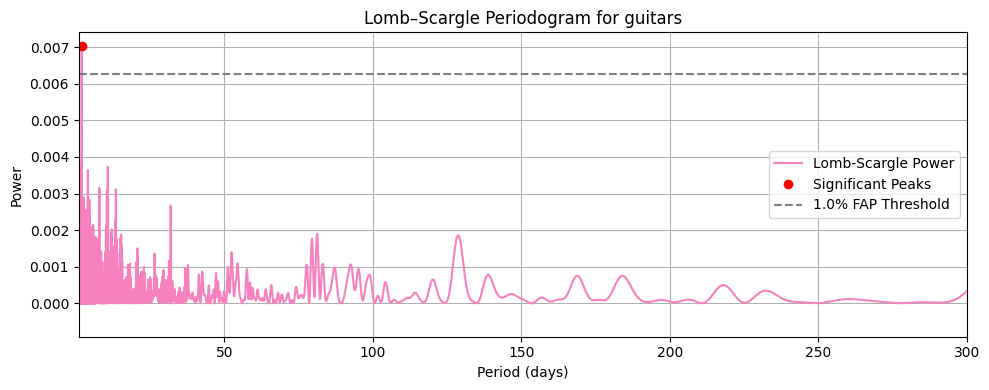

Analyzing: slingshots


<Figure size 800x400 with 0 Axes>

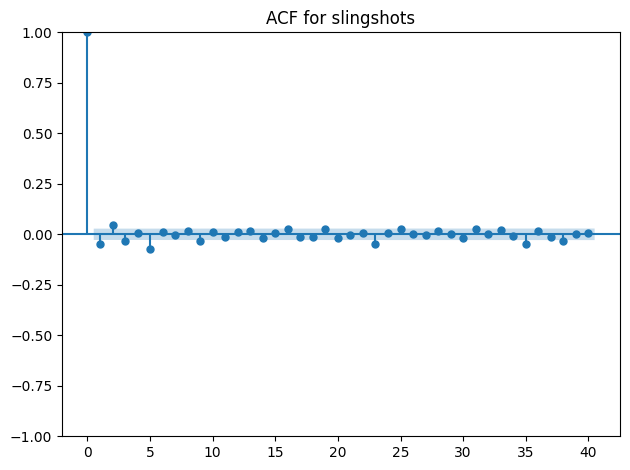

Box–Ljung Test for slingshots (10 lags):
      lb_stat     lb_pvalue
10  57.542428  1.054050e-08

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0377, FAP = 0.00000



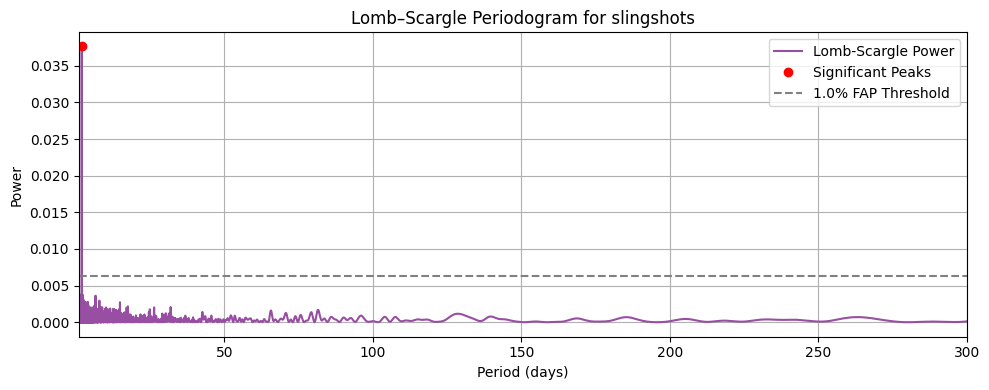

Analyzing: stocks


<Figure size 800x400 with 0 Axes>

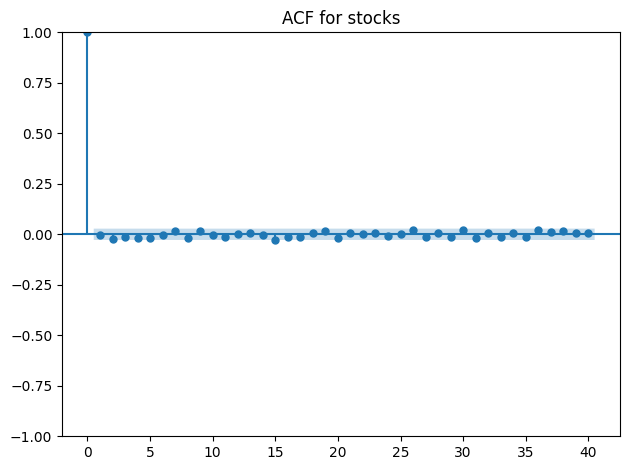

Box–Ljung Test for stocks (10 lags):
      lb_stat  lb_pvalue
10  10.452925   0.401694

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0072, FAP = 0.00103



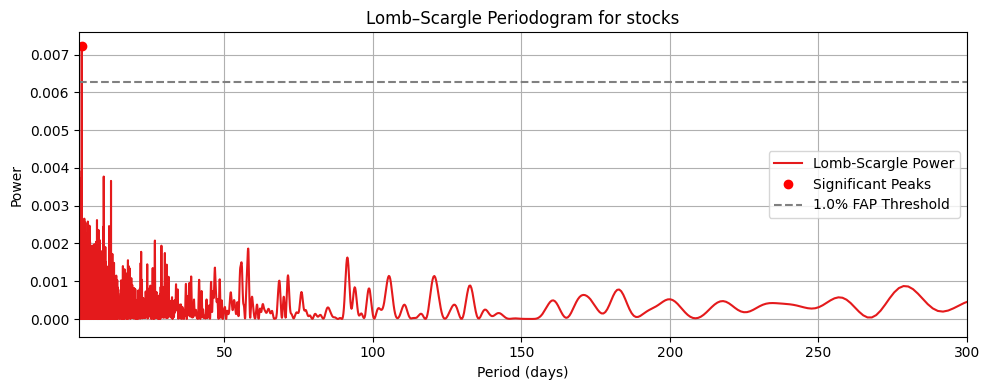

Analyzing: sugar


<Figure size 800x400 with 0 Axes>

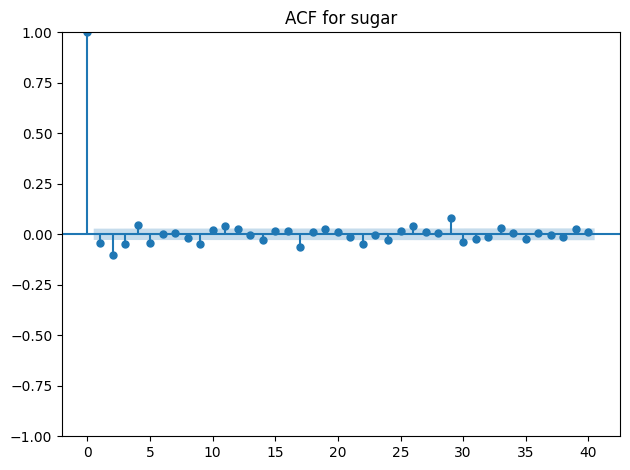

Box–Ljung Test for sugar (10 lags):
       lb_stat     lb_pvalue
10  104.805409  5.926147e-18

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0168, FAP = 0.00000



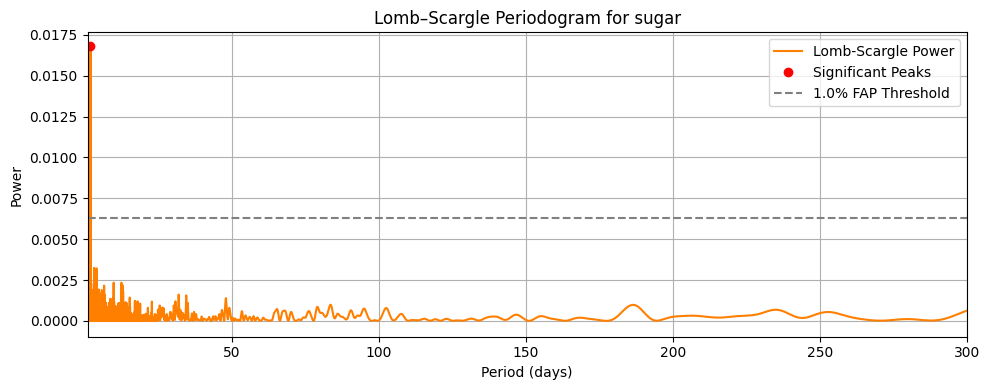

Analyzing: water


<Figure size 800x400 with 0 Axes>

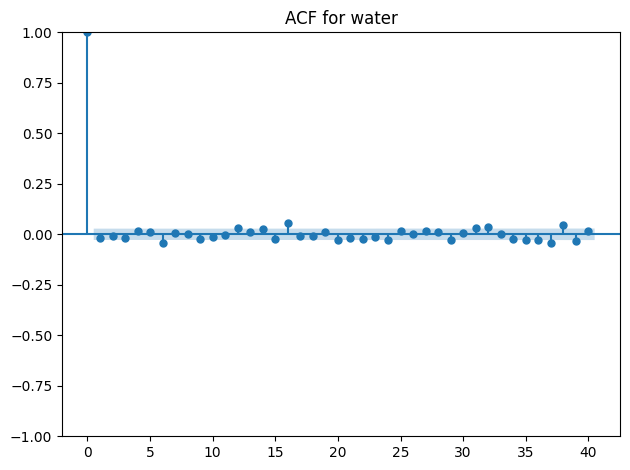

Box–Ljung Test for water (10 lags):
      lb_stat  lb_pvalue
10  18.309722   0.049958

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0181, FAP = 0.00000



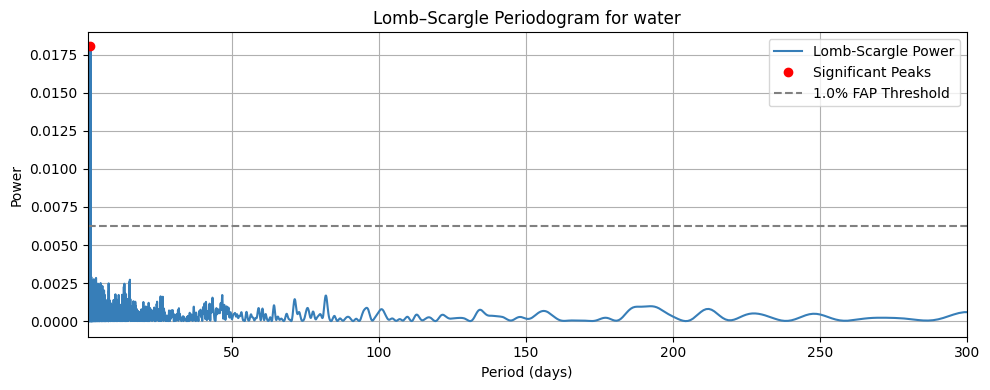

Analyzing: tranquillity


<Figure size 800x400 with 0 Axes>

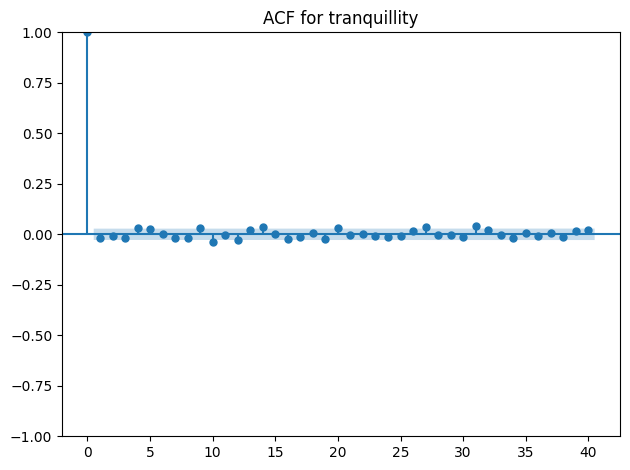

Box–Ljung Test for tranquillity (10 lags):
      lb_stat  lb_pvalue
10  27.605148   0.002087

Significant integer periods: []



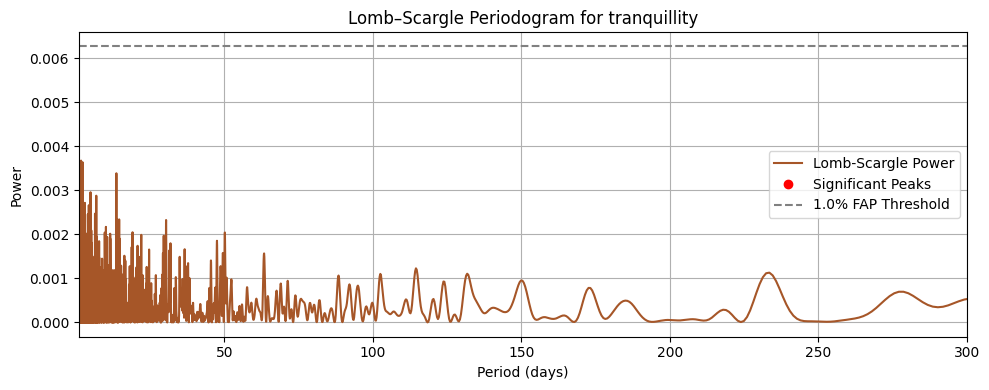

In [408]:
# Set significance threshold for peak detection
alpha = 0.01
periods_to_test = {}

# Loop over each instrument (skip 'day' column)
for col in df.columns:
    if col == 'day':
        continue

    print(f"Analyzing: {col}")

    # Get price series
    price_series = df_boxcox_guerrero[col].dropna()
    color = colours.get(col, 'black')

    # Detrending
    series = np.log(price_series / price_series.shift(1)).dropna()

    # Plot the Autocorrelation Function (ACF)
    plt.figure(figsize=(8, 4))
    plot_acf(series, lags=40) #40?
    plt.title(f"ACF for {col}")
    plt.tight_layout()
    plt.show()
    
    # Perform the Box–Ljung test 
    # The test checks the null hypothesis that the series is independently distributed.
    lb_test = acorr_ljungbox(series, lags=[10], return_df=True) #10?
    print(f"Box–Ljung Test for {col} (10 lags):\n{lb_test}\n")
    
    # Prepare time and signal vectors
    t = np.arange(len(series))
    y = series.values - np.mean(series.values)

    # Lomb–Scargle Periodogram
    min_p, max_p = 1, 5000
    ls = LombScargle(t, y)
    frequency, power = ls.autopower(
        minimum_frequency=1/max_p,
        maximum_frequency=1/min_p,
        samples_per_peak=10
    )
    period = 1.0 / frequency

    # Peak Detection & Filtering 
    peak_indices, _ = find_peaks(power)
    peak_freqs = frequency[peak_indices]
    peak_periods = 1.0 / peak_freqs
    peak_powers = power[peak_indices]

    peak_faps = ls.false_alarm_probability(peak_powers)
    significant = peak_faps < alpha

    sig_periods = peak_periods[significant]
    sig_powers = peak_powers[significant]
    sig_faps = peak_faps[significant]

    # Round and deduplicate
    rounded_periods = np.round(sig_periods).astype(int)
    unique_rounded_periods = np.unique(rounded_periods[rounded_periods > 1])

    periods_to_test[col] = set(unique_rounded_periods)

    # Output Results
    print("Significant integer periods:", unique_rounded_periods)
    for p, powr, fap in zip(sig_periods, sig_powers, sig_faps):
        print(f"  Period = {p:.2f} days, Power = {powr:.4f}, FAP = {fap:.5f}")
    print()

    # Plot 
    fap_threshold = ls.false_alarm_level(alpha)
    plt.figure(figsize=(10, 4))
    plt.plot(period, power, label="Lomb-Scargle Power", color=color)
    plt.plot(sig_periods, sig_powers, 'ro', label='Significant Peaks')
    plt.axhline(fap_threshold, linestyle="--", color="gray", label=f"{alpha*100:.1f}% FAP Threshold")
    plt.xlim(1, 300)
    plt.xlabel("Period (days)")
    plt.ylabel("Power")
    plt.title(f"Lomb–Scargle Periodogram for {col}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Analyzing cucumbers...
Tested Period 2 days: Strength = 0.108
Best Period: 2 days (Strength: 0.108)

Analyzing guitars...
Tested Period 2 days: Strength = 0.116
Best Period: 2 days (Strength: 0.116)

Analyzing slingshots...
Tested Period 2 days: Strength = 0.129
Best Period: 2 days (Strength: 0.129)

Analyzing stocks...
Tested Period 2 days: Strength = 0.134
Best Period: 2 days (Strength: 0.134)

Analyzing sugar...
Tested Period 2 days: Strength = 0.157
Best Period: 2 days (Strength: 0.157)

Analyzing water...
Tested Period 2 days: Strength = 0.136
Best Period: 2 days (Strength: 0.136)

Analyzing tranquillity...
No candidate periods found for tranquillity. Skipping.


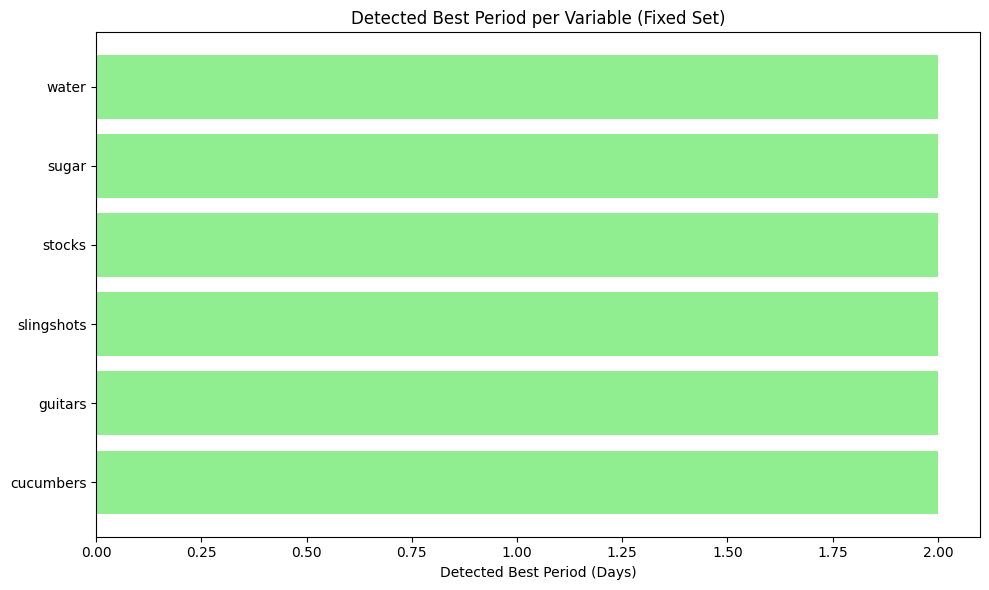

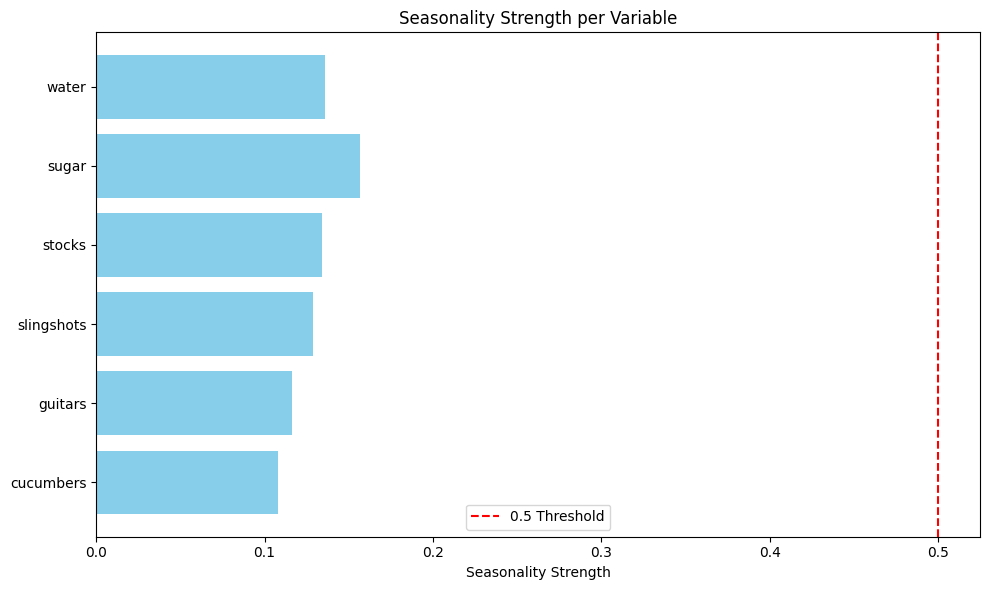

In [409]:
# Fixed periods to test
periods = periods_to_test[col]
best_periods= {}
seasonality_strengths = {}
# Analyze seasonality on transformed data
for col in df.columns:
    if col == 'day':
        continue
    print(f"\nAnalyzing {col}...")
    series = pd.Series(log_returns[col]).dropna()
    
    # Again get the periods for this column safely
    periods_for_col = list(periods_to_test.get(col, []))
    
    if not periods_for_col:
        print(f"No candidate periods found for {col}. Skipping.")
        continue
    
    best_period, best_strength = best_fixed_period(series, periods_for_col)
    
    if best_period is None:
        print(f"No good period found for {col}. Skipping.")
        continue
    
    best_periods[col] = best_period
    seasonality_strengths[col] = best_strength
    print(f"Best Period: {best_period} days (Strength: {best_strength:.3f})")

# --- Plot Results ---

plt.figure(figsize=(10, 6))
plt.barh(list(best_periods.keys()), list(best_periods.values()), color='lightgreen')
plt.xlabel("Detected Best Period (Days)")
plt.title("Detected Best Period per Variable (Fixed Set)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(list(seasonality_strengths.keys()), list(seasonality_strengths.values()), color='skyblue')
plt.xlabel("Seasonality Strength")
plt.title("Seasonality Strength per Variable")
plt.axvline(0.5, color='red', linestyle='--', label='0.5 Threshold')
plt.legend()
plt.tight_layout()
plt.show()


Seasonal strength of mle Box-cox transformed and Diffrense detrending

Analyzing: cucumbers


<Figure size 800x400 with 0 Axes>

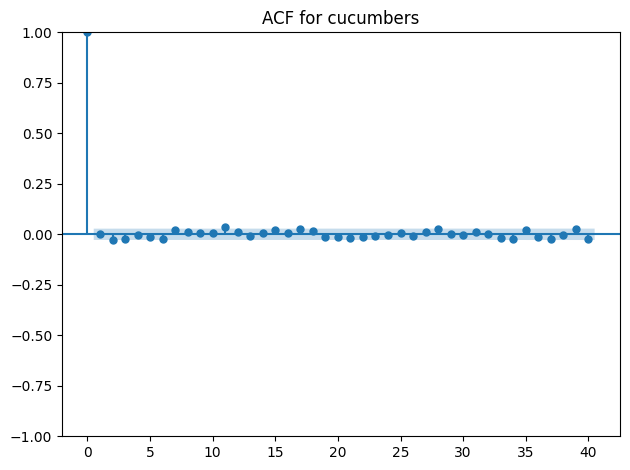

Box–Ljung Test for cucumbers (10 lags):
      lb_stat  lb_pvalue
10  12.943033   0.226874

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0264, FAP = 0.00000



c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:251: RuntimeWarning: invalid value encountered in sqrt
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)


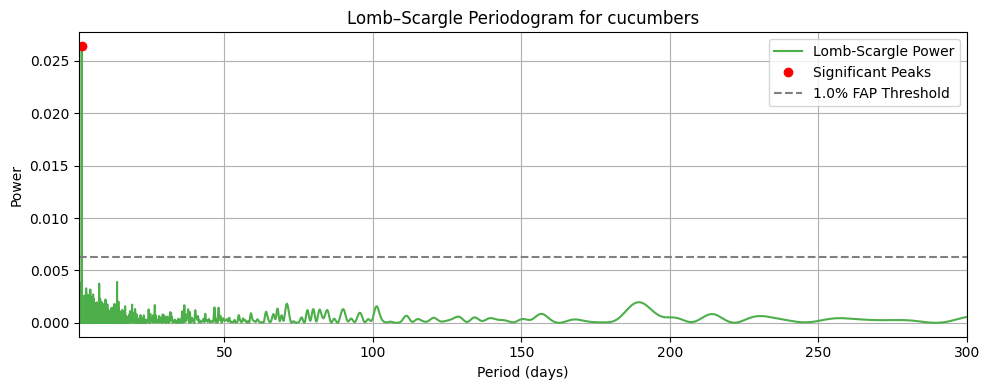

Analyzing: guitars


<Figure size 800x400 with 0 Axes>

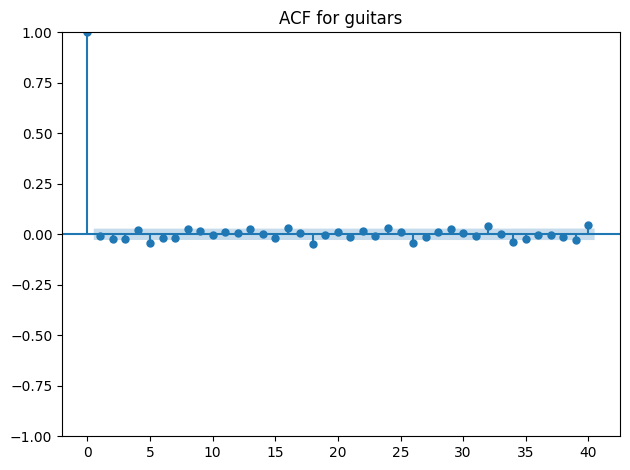

Box–Ljung Test for guitars (10 lags):
      lb_stat  lb_pvalue
10  25.738438   0.004108

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0106, FAP = 0.00000



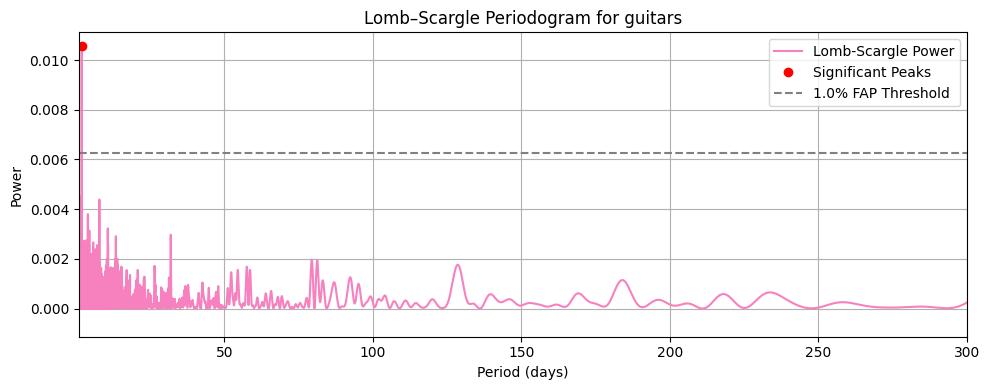

Analyzing: slingshots


<Figure size 800x400 with 0 Axes>

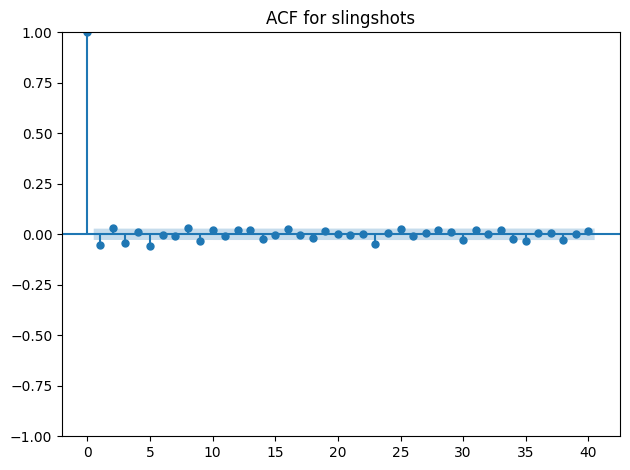

Box–Ljung Test for slingshots (10 lags):
      lb_stat     lb_pvalue
10  56.400998  1.726704e-08

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0379, FAP = 0.00000



c:\Users\veron\AppData\Local\Programs\Python\Python313\Lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:251: RuntimeWarning: invalid value encountered in sqrt
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)


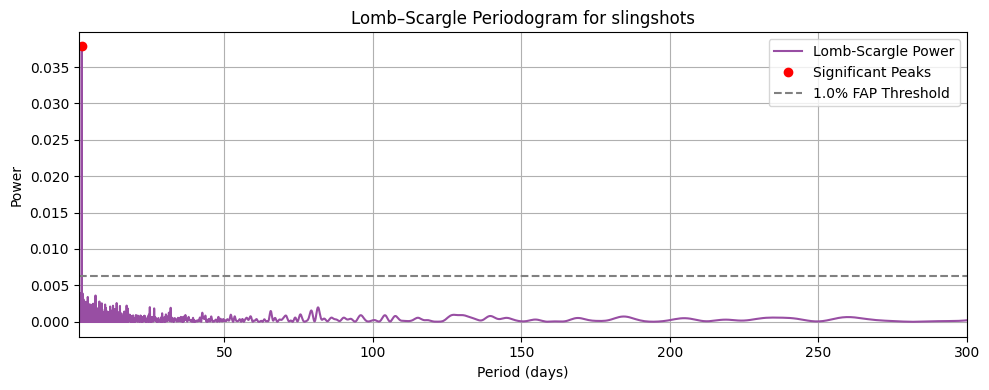

Analyzing: stocks


<Figure size 800x400 with 0 Axes>

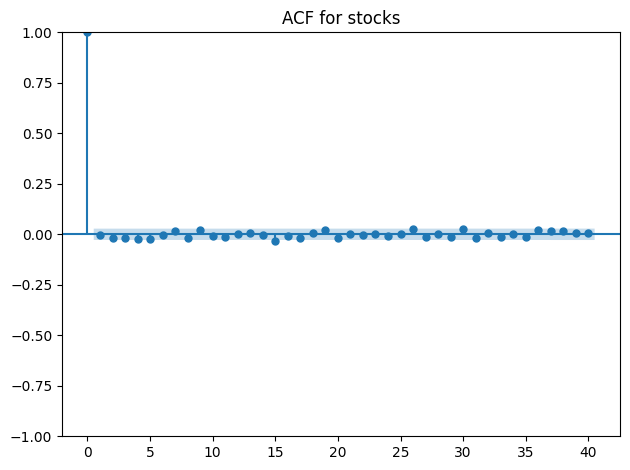

Box–Ljung Test for stocks (10 lags):
      lb_stat  lb_pvalue
10  13.585437   0.192754

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0081, FAP = 0.00012



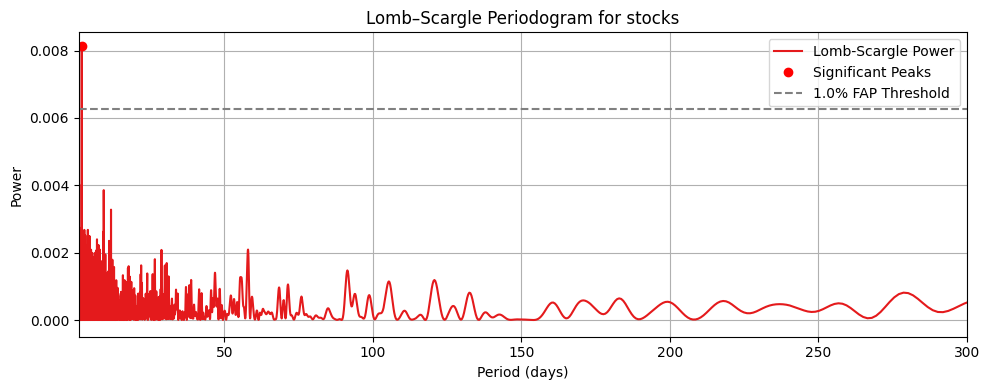

Analyzing: sugar


<Figure size 800x400 with 0 Axes>

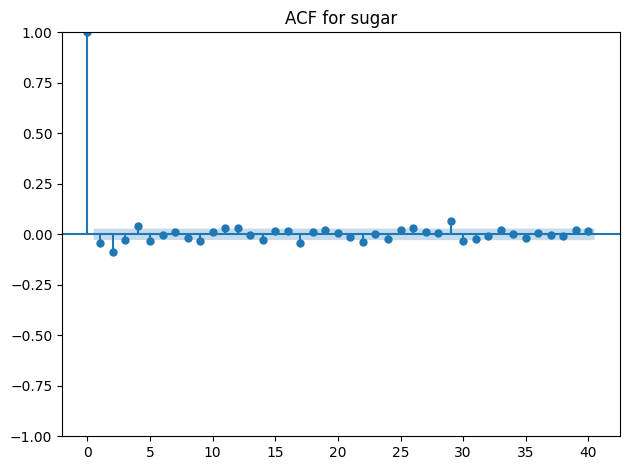

Box–Ljung Test for sugar (10 lags):
      lb_stat     lb_pvalue
10  70.392669  3.723340e-11

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0116, FAP = 0.00000



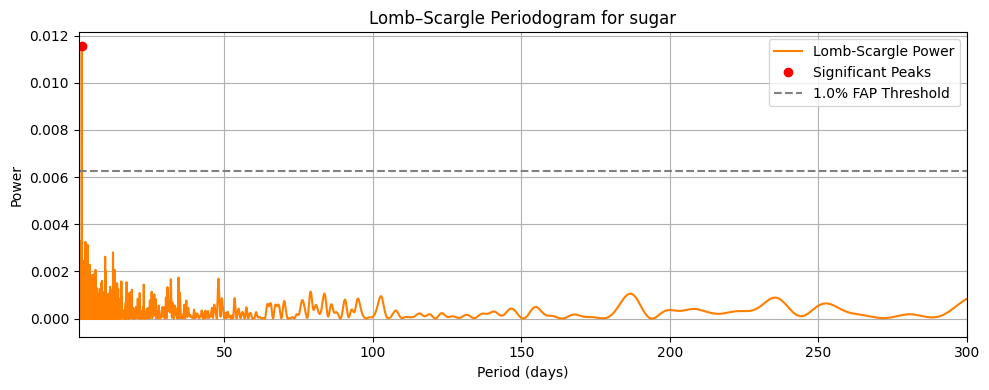

Analyzing: water


<Figure size 800x400 with 0 Axes>

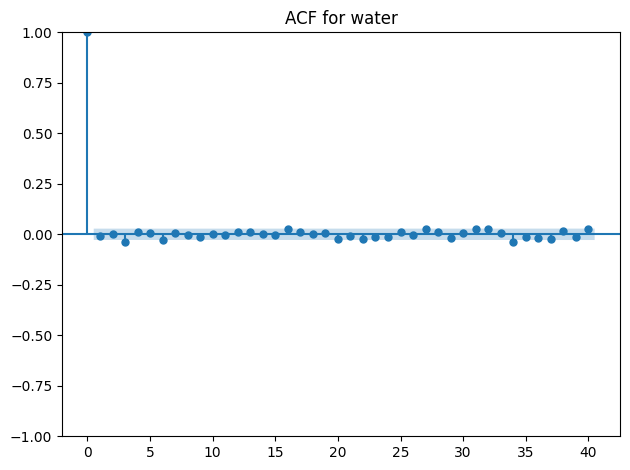

Box–Ljung Test for water (10 lags):
      lb_stat  lb_pvalue
10  12.942525   0.226903

Significant integer periods: [2]
  Period = 2.00 days, Power = 0.0394, FAP = 0.00000



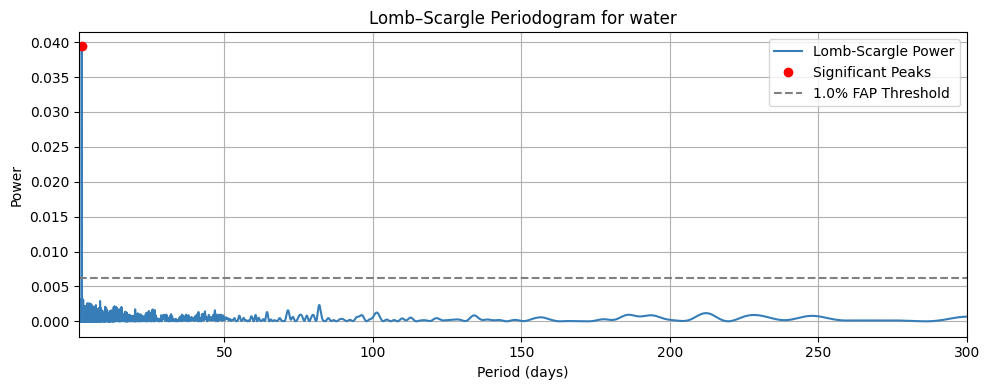

Analyzing: tranquillity


<Figure size 800x400 with 0 Axes>

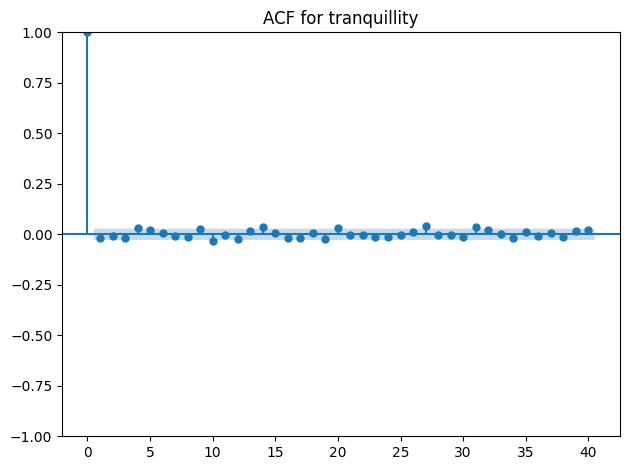

Box–Ljung Test for tranquillity (10 lags):
      lb_stat  lb_pvalue
10  20.607827      0.024

Significant integer periods: []



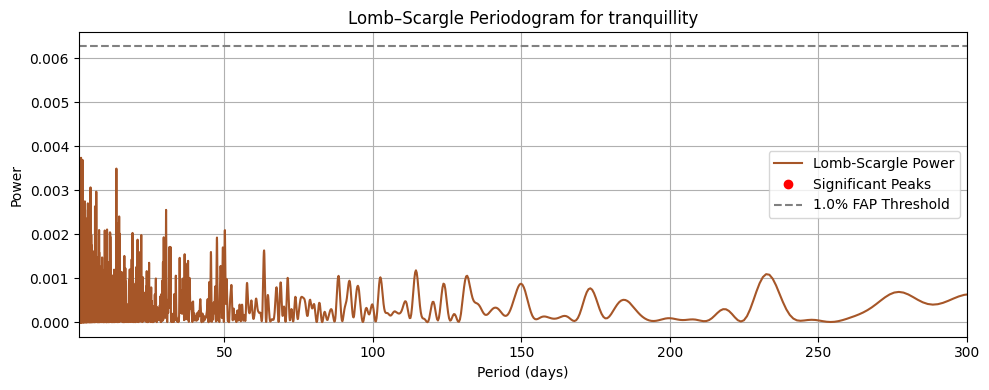

In [410]:
# Set significance threshold for peak detection
alpha = 0.01
periods_to_test = {}

# Loop over each instrument (skip 'day' column)
for col in df.columns:
    if col == 'day':
        continue

    print(f"Analyzing: {col}")

    # Get price series
    price_series = df_boxcox_mle[col].dropna()
    color = colours.get(col, 'black')

    # Detrending
    series = np.log(price_series / price_series.shift(1)).dropna()

    # Plot the Autocorrelation Function (ACF)
    plt.figure(figsize=(8, 4))
    plot_acf(series, lags=40) #40?
    plt.title(f"ACF for {col}")
    plt.tight_layout()
    plt.show()
    
    # Perform the Box–Ljung test 
    # The test checks the null hypothesis that the series is independently distributed.
    lb_test = acorr_ljungbox(series, lags=[10], return_df=True) #10?
    print(f"Box–Ljung Test for {col} (10 lags):\n{lb_test}\n")
    
    # Prepare time and signal vectors
    t = np.arange(len(series))
    y = series.values - np.mean(series.values)

    # Lomb–Scargle Periodogram
    min_p, max_p = 1, 5000
    ls = LombScargle(t, y)
    frequency, power = ls.autopower(
        minimum_frequency=1/max_p,
        maximum_frequency=1/min_p,
        samples_per_peak=10
    )
    period = 1.0 / frequency

    # Peak Detection & Filtering 
    peak_indices, _ = find_peaks(power)
    peak_freqs = frequency[peak_indices]
    peak_periods = 1.0 / peak_freqs
    peak_powers = power[peak_indices]

    peak_faps = ls.false_alarm_probability(peak_powers)
    significant = peak_faps < alpha

    sig_periods = peak_periods[significant]
    sig_powers = peak_powers[significant]
    sig_faps = peak_faps[significant]

    # Round and deduplicate
    rounded_periods = np.round(sig_periods).astype(int)
    unique_rounded_periods = np.unique(rounded_periods[rounded_periods > 1])

    periods_to_test[col] = set(unique_rounded_periods)

    # Output Results
    print("Significant integer periods:", unique_rounded_periods)
    for p, powr, fap in zip(sig_periods, sig_powers, sig_faps):
        print(f"  Period = {p:.2f} days, Power = {powr:.4f}, FAP = {fap:.5f}")
    print()

    # Plot 
    fap_threshold = ls.false_alarm_level(alpha)
    plt.figure(figsize=(10, 4))
    plt.plot(period, power, label="Lomb-Scargle Power", color=color)
    plt.plot(sig_periods, sig_powers, 'ro', label='Significant Peaks')
    plt.axhline(fap_threshold, linestyle="--", color="gray", label=f"{alpha*100:.1f}% FAP Threshold")
    plt.xlim(1, 300)
    plt.xlabel("Period (days)")
    plt.ylabel("Power")
    plt.title(f"Lomb–Scargle Periodogram for {col}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Seasonal strength of ma detrended data


Analyzing cucumbers...
Tested Period 2 days: Strength = 0.108
Best Period: 2 days (Strength: 0.108)

Analyzing guitars...
Tested Period 2 days: Strength = 0.116
Best Period: 2 days (Strength: 0.116)

Analyzing slingshots...
Tested Period 2 days: Strength = 0.129
Best Period: 2 days (Strength: 0.129)

Analyzing stocks...
Tested Period 2 days: Strength = 0.134
Best Period: 2 days (Strength: 0.134)

Analyzing sugar...
Tested Period 2 days: Strength = 0.157
Best Period: 2 days (Strength: 0.157)

Analyzing water...
Tested Period 2 days: Strength = 0.136
Best Period: 2 days (Strength: 0.136)

Analyzing tranquillity...
No candidate periods found for tranquillity. Skipping.


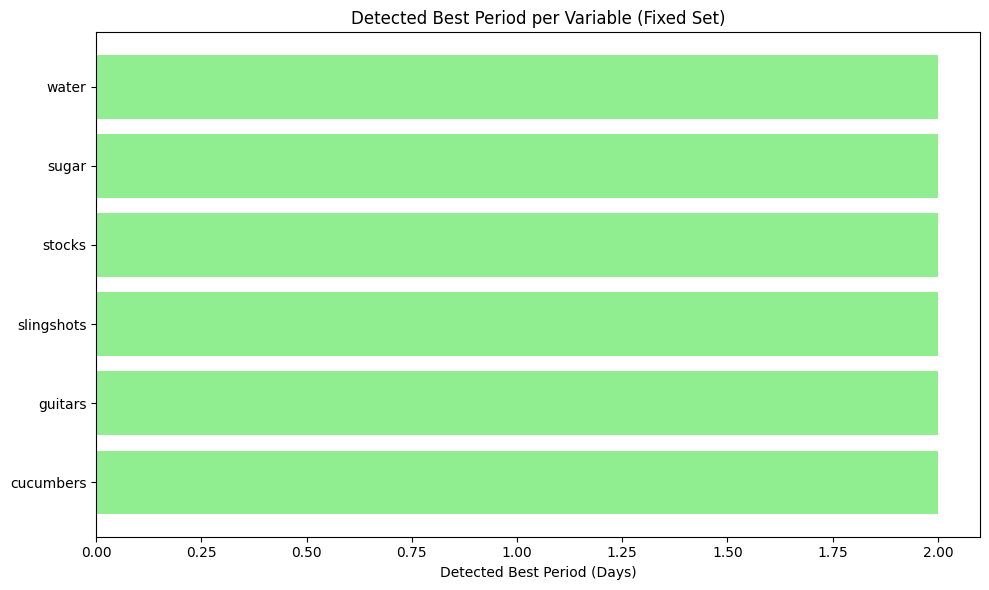

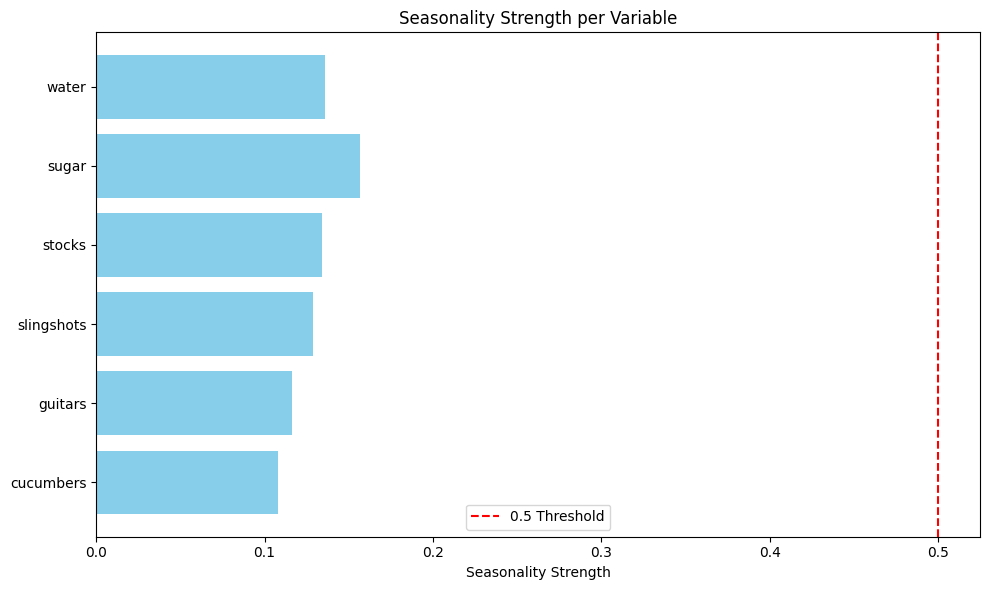

In [411]:
# Fixed periods to test
periods = periods_to_test[col]
best_periods= {}
seasonality_strengths = {}
# Analyze seasonality on transformed data
for col in df.columns:
    if col == 'day':
        continue
    print(f"\nAnalyzing {col}...")
    series = pd.Series(log_returns[col]).dropna()
    
    # Again get the periods for this column safely
    periods_for_col = list(periods_to_test.get(col, []))
    
    if not periods_for_col:
        print(f"No candidate periods found for {col}. Skipping.")
        continue
    
    best_period, best_strength = best_fixed_period(series, periods_for_col)
    
    if best_period is None:
        print(f"No good period found for {col}. Skipping.")
        continue
    
    best_periods[col] = best_period
    seasonality_strengths[col] = best_strength
    print(f"Best Period: {best_period} days (Strength: {best_strength:.3f})")

# --- Plot Results ---

plt.figure(figsize=(10, 6))
plt.barh(list(best_periods.keys()), list(best_periods.values()), color='lightgreen')
plt.xlabel("Detected Best Period (Days)")
plt.title("Detected Best Period per Variable (Fixed Set)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(list(seasonality_strengths.keys()), list(seasonality_strengths.values()), color='skyblue')
plt.xlabel("Seasonality Strength")
plt.title("Seasonality Strength per Variable")
plt.axvline(0.5, color='red', linestyle='--', label='0.5 Threshold')
plt.legend()
plt.tight_layout()
plt.show()


Seasonal strength on ma detrended data

In [418]:
# Heuristic-based window selection + detrending
detrended_df = pd.DataFrame(index=df.index)
optimal_windows = {}
 
def compute_optimal_window(series, window_range):
    global_mean = series.mean()
    N = len(series)
    results = []
 
    for w in window_range:
        # Centered moving average
        ma = series.rolling(window=w, center=True, min_periods=1).mean()
        valid_idx = ma.dropna().index
        if len(valid_idx) == 0:
            continue
        m_bar_w = ma.loc[valid_idx].mean()
 
        # D(w)
        D_w = abs(m_bar_w - global_mean)
 
        # E(w)
        E_terms = []
        for t in valid_idx:
            half = w // 2
            window_vals = series[max(0, t - half): min(N, t + half + 1)]
            if len(window_vals) >= 2:
                std = window_vals.std(ddof=1)
                se = std / np.sqrt(len(window_vals))
                E_terms.append(se)
        E_w = np.mean(E_terms) if E_terms else np.nan
 
        # S(w)
        S_w = D_w - E_w if not np.isnan(E_w) else np.nan
        results.append((w, D_w, E_w, S_w))
 
    df = pd.DataFrame(results, columns=["window", "D(w)", "E(w)", "S(w)"]).dropna()
    if df.empty:
        return None, None
    best_row = df.loc[df["S(w)"].idxmax()]
    return int(best_row["window"]), df
 
# Apply to each transformed series
for col in df.columns:
    if col == 'day':
        continue
    print(f"Detrending {col}...")
    series = df[col].dropna()
    window_range = range(5, 51, 2)  # Try odd window sizes from 5 to 50
 
    best_w, score_table = compute_optimal_window(series, window_range)
    if best_w is None:
        print(f"No valid window found for {col}.")
        continue
 
    trend = series.rolling(window=best_w, center=True, min_periods=1).mean()
    detrended = (series - trend).dropna()
 
    detrended_df[col] = detrended
    optimal_windows[col] = best_w
    print(f"Best window size for {col}: {best_w}")

Detrending cucumbers...
Best window size for cucumbers: 33
Detrending guitars...
Best window size for guitars: 49
Detrending slingshots...
Best window size for slingshots: 49
Detrending stocks...
Best window size for stocks: 49
Detrending sugar...
Best window size for sugar: 23
Detrending water...
Best window size for water: 15
Detrending tranquillity...
Best window size for tranquillity: 45


<Figure size 800x400 with 0 Axes>

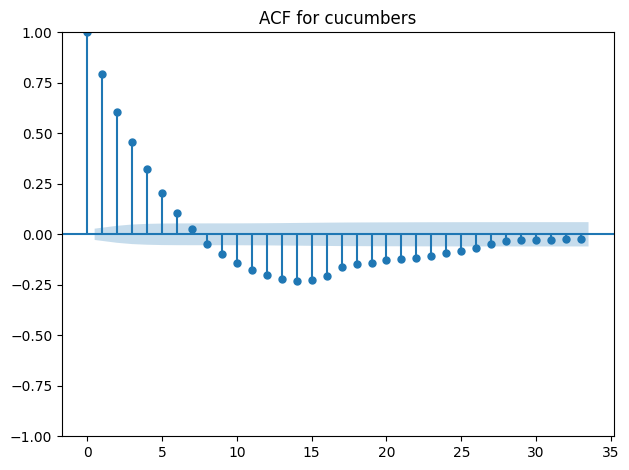

Box–Ljung Test for cucumbers (10 lags):
        lb_stat  lb_pvalue
33  8910.481498        0.0

Instrument: cucumbers
Significant integer periods (no duplicates): [ 20  22  25  26  27  29  30  31  32  36  37  38  40  44  47  48  49  55
  59  64  68  71  78  80 102]
Detailed significant peaks:
  Period = 101.53 days, Power = 0.0064, FAP = 0.00787
  Period = 79.99 days, Power = 0.0064, FAP = 0.00696
  Period = 77.95 days, Power = 0.0065, FAP = 0.00583
  Period = 71.06 days, Power = 0.0094, FAP = 0.00001
  Period = 68.00 days, Power = 0.0094, FAP = 0.00001
  Period = 64.00 days, Power = 0.0081, FAP = 0.00012
  Period = 58.92 days, Power = 0.0083, FAP = 0.00007
  Period = 54.90 days, Power = 0.0084, FAP = 0.00007
  Period = 48.73 days, Power = 0.0065, FAP = 0.00590
  Period = 48.06 days, Power = 0.0126, FAP = 0.00000
  Period = 46.73 days, Power = 0.0098, FAP = 0.00000
  Period = 43.57 days, Power = 0.0075, FAP = 0.00051
  Period = 40.18 days, Power = 0.0091, FAP = 0.00001
  Period = 38.44 

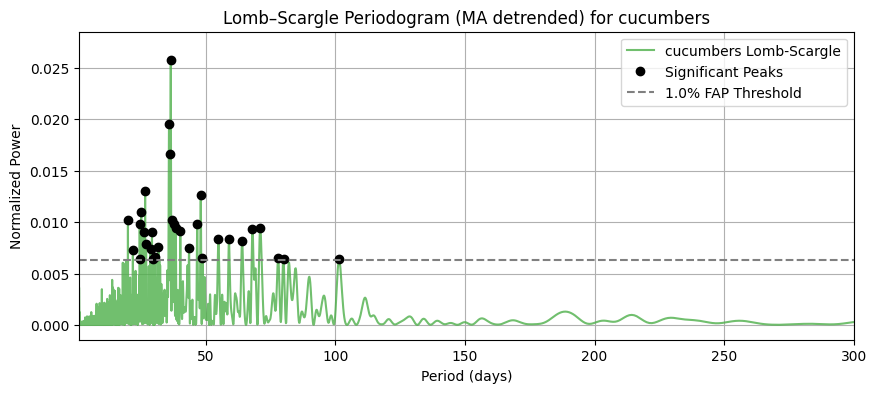

<Figure size 800x400 with 0 Axes>

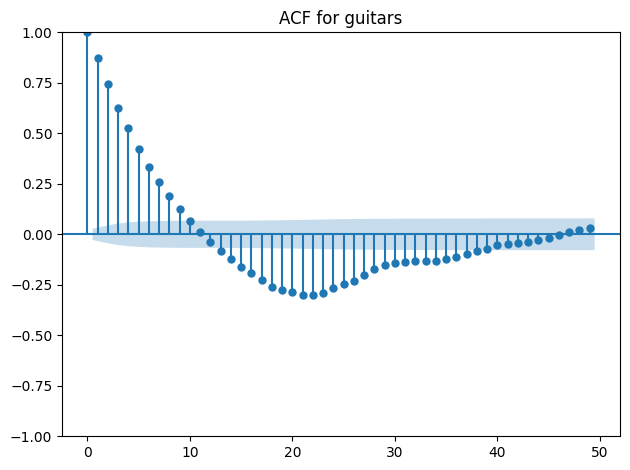

Box–Ljung Test for guitars (10 lags):
         lb_stat  lb_pvalue
49  16945.186011        0.0

Instrument: guitars
Significant integer periods (no duplicates): [ 27  29  31  32  36  37  38  41  43  44  45  46  47  48  51  52  54  55
  56  58  59  61  64  66  68  69  79  81  83  87  92  95 103 128]
Detailed significant peaks:
  Period = 128.07 days, Power = 0.0080, FAP = 0.00015
  Period = 103.46 days, Power = 0.0075, FAP = 0.00059
  Period = 95.22 days, Power = 0.0079, FAP = 0.00021
  Period = 92.35 days, Power = 0.0094, FAP = 0.00001
  Period = 86.94 days, Power = 0.0088, FAP = 0.00002
  Period = 83.25 days, Power = 0.0099, FAP = 0.00000
  Period = 81.31 days, Power = 0.0182, FAP = 0.00000
  Period = 79.34 days, Power = 0.0184, FAP = 0.00000
  Period = 69.35 days, Power = 0.0091, FAP = 0.00001
  Period = 67.90 days, Power = 0.0063, FAP = 0.00911
  Period = 65.63 days, Power = 0.0104, FAP = 0.00000
  Period = 64.00 days, Power = 0.0109, FAP = 0.00000
  Period = 61.13 days, Power = 0.00

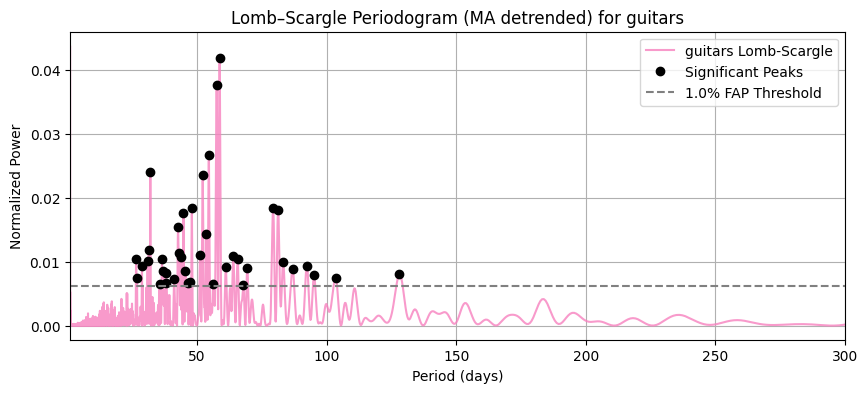

<Figure size 800x400 with 0 Axes>

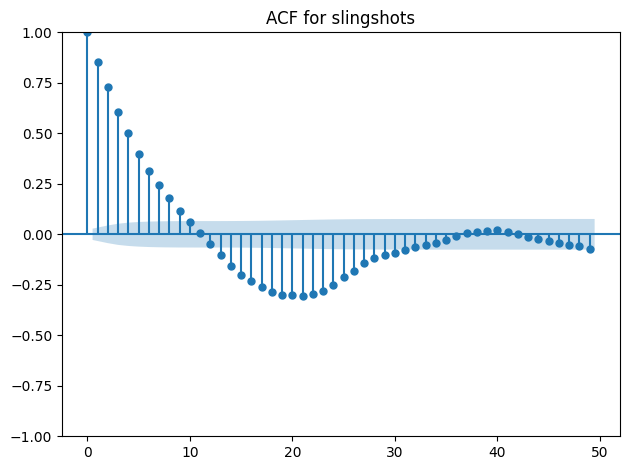

Box–Ljung Test for slingshots (10 lags):
         lb_stat  lb_pvalue
49  15647.630854        0.0

Instrument: slingshots
Significant integer periods (no duplicates): [ 25  26  29  31  32  34  35  36  37  38  39  42  43  44  45  46  48  49
  50  52  53  56  58  59  61  66  67  68  70  75  79  81  96 104]
Detailed significant peaks:
  Period = 103.90 days, Power = 0.0096, FAP = 0.00000
  Period = 95.78 days, Power = 0.0074, FAP = 0.00067
  Period = 81.45 days, Power = 0.0260, FAP = 0.00000
  Period = 79.34 days, Power = 0.0194, FAP = 0.00000
  Period = 75.43 days, Power = 0.0144, FAP = 0.00000
  Period = 69.94 days, Power = 0.0068, FAP = 0.00253
  Period = 68.38 days, Power = 0.0081, FAP = 0.00013
  Period = 66.98 days, Power = 0.0104, FAP = 0.00000
  Period = 65.54 days, Power = 0.0172, FAP = 0.00000
  Period = 60.82 days, Power = 0.0122, FAP = 0.00000
  Period = 58.85 days, Power = 0.0193, FAP = 0.00000
  Period = 57.61 days, Power = 0.0106, FAP = 0.00000
  Period = 56.09 days, Power =

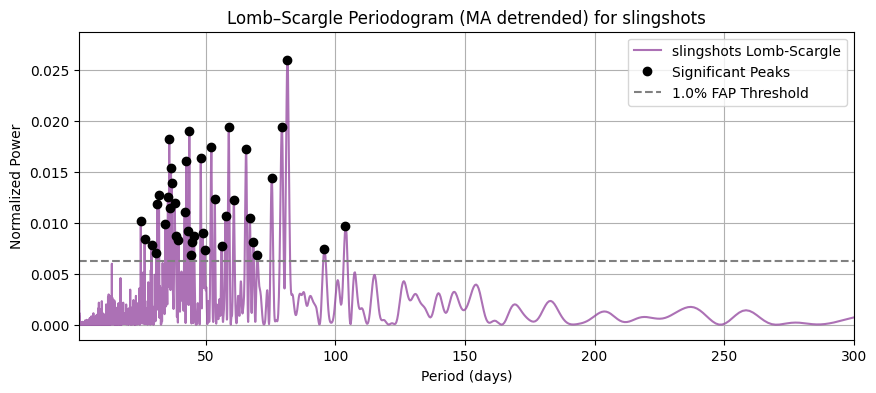

<Figure size 800x400 with 0 Axes>

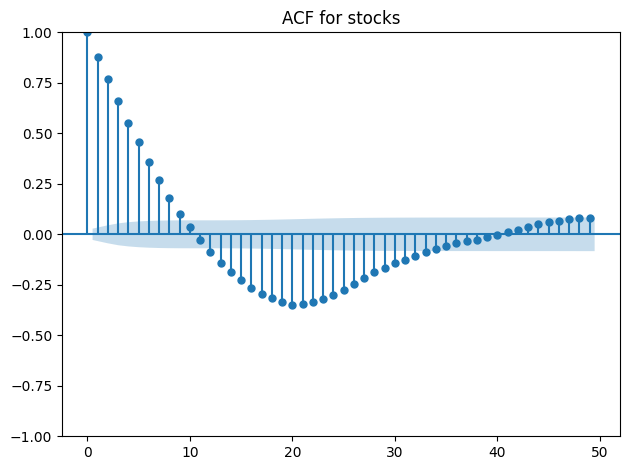

Box–Ljung Test for stocks (10 lags):
         lb_stat  lb_pvalue
49  19326.261041        0.0

Instrument: stocks
Significant integer periods (no duplicates): [22 27 29 30 31 32 33 35 36 37 39 40 41 44 45 46 47 48 52 54 56 57 58 61
 63 69 71 76 91 94 99]
Detailed significant peaks:
  Period = 98.67 days, Power = 0.0063, FAP = 0.00866
  Period = 93.76 days, Power = 0.0099, FAP = 0.00000
  Period = 91.32 days, Power = 0.0194, FAP = 0.00000
  Period = 76.02 days, Power = 0.0089, FAP = 0.00002
  Period = 71.47 days, Power = 0.0139, FAP = 0.00000
  Period = 68.86 days, Power = 0.0094, FAP = 0.00000
  Period = 62.77 days, Power = 0.0063, FAP = 0.00939
  Period = 61.05 days, Power = 0.0098, FAP = 0.00000
  Period = 58.29 days, Power = 0.0182, FAP = 0.00000
  Period = 57.34 days, Power = 0.0298, FAP = 0.00000
  Period = 56.54 days, Power = 0.0161, FAP = 0.00000
  Period = 55.83 days, Power = 0.0369, FAP = 0.00000
  Period = 54.47 days, Power = 0.0088, FAP = 0.00002
  Period = 53.69 days, Power 

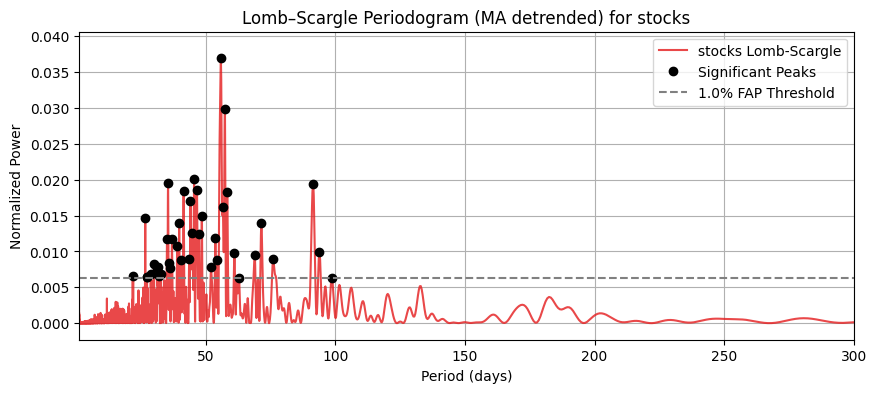

<Figure size 800x400 with 0 Axes>

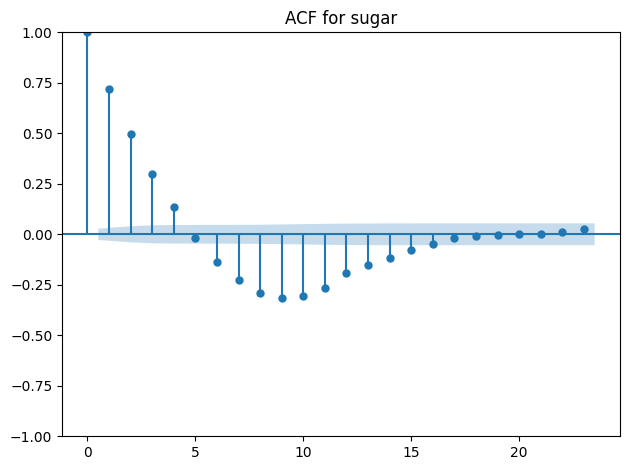

Box–Ljung Test for sugar (10 lags):
        lb_stat  lb_pvalue
23  6749.731972        0.0

Instrument: sugar
Significant integer periods (no duplicates): [13 14 15 17 18 19 21 23 25 26 27 28 31 32 35]
Detailed significant peaks:
  Period = 34.61 days, Power = 0.0083, FAP = 0.00009
  Period = 31.97 days, Power = 0.0077, FAP = 0.00031
  Period = 30.84 days, Power = 0.0081, FAP = 0.00012
  Period = 28.05 days, Power = 0.0071, FAP = 0.00129
  Period = 27.91 days, Power = 0.0071, FAP = 0.00125
  Period = 27.67 days, Power = 0.0066, FAP = 0.00409
  Period = 26.88 days, Power = 0.0068, FAP = 0.00262
  Period = 26.44 days, Power = 0.0112, FAP = 0.00000
  Period = 25.79 days, Power = 0.0066, FAP = 0.00417
  Period = 25.51 days, Power = 0.0097, FAP = 0.00000
  Period = 25.07 days, Power = 0.0086, FAP = 0.00004
  Period = 24.90 days, Power = 0.0078, FAP = 0.00023
  Period = 23.05 days, Power = 0.0091, FAP = 0.00001
  Period = 22.88 days, Power = 0.0133, FAP = 0.00000
  Period = 21.49 days, Power 

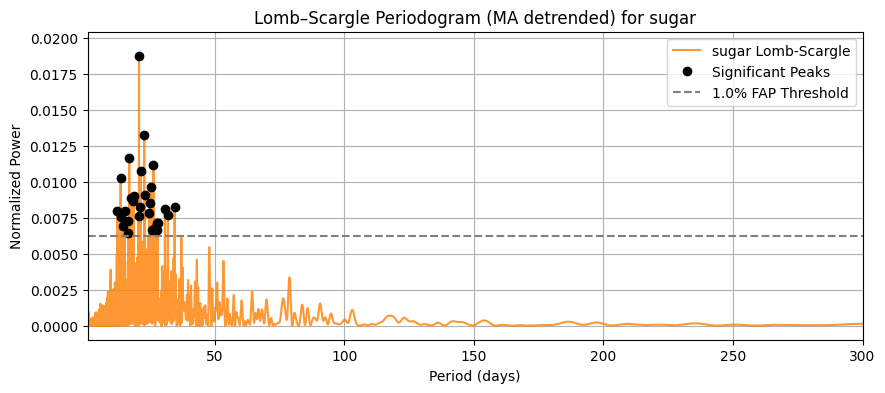

<Figure size 800x400 with 0 Axes>

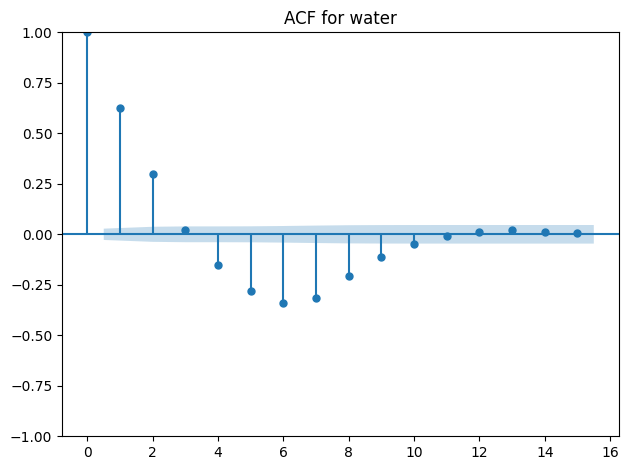

Box–Ljung Test for water (10 lags):
        lb_stat  lb_pvalue
15  4183.188469        0.0

Instrument: water
Significant integer periods (no duplicates): [10 12 13 14 15 20]
Detailed significant peaks:
  Period = 19.99 days, Power = 0.0068, FAP = 0.00282
  Period = 14.98 days, Power = 0.0073, FAP = 0.00090
  Period = 14.59 days, Power = 0.0082, FAP = 0.00009
  Period = 13.88 days, Power = 0.0068, FAP = 0.00281
  Period = 13.82 days, Power = 0.0075, FAP = 0.00051
  Period = 13.54 days, Power = 0.0064, FAP = 0.00790
  Period = 13.00 days, Power = 0.0104, FAP = 0.00000
  Period = 12.75 days, Power = 0.0079, FAP = 0.00022
  Period = 12.52 days, Power = 0.0075, FAP = 0.00049
  Period = 11.91 days, Power = 0.0077, FAP = 0.00032
  Period = 10.21 days, Power = 0.0081, FAP = 0.00012
  Period = 10.18 days, Power = 0.0075, FAP = 0.00049
  Period = 9.91 days, Power = 0.0069, FAP = 0.00241
  Period = 9.87 days, Power = 0.0071, FAP = 0.00128
  Period = 1.11 days, Power = 0.0074, FAP = 0.00067
  Peri

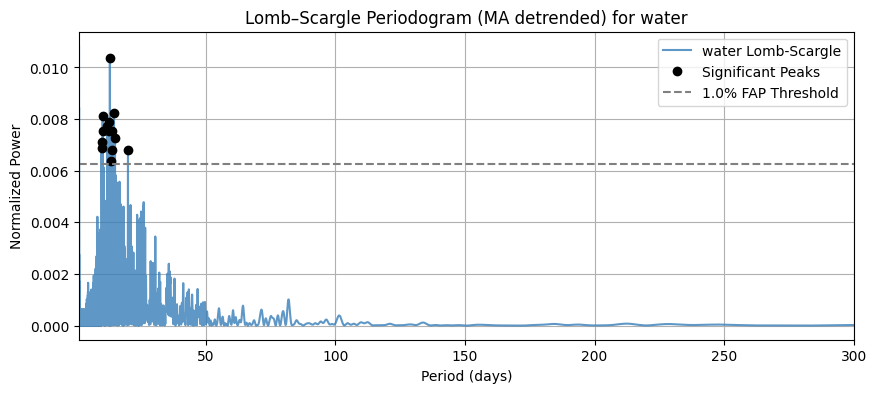

<Figure size 800x400 with 0 Axes>

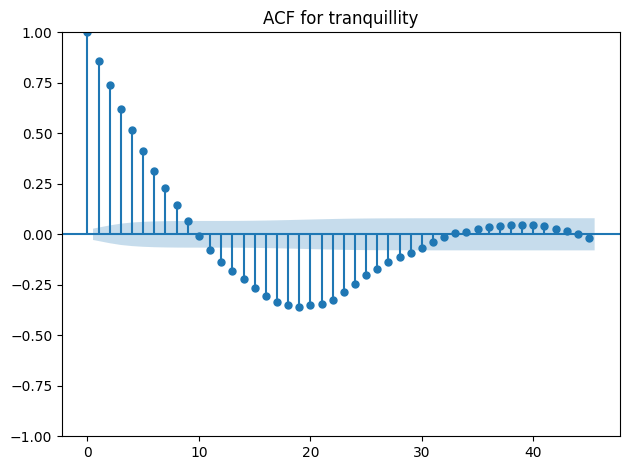

Box–Ljung Test for tranquillity (10 lags):
       lb_stat  lb_pvalue
45  17404.5138        0.0

Instrument: tranquillity
Significant integer periods (no duplicates): [30 31 32 34 35 36 37 38 39 42 45 46 47 48 49 50 51 52 53 55 58 61 63 65
 68 69 71 78 92]
Detailed significant peaks:
  Period = 92.00 days, Power = 0.0082, FAP = 0.00010
  Period = 78.45 days, Power = 0.0090, FAP = 0.00002
  Period = 71.37 days, Power = 0.0099, FAP = 0.00000
  Period = 68.86 days, Power = 0.0092, FAP = 0.00001
  Period = 67.53 days, Power = 0.0117, FAP = 0.00000
  Period = 64.68 days, Power = 0.0073, FAP = 0.00078
  Period = 63.34 days, Power = 0.0183, FAP = 0.00000
  Period = 60.52 days, Power = 0.0073, FAP = 0.00091
  Period = 57.61 days, Power = 0.0109, FAP = 0.00000
  Period = 55.27 days, Power = 0.0066, FAP = 0.00482
  Period = 53.17 days, Power = 0.0074, FAP = 0.00066
  Period = 52.04 days, Power = 0.0085, FAP = 0.00005
  Period = 51.38 days, Power = 0.0070, FAP = 0.00175
  Period = 50.23 days, Powe

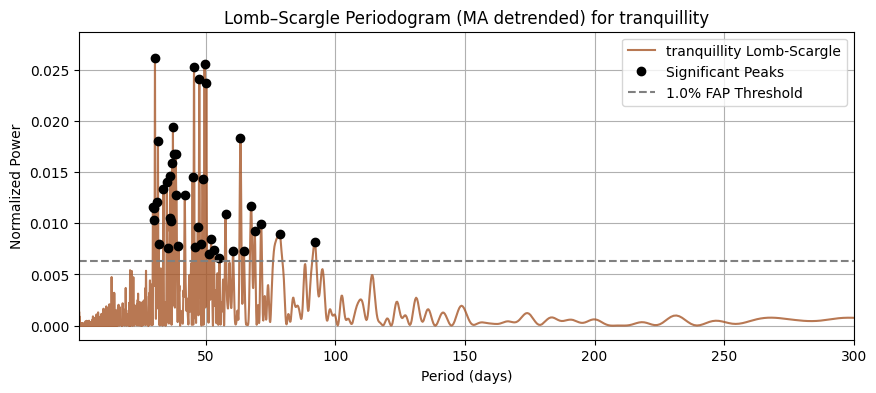

In [419]:
#Lomb Scargle
# Define the significance level for FAP filtering.
alpha = 0.01
periods_to_test = {}

# Loop over each instrument (all columns except 'day')
for col in df.columns:
    if col == 'day':
        continue
    
    # Extract the series and assign its plotting color.
    series = df[col].dropna()
    color = colours.get(col, 'black')
    
    # Moving-Average Detrending 
    window = optimal_windows[col]
    detrended = detrended_df[col]
    
    # Plot the Autocorrelation Function (ACF)
    plt.figure(figsize=(8, 4))
    plot_acf(detrended, lags=window )
    plt.title(f"ACF for {col}")
    plt.tight_layout()
    plt.show()
    
    # Perform the Box–Ljung test 
    # The test checks the null hypothesis that the series is independently distributed.
    lb_test = acorr_ljungbox(detrended, lags=[window ], return_df=True)
    print(f"Box–Ljung Test for {col} (10 lags):\n{lb_test}\n")
    
    # Numeric time & zero-mean adjustment 
    t = np.arange(len(detrended))
    y = detrended.values
    y -= np.mean(y)

    # Lomb–Scargle Periodogram Calculation
    min_p, max_p = 1, 2500  # period limits in days
    ls = LombScargle(t, y)
    frequency, power = ls.autopower(
        minimum_frequency=1/max_p,
        maximum_frequency=1/min_p,
        samples_per_peak=10
    )
    period = 1.0 / frequency

    # Detect local peaks in the periodogram 
    peak_indices, _ = find_peaks(power)
    peak_freqs = frequency[peak_indices]
    peak_periods = 1.0 / peak_freqs
    peak_powers = power[peak_indices]

    # Compute False Alarm Probability (FAP) for each peak
    peak_faps = ls.false_alarm_probability(peak_powers)

    # Filter peaks by significance level α < 0.01 
    significant = peak_faps < alpha
    sig_periods = peak_periods[significant]
    sig_powers = peak_powers[significant]
    sig_faps = peak_faps[significant]

    # Round significant periods to integers, remove duplicates, and keep only values > 1
    rounded_periods = np.round(sig_periods).astype(int)
    unique_rounded_periods = np.unique(rounded_periods[rounded_periods > 1])

    # Save the candidate periods as a set into the dictionary.
    periods_to_test[col] = set(unique_rounded_periods)
    
    # Output the candidate seasonal periods 
    print(f"Instrument: {col}")
    print("Significant integer periods (no duplicates):", unique_rounded_periods)
    print("Detailed significant peaks:")
    for p, powr, fap in zip(sig_periods, sig_powers, sig_faps):
        print(f"  Period = {p:.2f} days, Power = {powr:.4f}, FAP = {fap:.5f}")
    print("\n")
    
    # Plot periodogram with significant peaks marked as red dots 
    fap_threshold = ls.false_alarm_level(alpha)
    plt.figure(figsize=(10, 4))
    plt.plot(period, power, label=f"{col} Lomb-Scargle", alpha=0.8, color=color)
    # Plot significant peaks as red dots.
    mask = sig_periods > 1.8  # Use a small buffer to avoid floating-point precision issues
    plt.plot(sig_periods[mask], sig_powers[mask], 'ko', label='Significant Peaks')
    plt.axhline(fap_threshold, linestyle="--", color="gray", 
                label=f"{alpha*100:.1f}% FAP Threshold")
    plt.xlim(1, 300)
    plt.xlabel("Period (days)")
    plt.ylabel("Normalized Power")
    plt.title(f"Lomb–Scargle Periodogram (MA detrended) for {col}")
    plt.legend()
    plt.grid(True)
    plt.show()




Analyzing cucumbers...
Tested Period 20 days: Strength = 0.253
Tested Period 22 days: Strength = 0.231
Tested Period 25 days: Strength = 0.255
Tested Period 26 days: Strength = 0.252
Tested Period 27 days: Strength = 0.269
Tested Period 29 days: Strength = 0.255
Tested Period 30 days: Strength = 0.244
Tested Period 31 days: Strength = 0.247
Tested Period 32 days: Strength = 0.250
Tested Period 36 days: Strength = 0.292
Tested Period 37 days: Strength = 0.306
Tested Period 38 days: Strength = 0.303
Tested Period 40 days: Strength = 0.284
Tested Period 44 days: Strength = 0.252
Tested Period 47 days: Strength = 0.241
Tested Period 48 days: Strength = 0.236
Tested Period 49 days: Strength = 0.239
Tested Period 55 days: Strength = 0.271
Tested Period 59 days: Strength = 0.283
Tested Period 64 days: Strength = 0.260
Tested Period 68 days: Strength = 0.253
Tested Period 71 days: Strength = 0.304
Tested Period 78 days: Strength = 0.277
Tested Period 80 days: Strength = 0.285
Tested Period 10

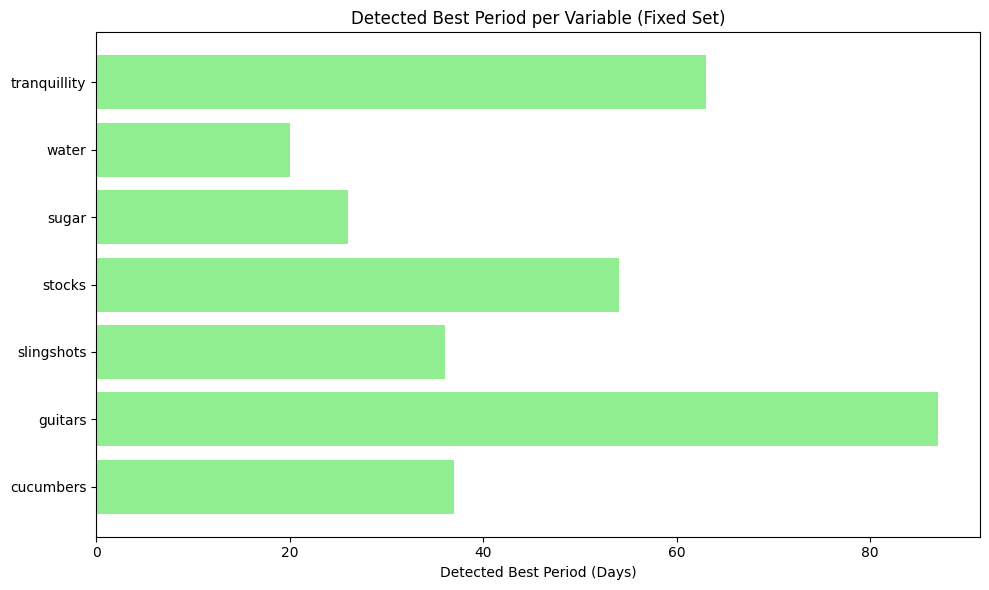

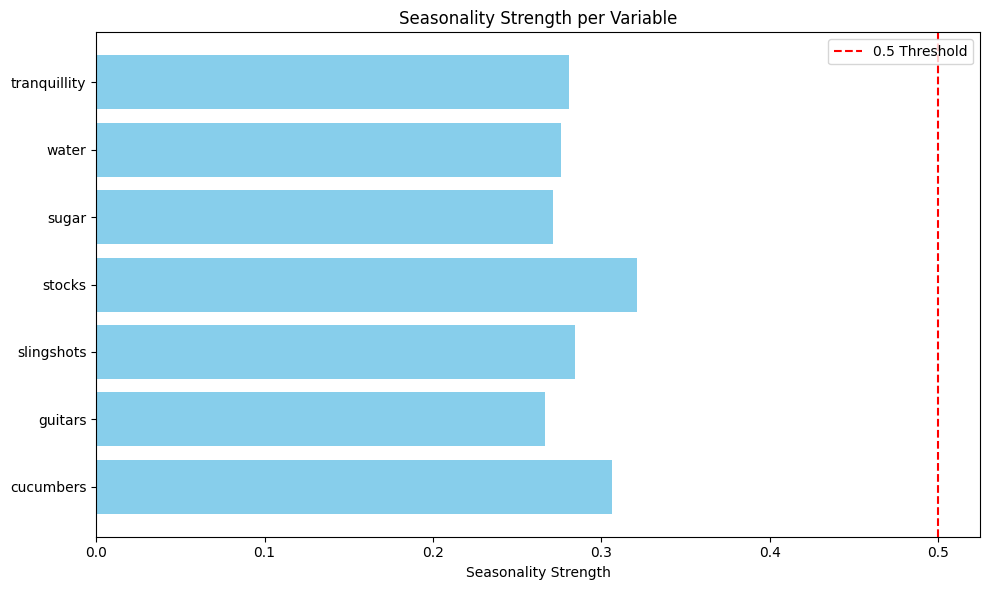

In [420]:
# Fixed periods to test
periods = periods_to_test[col]
best_periods= {}
seasonality_strengths = {}
# Analyze seasonality on transformed data
for col in df.columns:
    if col == 'day':
        continue
    print(f"\nAnalyzing {col}...")
    series = pd.Series(detrended_df[col]).dropna()
    
    # Again get the periods for this column safely
    periods_for_col = list(periods_to_test.get(col, []))
    
    if not periods_for_col:
        print(f"No candidate periods found for {col}. Skipping.")
        continue
    
    best_period, best_strength = best_fixed_period(series, periods_for_col)
    
    if best_period is None:
        print(f"No good period found for {col}. Skipping.")
        continue
    
    best_periods[col] = best_period
    seasonality_strengths[col] = best_strength
    print(f"Best Period: {best_period} days (Strength: {best_strength:.3f})")

# --- Plot Results ---

plt.figure(figsize=(10, 6))
plt.barh(list(best_periods.keys()), list(best_periods.values()), color='lightgreen')
plt.xlabel("Detected Best Period (Days)")
plt.title("Detected Best Period per Variable (Fixed Set)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(list(seasonality_strengths.keys()), list(seasonality_strengths.values()), color='skyblue')
plt.xlabel("Seasonality Strength")
plt.title("Seasonality Strength per Variable")
plt.axvline(0.5, color='red', linestyle='--', label='0.5 Threshold')
plt.legend()
plt.tight_layout()
plt.show()


Seasonal strength of Guerrero Box-cox transformed and ma detrended data

In [421]:
# Heuristic-based window selection + detrending
detrended_df = pd.DataFrame(index=df_boxcox_guerrero.index)
optimal_windows = {}

# Apply to each transformed series
for col in df.columns:
    if col == 'day':
        continue
    print(f"Detrending {col}...")
    series = df_boxcox_guerrero[col].dropna()
    window_range = range(5, 51, 2)  # Try odd window sizes from 5 to 50
 
    best_w, score_table = compute_optimal_window(series, window_range)
    if best_w is None:
        print(f"No valid window found for {col}.")
        continue
 
    trend = series.rolling(window=best_w, center=True, min_periods=1).mean()
    detrended = (series - trend).dropna()
 
    detrended_df[col] = detrended
    optimal_windows[col] = best_w
    print(f"Best window size for {col}: {best_w}")

Detrending cucumbers...
Best window size for cucumbers: 23
Detrending guitars...
Best window size for guitars: 25
Detrending slingshots...
Best window size for slingshots: 25
Detrending stocks...
Best window size for stocks: 49
Detrending sugar...
Best window size for sugar: 37
Detrending water...
Best window size for water: 11
Detrending tranquillity...
Best window size for tranquillity: 25


<Figure size 800x400 with 0 Axes>

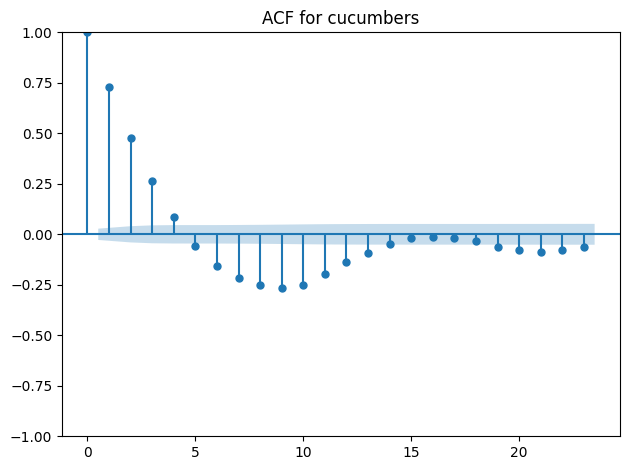

Box–Ljung Test for cucumbers (10 lags):
        lb_stat  lb_pvalue
23  5910.717647        0.0

Instrument: cucumbers
Significant integer periods (no duplicates): [14 16 17 18 19 20 25 27 32 37 38 40]
Detailed significant peaks:
  Period = 40.24 days, Power = 0.0066, FAP = 0.00492
  Period = 37.82 days, Power = 0.0077, FAP = 0.00031
  Period = 36.55 days, Power = 0.0076, FAP = 0.00042
  Period = 32.08 days, Power = 0.0071, FAP = 0.00150
  Period = 31.74 days, Power = 0.0076, FAP = 0.00045
  Period = 26.61 days, Power = 0.0127, FAP = 0.00000
  Period = 24.54 days, Power = 0.0101, FAP = 0.00000
  Period = 19.96 days, Power = 0.0072, FAP = 0.00115
  Period = 18.94 days, Power = 0.0149, FAP = 0.00000
  Period = 18.24 days, Power = 0.0064, FAP = 0.00805
  Period = 16.60 days, Power = 0.0090, FAP = 0.00001
  Period = 15.69 days, Power = 0.0072, FAP = 0.00121
  Period = 14.47 days, Power = 0.0063, FAP = 0.00950
  Period = 14.34 days, Power = 0.0078, FAP = 0.00024
  Period = 13.89 days, Power =

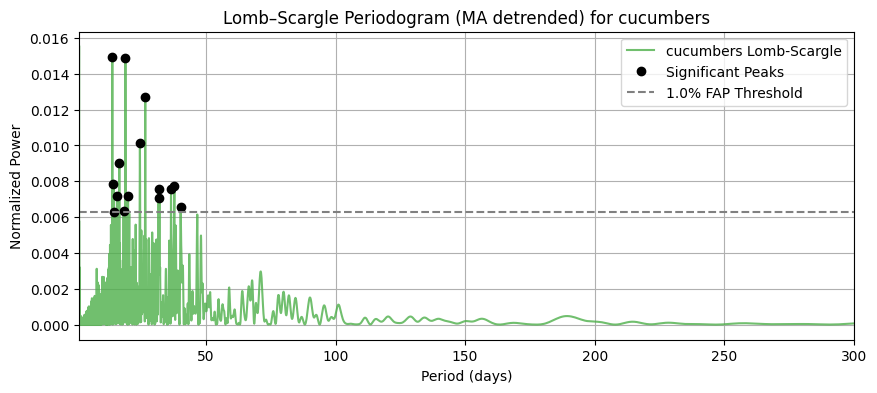

<Figure size 800x400 with 0 Axes>

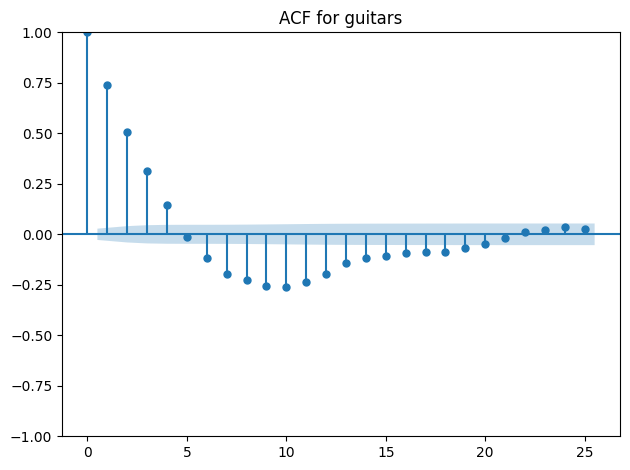

Box–Ljung Test for guitars (10 lags):
        lb_stat  lb_pvalue
25  6536.135501        0.0

Instrument: guitars
Significant integer periods (no duplicates): [13 15 18 20 21 22 23 27 30 31 32 37 38]
Detailed significant peaks:
  Period = 37.79 days, Power = 0.0068, FAP = 0.00302
  Period = 36.94 days, Power = 0.0069, FAP = 0.00200
  Period = 31.97 days, Power = 0.0216, FAP = 0.00000
  Period = 31.36 days, Power = 0.0097, FAP = 0.00000
  Period = 29.54 days, Power = 0.0073, FAP = 0.00077
  Period = 26.87 days, Power = 0.0069, FAP = 0.00249
  Period = 26.51 days, Power = 0.0124, FAP = 0.00000
  Period = 23.10 days, Power = 0.0079, FAP = 0.00019
  Period = 22.93 days, Power = 0.0085, FAP = 0.00005
  Period = 22.11 days, Power = 0.0072, FAP = 0.00097
  Period = 20.85 days, Power = 0.0101, FAP = 0.00000
  Period = 20.73 days, Power = 0.0113, FAP = 0.00000
  Period = 20.51 days, Power = 0.0067, FAP = 0.00343
  Period = 20.26 days, Power = 0.0092, FAP = 0.00001
  Period = 18.27 days, Power = 

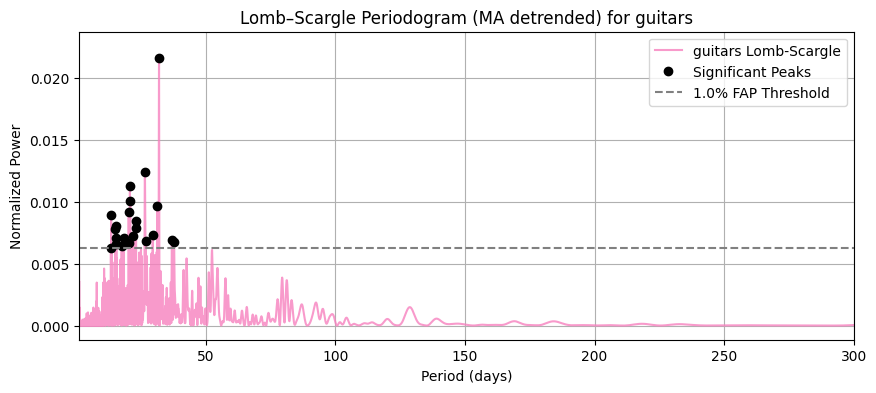

<Figure size 800x400 with 0 Axes>

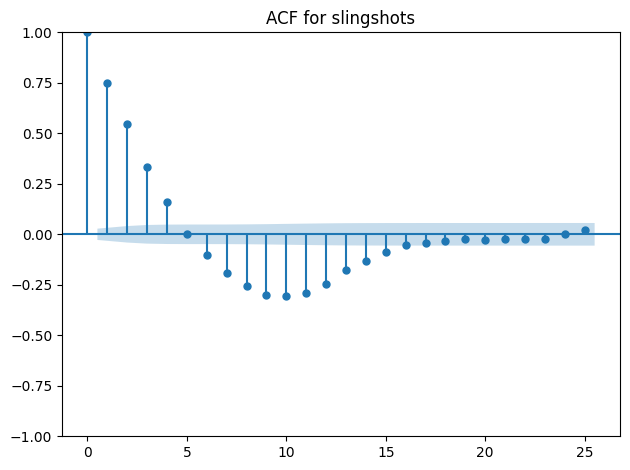

Box–Ljung Test for slingshots (10 lags):
        lb_stat  lb_pvalue
25  7372.733825        0.0

Instrument: slingshots
Significant integer periods (no duplicates): [15 16 17 18 20 22 23 25 26 27 29 30 31 32 43]
Detailed significant peaks:
  Period = 42.62 days, Power = 0.0071, FAP = 0.00150
  Period = 31.95 days, Power = 0.0150, FAP = 0.00000
  Period = 31.36 days, Power = 0.0085, FAP = 0.00005
  Period = 30.33 days, Power = 0.0085, FAP = 0.00004
  Period = 29.81 days, Power = 0.0072, FAP = 0.00117
  Period = 29.07 days, Power = 0.0098, FAP = 0.00000
  Period = 26.69 days, Power = 0.0067, FAP = 0.00329
  Period = 26.36 days, Power = 0.0163, FAP = 0.00000
  Period = 24.93 days, Power = 0.0153, FAP = 0.00000
  Period = 24.60 days, Power = 0.0109, FAP = 0.00000
  Period = 23.32 days, Power = 0.0064, FAP = 0.00717
  Period = 23.11 days, Power = 0.0080, FAP = 0.00017
  Period = 22.51 days, Power = 0.0071, FAP = 0.00144
  Period = 21.77 days, Power = 0.0082, FAP = 0.00010
  Period = 20.24 da

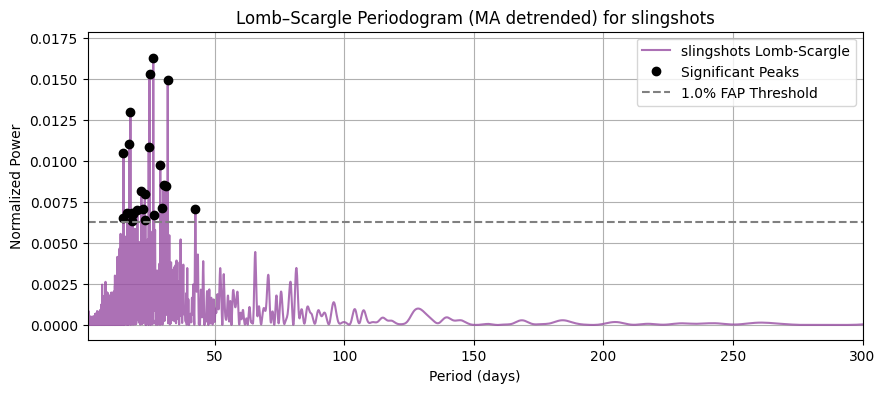

<Figure size 800x400 with 0 Axes>

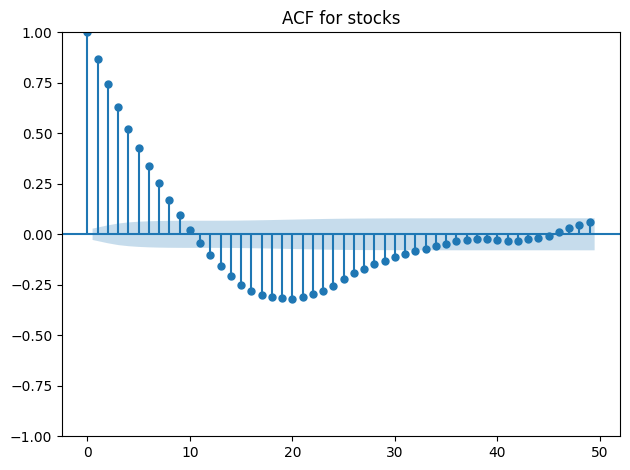

Box–Ljung Test for stocks (10 lags):
         lb_stat  lb_pvalue
49  17269.293406        0.0

Instrument: stocks
Significant integer periods (no duplicates): [ 26  27  29  30  31  34  37  38  39  40  42  44  46  47  48  49  52  53
  54  56  58  59  68  70  71  76  91  94  99 105 121]
Detailed significant peaks:
  Period = 120.51 days, Power = 0.0070, FAP = 0.00194
  Period = 105.47 days, Power = 0.0086, FAP = 0.00004
  Period = 98.67 days, Power = 0.0068, FAP = 0.00294
  Period = 93.94 days, Power = 0.0075, FAP = 0.00049
  Period = 91.49 days, Power = 0.0155, FAP = 0.00000
  Period = 76.02 days, Power = 0.0085, FAP = 0.00005
  Period = 71.47 days, Power = 0.0149, FAP = 0.00000
  Period = 70.04 days, Power = 0.0078, FAP = 0.00024
  Period = 68.47 days, Power = 0.0139, FAP = 0.00000
  Period = 59.35 days, Power = 0.0085, FAP = 0.00005
  Period = 58.02 days, Power = 0.0280, FAP = 0.00000
  Period = 55.77 days, Power = 0.0239, FAP = 0.00000
  Period = 54.41 days, Power = 0.0067, FAP = 0.00

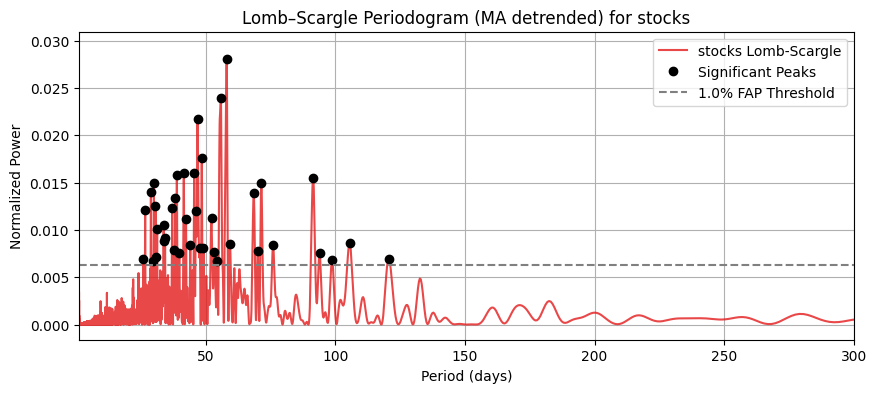

<Figure size 800x400 with 0 Axes>

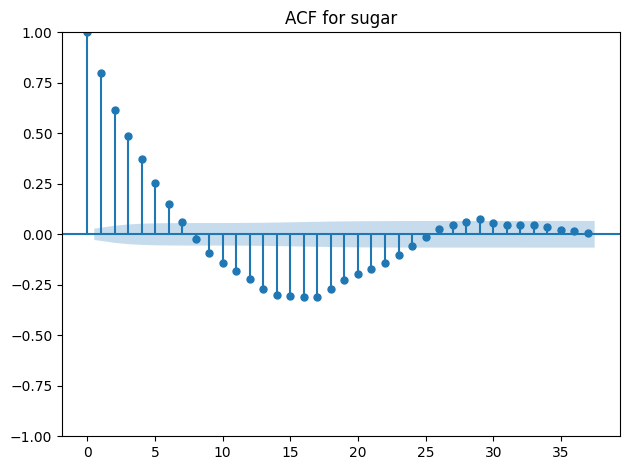

Box–Ljung Test for sugar (10 lags):
         lb_stat  lb_pvalue
37  11246.688137        0.0

Instrument: sugar
Significant integer periods (no duplicates): [22 23 25 26 27 29 30 31 32 33 35 36 37 38 47 48 49 54 79 84]
Detailed significant peaks:
  Period = 83.67 days, Power = 0.0068, FAP = 0.00303
  Period = 79.08 days, Power = 0.0067, FAP = 0.00329
  Period = 53.52 days, Power = 0.0087, FAP = 0.00003
  Period = 49.22 days, Power = 0.0116, FAP = 0.00000
  Period = 48.01 days, Power = 0.0213, FAP = 0.00000
  Period = 46.68 days, Power = 0.0080, FAP = 0.00016
  Period = 37.85 days, Power = 0.0066, FAP = 0.00500
  Period = 37.22 days, Power = 0.0114, FAP = 0.00000
  Period = 36.50 days, Power = 0.0081, FAP = 0.00011
  Period = 35.06 days, Power = 0.0174, FAP = 0.00000
  Period = 34.59 days, Power = 0.0253, FAP = 0.00000
  Period = 33.32 days, Power = 0.0071, FAP = 0.00129
  Period = 32.59 days, Power = 0.0089, FAP = 0.00002
  Period = 31.99 days, Power = 0.0245, FAP = 0.00000
  Period = 3

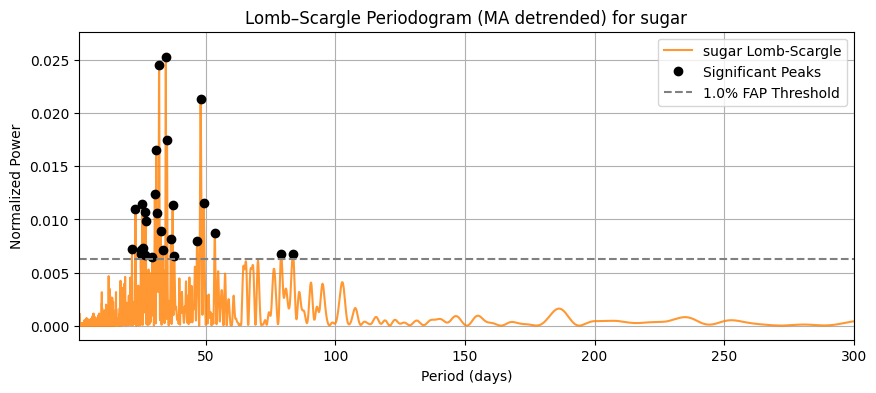

<Figure size 800x400 with 0 Axes>

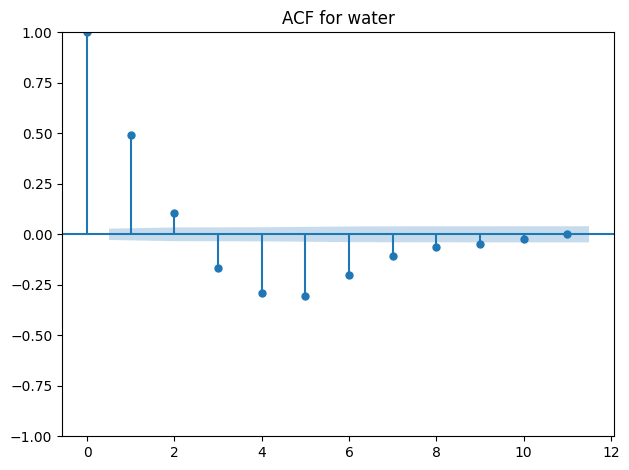

Box–Ljung Test for water (10 lags):
        lb_stat  lb_pvalue
11  2539.320228        0.0

Instrument: water
Significant integer periods (no duplicates): [ 8 13 14 15]
Detailed significant peaks:
  Period = 15.40 days, Power = 0.0077, FAP = 0.00034
  Period = 15.32 days, Power = 0.0074, FAP = 0.00066
  Period = 15.25 days, Power = 0.0065, FAP = 0.00613
  Period = 13.54 days, Power = 0.0078, FAP = 0.00024
  Period = 13.35 days, Power = 0.0073, FAP = 0.00082
  Period = 8.18 days, Power = 0.0074, FAP = 0.00075
  Period = 1.14 days, Power = 0.0076, FAP = 0.00045
  Period = 1.11 days, Power = 0.0065, FAP = 0.00649
  Period = 1.08 days, Power = 0.0076, FAP = 0.00044
  Period = 1.08 days, Power = 0.0081, FAP = 0.00012
  Period = 1.07 days, Power = 0.0068, FAP = 0.00317
  Period = 1.07 days, Power = 0.0077, FAP = 0.00032
  Period = 1.07 days, Power = 0.0080, FAP = 0.00016




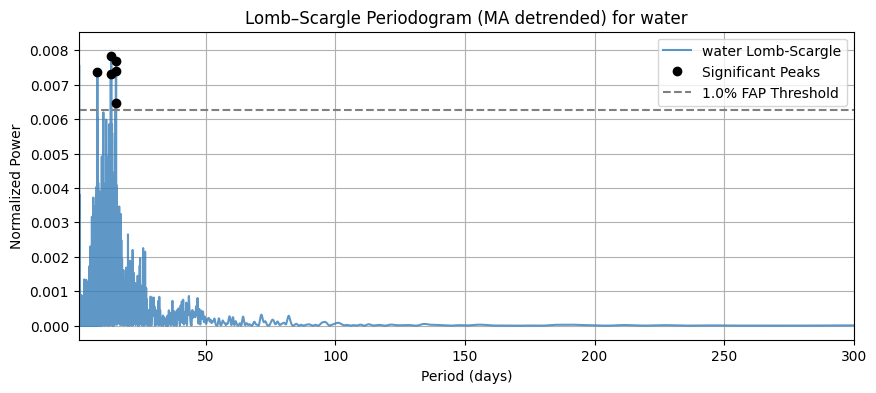

<Figure size 800x400 with 0 Axes>

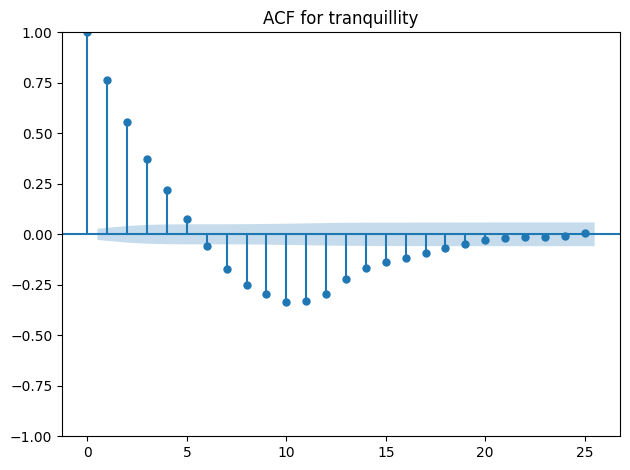

Box–Ljung Test for tranquillity (10 lags):
        lb_stat  lb_pvalue
25  8344.435228        0.0

Instrument: tranquillity
Significant integer periods (no duplicates): [14 15 16 17 18 19 20 21 22 23 24 25 27 29 30 32 34 35 36 37 38 46 48 50]
Detailed significant peaks:
  Period = 50.17 days, Power = 0.0084, FAP = 0.00006
  Period = 49.51 days, Power = 0.0064, FAP = 0.00687
  Period = 47.55 days, Power = 0.0079, FAP = 0.00018
  Period = 45.51 days, Power = 0.0066, FAP = 0.00461
  Period = 37.79 days, Power = 0.0082, FAP = 0.00009
  Period = 37.36 days, Power = 0.0073, FAP = 0.00077
  Period = 36.99 days, Power = 0.0078, FAP = 0.00026
  Period = 36.63 days, Power = 0.0103, FAP = 0.00000
  Period = 35.96 days, Power = 0.0063, FAP = 0.00954
  Period = 34.96 days, Power = 0.0095, FAP = 0.00000
  Period = 33.69 days, Power = 0.0070, FAP = 0.00158
  Period = 31.87 days, Power = 0.0127, FAP = 0.00000
  Period = 31.54 days, Power = 0.0118, FAP = 0.00000
  Period = 30.40 days, Power = 0.0168, FA

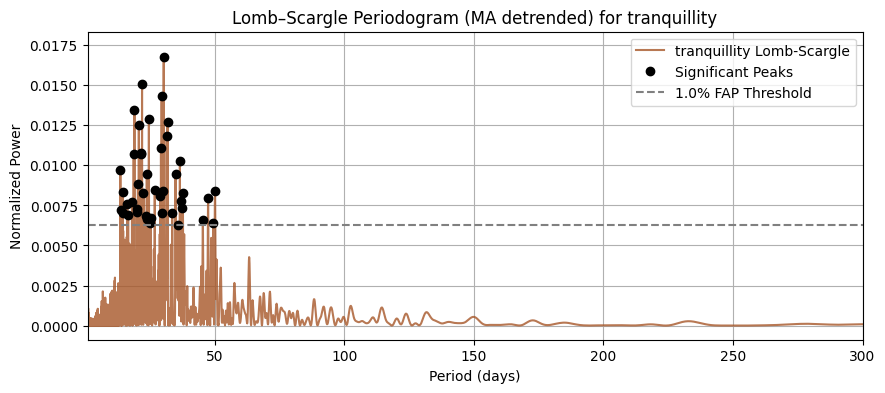

In [422]:
#Lomb Scargle
# Define the significance level for FAP filtering.
alpha = 0.01
periods_to_test = {}

# Loop over each instrument (all columns except 'day')
for col in df.columns:
    if col == 'day':
        continue
    
    # Extract the series and assign its plotting color.
    series = df_boxcox_guerrero[col].dropna()
    color = colours.get(col, 'black')
    
    # Moving-Average Detrending 
    window = optimal_windows[col]
    detrended = detrended_df[col]

    # Plot the Autocorrelation Function (ACF)
    plt.figure(figsize=(8, 4))
    plot_acf(detrended, lags=window )
    plt.title(f"ACF for {col}")
    plt.tight_layout()
    plt.show()
    
    # Perform the Box–Ljung test 
    # The test checks the null hypothesis that the series is independently distributed.
    lb_test = acorr_ljungbox(detrended, lags=[window ], return_df=True)
    print(f"Box–Ljung Test for {col} (10 lags):\n{lb_test}\n")
    
    # Numeric time & zero-mean adjustment 
    t = np.arange(len(detrended))
    y = detrended.values
    y -= np.mean(y)

    # Lomb–Scargle Periodogram Calculation
    min_p, max_p = 1, 2500  # period limits in days
    ls = LombScargle(t, y)
    frequency, power = ls.autopower(
        minimum_frequency=1/max_p,
        maximum_frequency=1/min_p,
        samples_per_peak=10
    )
    period = 1.0 / frequency

    # Detect local peaks in the periodogram 
    peak_indices, _ = find_peaks(power)
    peak_freqs = frequency[peak_indices]
    peak_periods = 1.0 / peak_freqs
    peak_powers = power[peak_indices]

    # Compute False Alarm Probability (FAP) for each peak
    peak_faps = ls.false_alarm_probability(peak_powers)

    # Filter peaks by significance level α < 0.01 
    significant = peak_faps < alpha
    sig_periods = peak_periods[significant]
    sig_powers = peak_powers[significant]
    sig_faps = peak_faps[significant]

    # Round significant periods to integers, remove duplicates, and keep only values > 1
    rounded_periods = np.round(sig_periods).astype(int)
    unique_rounded_periods = np.unique(rounded_periods[rounded_periods > 1])

    # Save the candidate periods as a set into the dictionary.
    periods_to_test[col] = set(unique_rounded_periods)
    
    # Output the candidate seasonal periods 
    print(f"Instrument: {col}")
    print("Significant integer periods (no duplicates):", unique_rounded_periods)
    print("Detailed significant peaks:")
    for p, powr, fap in zip(sig_periods, sig_powers, sig_faps):
        print(f"  Period = {p:.2f} days, Power = {powr:.4f}, FAP = {fap:.5f}")
    print("\n")
    
    # Plot periodogram with significant peaks marked as red dots 
    fap_threshold = ls.false_alarm_level(alpha)
    plt.figure(figsize=(10, 4))
    plt.plot(period, power, label=f"{col} Lomb-Scargle", alpha=0.8, color=color)
    # Plot significant peaks as red dots.
    mask = sig_periods > 1.8  # Use a small buffer to avoid floating-point precision issues
    plt.plot(sig_periods[mask], sig_powers[mask], 'ko', label='Significant Peaks')
    plt.axhline(fap_threshold, linestyle="--", color="gray", 
                label=f"{alpha*100:.1f}% FAP Threshold")
    plt.xlim(1, 300)
    plt.xlabel("Period (days)")
    plt.ylabel("Normalized Power")
    plt.title(f"Lomb–Scargle Periodogram (MA detrended) for {col}")
    plt.legend()
    plt.grid(True)
    plt.show()




Analyzing cucumbers...
Tested Period 32 days: Strength = 0.275
Tested Period 37 days: Strength = 0.260
Tested Period 38 days: Strength = 0.271
Tested Period 40 days: Strength = 0.274
Tested Period 14 days: Strength = 0.267
Tested Period 16 days: Strength = 0.255
Tested Period 17 days: Strength = 0.262
Tested Period 18 days: Strength = 0.246
Tested Period 19 days: Strength = 0.260
Tested Period 20 days: Strength = 0.239
Tested Period 25 days: Strength = 0.261
Tested Period 27 days: Strength = 0.295
Best Period: 27 days (Strength: 0.295)

Analyzing guitars...
Tested Period 32 days: Strength = 0.231
Tested Period 37 days: Strength = 0.184
Tested Period 38 days: Strength = 0.197
Tested Period 13 days: Strength = 0.198
Tested Period 15 days: Strength = 0.229
Tested Period 18 days: Strength = 0.211
Tested Period 20 days: Strength = 0.239
Tested Period 21 days: Strength = 0.216
Tested Period 22 days: Strength = 0.211
Tested Period 23 days: Strength = 0.210
Tested Period 27 days: Strength = 0

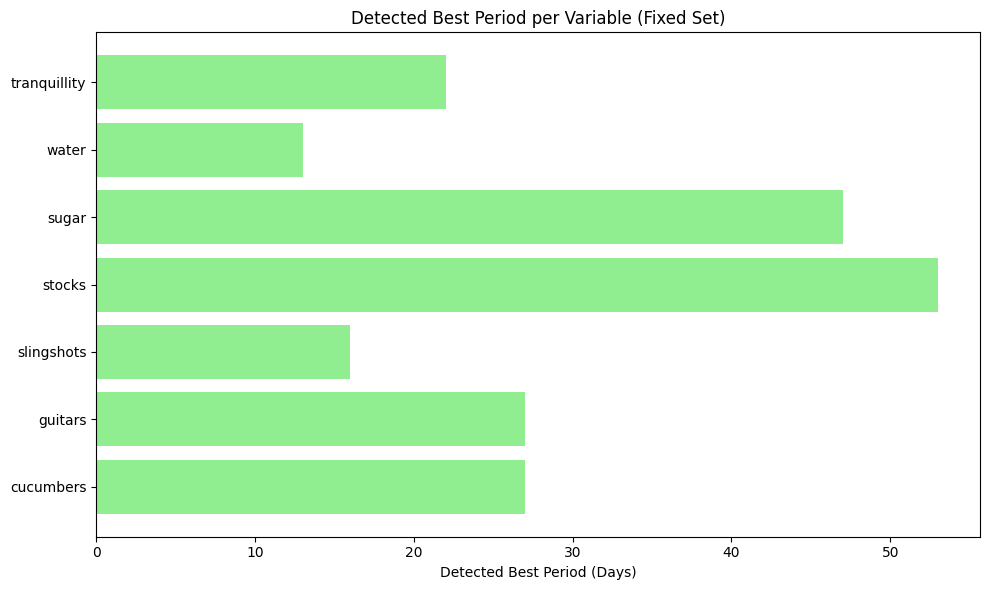

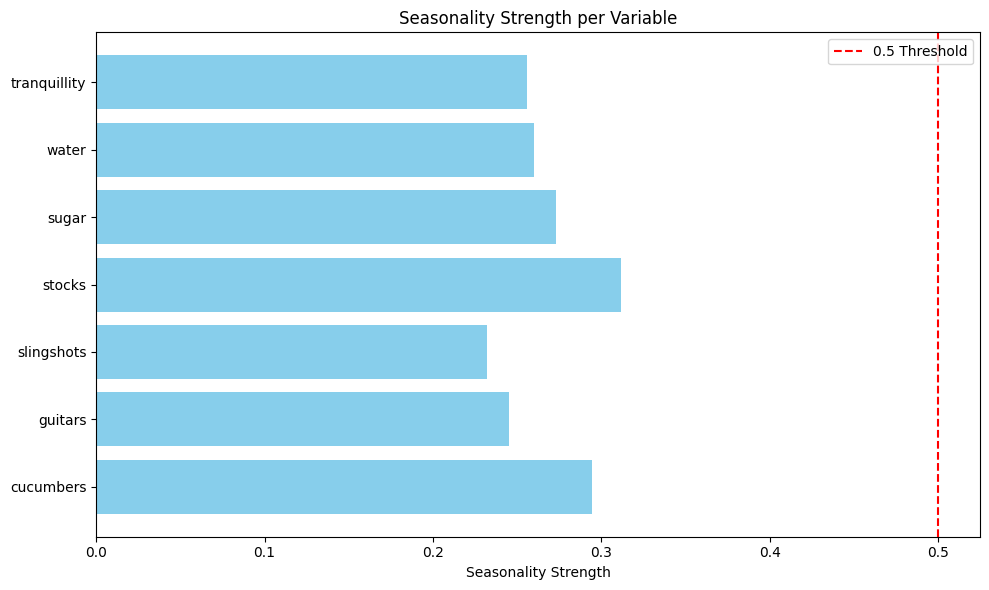

In [423]:
# Analyze seasonality on transformed data
for col in df.columns:
    if col == 'day':
        continue
    print(f"\nAnalyzing {col}...")
    series = pd.Series(detrended_df[col]).dropna()
    
    # Again get the periods for this column safely
    periods_for_col = list(periods_to_test.get(col, []))
    
    if not periods_for_col:
        print(f"No candidate periods found for {col}. Skipping.")
        continue
    
    best_period, best_strength = best_fixed_period(series, periods_for_col)
    
    if best_period is None:
        print(f"No good period found for {col}. Skipping.")
        continue
    
    best_periods[col] = best_period
    seasonality_strengths[col] = best_strength
    print(f"Best Period: {best_period} days (Strength: {best_strength:.3f})")

# --- Plot Results ---

plt.figure(figsize=(10, 6))
plt.barh(list(best_periods.keys()), list(best_periods.values()), color='lightgreen')
plt.xlabel("Detected Best Period (Days)")
plt.title("Detected Best Period per Variable (Fixed Set)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(list(seasonality_strengths.keys()), list(seasonality_strengths.values()), color='skyblue')
plt.xlabel("Seasonality Strength")
plt.title("Seasonality Strength per Variable")
plt.axvline(0.5, color='red', linestyle='--', label='0.5 Threshold')
plt.legend()
plt.tight_layout()
plt.show()


Seasonal strength of mle Box-cox transformed and ma detrended data

In [424]:
# Heuristic-based window selection + detrending
detrended_df = pd.DataFrame(index=df_boxcox_mle.index)
optimal_windows = {}
 
# Apply to each transformed series
for col in df.columns:
    if col == 'day':
        continue
    print(f"Detrending {col}...")
    series = df_boxcox_mle[col].dropna()
    window_range = range(5, 51, 2)  # Try odd window sizes from 5 to 50
 
    best_w, score_table = compute_optimal_window(series, window_range)
    if best_w is None:
        print(f"No valid window found for {col}.")
        continue
 
    trend = series.rolling(window=best_w, center=True, min_periods=1).mean()
    detrended = (series - trend).dropna()
 
    detrended_df[col] = detrended
    optimal_windows[col] = best_w
    print(f"Best window size for {col}: {best_w}")

Detrending cucumbers...
Best window size for cucumbers: 23
Detrending guitars...
Best window size for guitars: 23
Detrending slingshots...
Best window size for slingshots: 49
Detrending stocks...
Best window size for stocks: 49
Detrending sugar...
Best window size for sugar: 29
Detrending water...
Best window size for water: 15
Detrending tranquillity...
Best window size for tranquillity: 25


<Figure size 800x400 with 0 Axes>

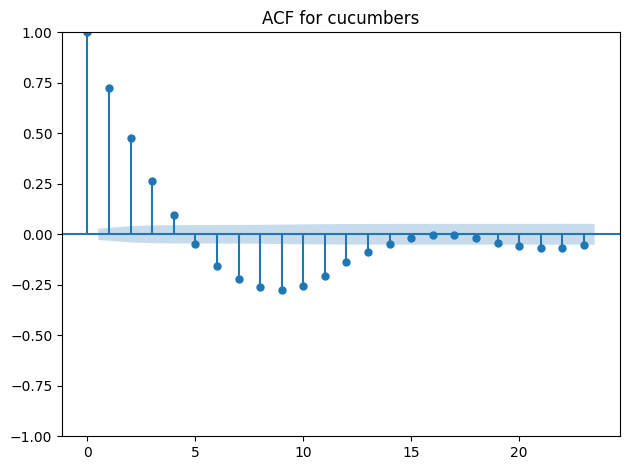

Box–Ljung Test for cucumbers (10 lags):
        lb_stat  lb_pvalue
23  5920.877856        0.0

Instrument: cucumbers
Significant integer periods (no duplicates): [14 16 17 18 19 20 25 27 32 36 37 38]
Detailed significant peaks:
  Period = 37.85 days, Power = 0.0069, FAP = 0.00216
  Period = 36.52 days, Power = 0.0097, FAP = 0.00000
  Period = 35.83 days, Power = 0.0067, FAP = 0.00353
  Period = 31.74 days, Power = 0.0066, FAP = 0.00406
  Period = 26.61 days, Power = 0.0126, FAP = 0.00000
  Period = 25.11 days, Power = 0.0068, FAP = 0.00274
  Period = 24.53 days, Power = 0.0098, FAP = 0.00000
  Period = 19.96 days, Power = 0.0100, FAP = 0.00000
  Period = 19.34 days, Power = 0.0070, FAP = 0.00157
  Period = 18.94 days, Power = 0.0120, FAP = 0.00000
  Period = 18.25 days, Power = 0.0080, FAP = 0.00014
  Period = 16.60 days, Power = 0.0093, FAP = 0.00001
  Period = 15.69 days, Power = 0.0064, FAP = 0.00751
  Period = 14.34 days, Power = 0.0090, FAP = 0.00001
  Period = 13.89 days, Power =

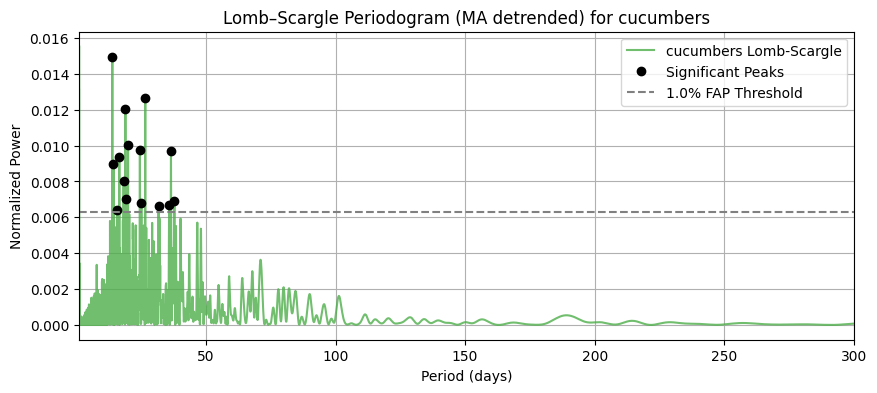

<Figure size 800x400 with 0 Axes>

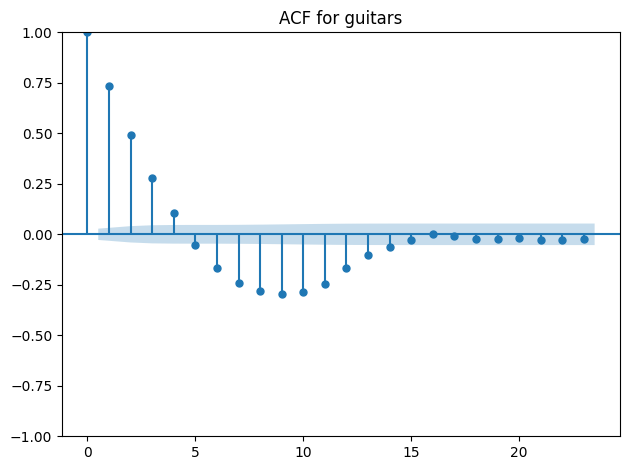

Box–Ljung Test for guitars (10 lags):
        lb_stat  lb_pvalue
23  6455.042757        0.0

Instrument: guitars
Significant integer periods (no duplicates): [13 14 15 17 18 20 21 23 27 29 31 32 59]
Detailed significant peaks:
  Period = 58.71 days, Power = 0.0065, FAP = 0.00542
  Period = 31.99 days, Power = 0.0163, FAP = 0.00000
  Period = 31.36 days, Power = 0.0078, FAP = 0.00024
  Period = 30.98 days, Power = 0.0066, FAP = 0.00411
  Period = 28.76 days, Power = 0.0078, FAP = 0.00025
  Period = 26.86 days, Power = 0.0086, FAP = 0.00004
  Period = 26.51 days, Power = 0.0132, FAP = 0.00000
  Period = 23.07 days, Power = 0.0111, FAP = 0.00000
  Period = 22.88 days, Power = 0.0117, FAP = 0.00000
  Period = 21.49 days, Power = 0.0081, FAP = 0.00012
  Period = 20.84 days, Power = 0.0132, FAP = 0.00000
  Period = 20.26 days, Power = 0.0071, FAP = 0.00155
  Period = 19.91 days, Power = 0.0072, FAP = 0.00116
  Period = 18.27 days, Power = 0.0101, FAP = 0.00000
  Period = 18.04 days, Power = 

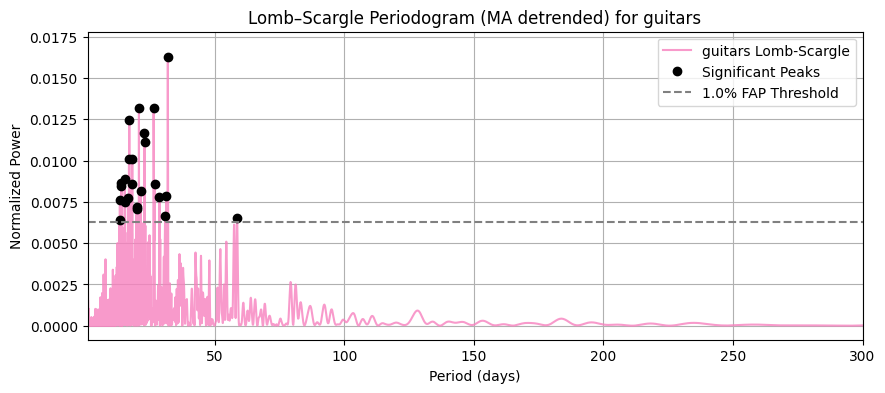

<Figure size 800x400 with 0 Axes>

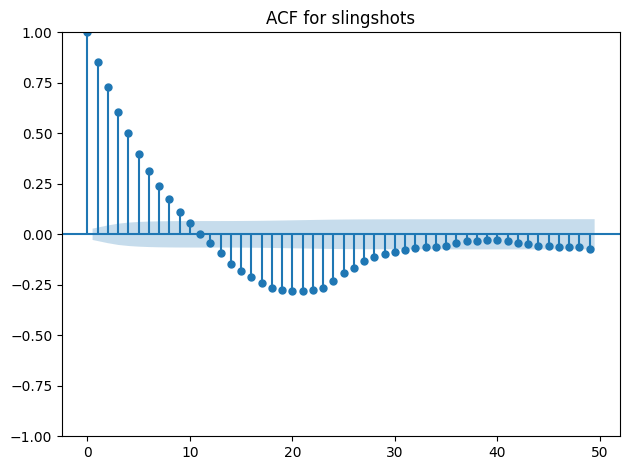

Box–Ljung Test for slingshots (10 lags):
         lb_stat  lb_pvalue
49  15158.633855        0.0

Instrument: slingshots
Significant integer periods (no duplicates): [ 25  26  29  30  31  32  34  35  36  37  38  39  42  43  44  45  46  48
  49  50  52  54  56  58  59  61  66  67  70  76  79  82  96 104]
Detailed significant peaks:
  Period = 103.90 days, Power = 0.0089, FAP = 0.00002
  Period = 95.78 days, Power = 0.0084, FAP = 0.00005
  Period = 81.59 days, Power = 0.0259, FAP = 0.00000
  Period = 79.34 days, Power = 0.0200, FAP = 0.00000
  Period = 75.55 days, Power = 0.0137, FAP = 0.00000
  Period = 70.14 days, Power = 0.0085, FAP = 0.00005
  Period = 66.98 days, Power = 0.0098, FAP = 0.00000
  Period = 65.63 days, Power = 0.0207, FAP = 0.00000
  Period = 60.82 days, Power = 0.0084, FAP = 0.00006
  Period = 58.85 days, Power = 0.0168, FAP = 0.00000
  Period = 57.61 days, Power = 0.0102, FAP = 0.00000
  Period = 56.09 days, Power = 0.0070, FAP = 0.00164
  Period = 53.52 days, Power =

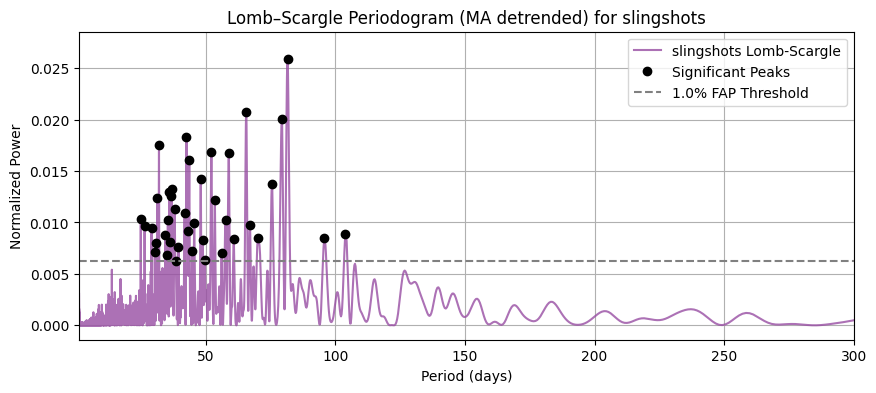

<Figure size 800x400 with 0 Axes>

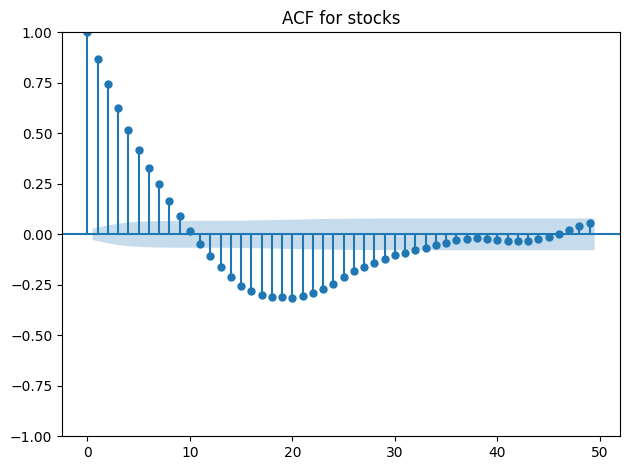

Box–Ljung Test for stocks (10 lags):
         lb_stat  lb_pvalue
49  16989.356538        0.0

Instrument: stocks
Significant integer periods (no duplicates): [ 26  27  29  30  31  32  34  37  38  39  40  42  44  46  47  48  49  52
  53  54  55  56  58  59  68  70  71  76  91  94 105 121]
Detailed significant peaks:
  Period = 120.51 days, Power = 0.0073, FAP = 0.00096
  Period = 105.47 days, Power = 0.0087, FAP = 0.00003
  Period = 93.94 days, Power = 0.0070, FAP = 0.00178
  Period = 91.49 days, Power = 0.0139, FAP = 0.00000
  Period = 76.02 days, Power = 0.0083, FAP = 0.00008
  Period = 71.47 days, Power = 0.0135, FAP = 0.00000
  Period = 69.94 days, Power = 0.0078, FAP = 0.00024
  Period = 68.47 days, Power = 0.0132, FAP = 0.00000
  Period = 59.28 days, Power = 0.0104, FAP = 0.00000
  Period = 57.95 days, Power = 0.0319, FAP = 0.00000
  Period = 55.71 days, Power = 0.0199, FAP = 0.00000
  Period = 55.39 days, Power = 0.0202, FAP = 0.00000
  Period = 54.35 days, Power = 0.0082, FAP = 

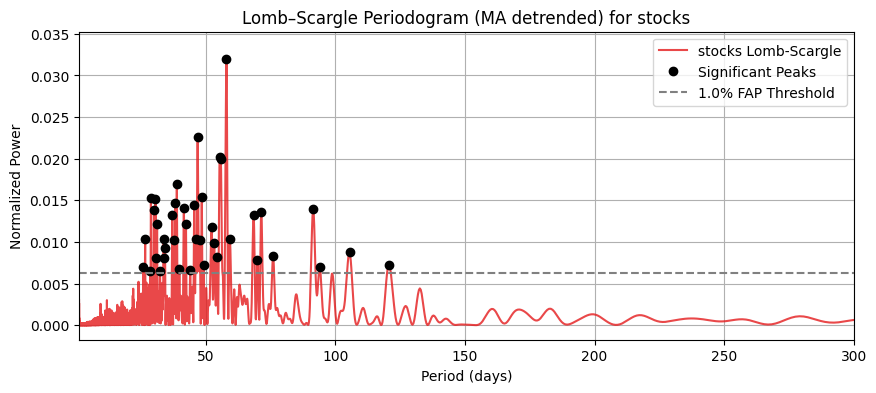

<Figure size 800x400 with 0 Axes>

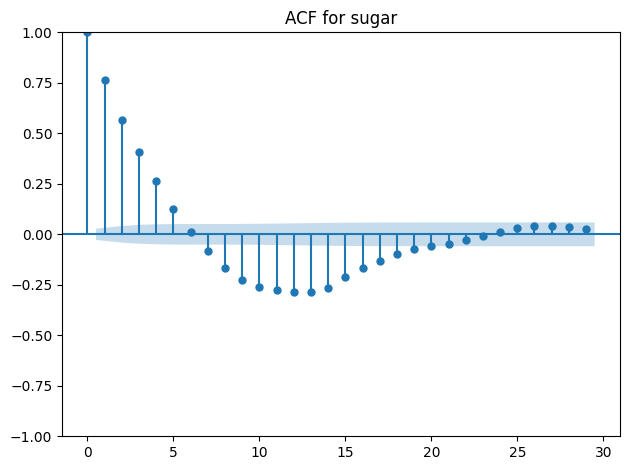

Box–Ljung Test for sugar (10 lags):
        lb_stat  lb_pvalue
29  8510.044104        0.0

Instrument: sugar
Significant integer periods (no duplicates): [17 18 19 21 22 23 25 26 27 28 30 31 32 35 36 37 48 53]
Detailed significant peaks:
  Period = 53.46 days, Power = 0.0076, FAP = 0.00045
  Period = 48.01 days, Power = 0.0127, FAP = 0.00000
  Period = 37.22 days, Power = 0.0104, FAP = 0.00000
  Period = 36.50 days, Power = 0.0063, FAP = 0.00936
  Period = 35.04 days, Power = 0.0093, FAP = 0.00001
  Period = 34.59 days, Power = 0.0168, FAP = 0.00000
  Period = 31.97 days, Power = 0.0159, FAP = 0.00000
  Period = 31.28 days, Power = 0.0071, FAP = 0.00127
  Period = 30.86 days, Power = 0.0135, FAP = 0.00000
  Period = 30.35 days, Power = 0.0075, FAP = 0.00053
  Period = 28.07 days, Power = 0.0072, FAP = 0.00120
  Period = 27.91 days, Power = 0.0078, FAP = 0.00027
  Period = 27.67 days, Power = 0.0065, FAP = 0.00605
  Period = 26.87 days, Power = 0.0096, FAP = 0.00000
  Period = 26.68 day

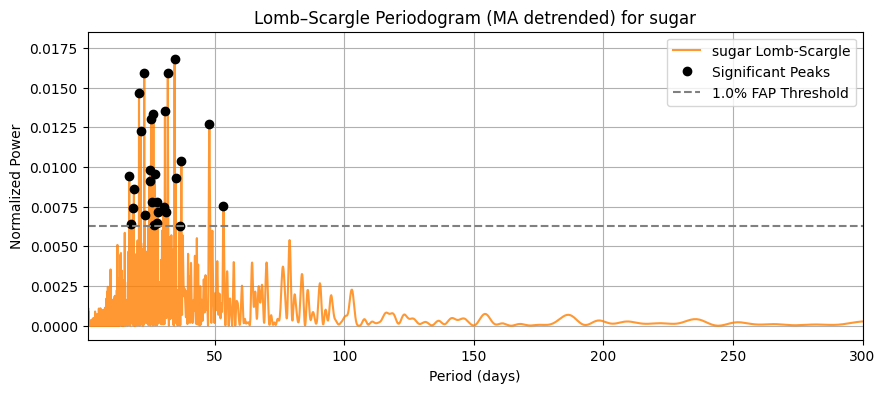

<Figure size 800x400 with 0 Axes>

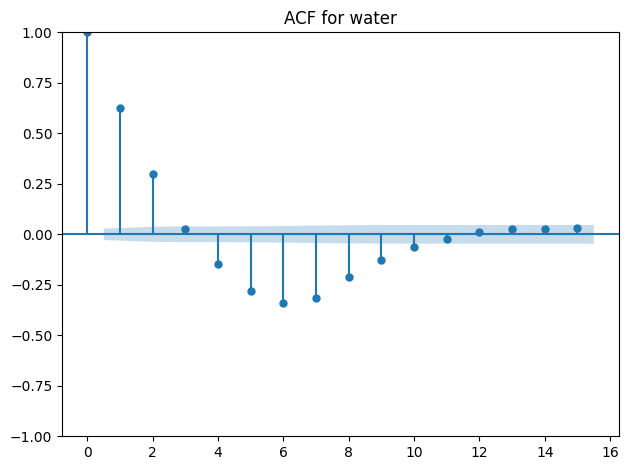

Box–Ljung Test for water (10 lags):
        lb_stat  lb_pvalue
15  4233.295741        0.0

Instrument: water
Significant integer periods (no duplicates): [10 12 13 14 15 20]
Detailed significant peaks:
  Period = 19.99 days, Power = 0.0071, FAP = 0.00124
  Period = 15.40 days, Power = 0.0071, FAP = 0.00139
  Period = 15.32 days, Power = 0.0078, FAP = 0.00028
  Period = 15.25 days, Power = 0.0067, FAP = 0.00360
  Period = 14.98 days, Power = 0.0067, FAP = 0.00344
  Period = 14.59 days, Power = 0.0081, FAP = 0.00011
  Period = 13.88 days, Power = 0.0079, FAP = 0.00023
  Period = 13.82 days, Power = 0.0084, FAP = 0.00007
  Period = 13.54 days, Power = 0.0080, FAP = 0.00015
  Period = 13.35 days, Power = 0.0080, FAP = 0.00016
  Period = 13.00 days, Power = 0.0104, FAP = 0.00000
  Period = 12.75 days, Power = 0.0087, FAP = 0.00003
  Period = 12.52 days, Power = 0.0072, FAP = 0.00112
  Period = 11.91 days, Power = 0.0073, FAP = 0.00084
  Period = 10.21 days, Power = 0.0071, FAP = 0.00150
  P

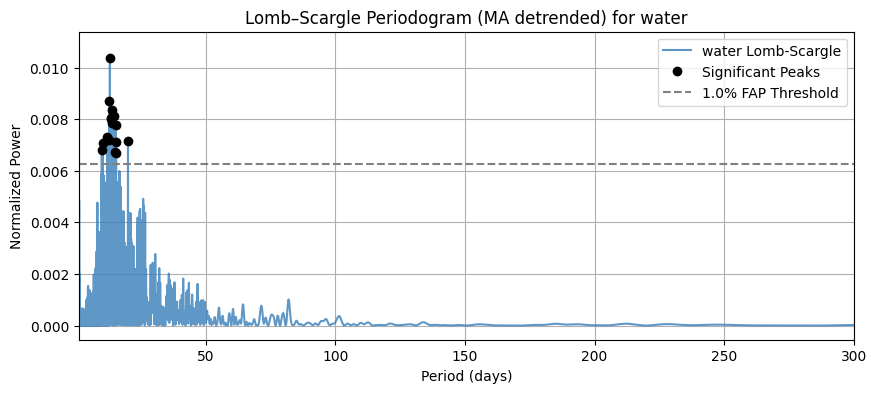

<Figure size 800x400 with 0 Axes>

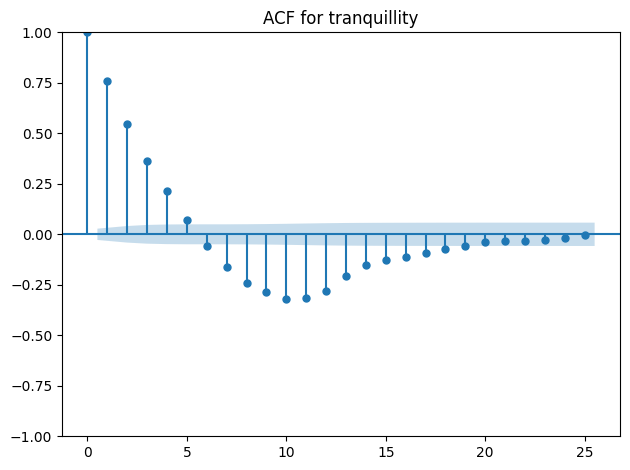

Box–Ljung Test for tranquillity (10 lags):
        lb_stat  lb_pvalue
25  7998.590655        0.0

Instrument: tranquillity
Significant integer periods (no duplicates): [14 15 16 18 19 20 21 22 23 24 25 27 29 30 32 34 35 36 37 38 45 47 50]
Detailed significant peaks:
  Period = 50.17 days, Power = 0.0087, FAP = 0.00003
  Period = 49.51 days, Power = 0.0072, FAP = 0.00120
  Period = 47.50 days, Power = 0.0085, FAP = 0.00005
  Period = 45.47 days, Power = 0.0077, FAP = 0.00035
  Period = 37.79 days, Power = 0.0087, FAP = 0.00003
  Period = 37.36 days, Power = 0.0079, FAP = 0.00019
  Period = 36.99 days, Power = 0.0083, FAP = 0.00007
  Period = 36.63 days, Power = 0.0096, FAP = 0.00000
  Period = 36.28 days, Power = 0.0065, FAP = 0.00550
  Period = 35.96 days, Power = 0.0064, FAP = 0.00759
  Period = 34.96 days, Power = 0.0095, FAP = 0.00000
  Period = 33.69 days, Power = 0.0074, FAP = 0.00067
  Period = 31.87 days, Power = 0.0121, FAP = 0.00000
  Period = 31.54 days, Power = 0.0125, FAP =

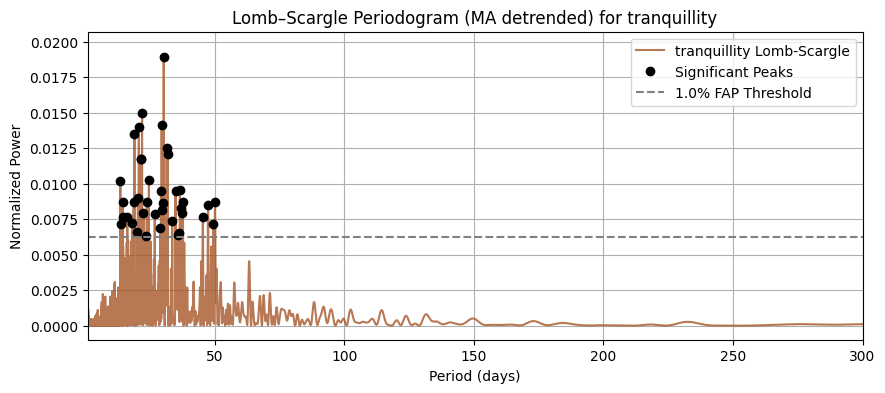

In [425]:
#Lomb Scargle
# Define the significance level for FAP filtering.
alpha = 0.01
periods_to_test = {}

# Loop over each instrument (all columns except 'day')
for col in df.columns:
    if col == 'day':
        continue
    
    # Extract the series and assign its plotting color.
    series = df_boxcox_guerrero[col].dropna()
    color = colours.get(col, 'black')
    
    # Moving-Average Detrending 
    window = optimal_windows[col]
    detrended = detrended_df[col]
    
    # Plot the Autocorrelation Function (ACF)
    plt.figure(figsize=(8, 4))
    plot_acf(detrended, lags=window )
    plt.title(f"ACF for {col}")
    plt.tight_layout()
    plt.show()
    
    # Perform the Box–Ljung test 
    # The test checks the null hypothesis that the series is independently distributed.
    lb_test = acorr_ljungbox(detrended, lags=[window ], return_df=True)
    print(f"Box–Ljung Test for {col} (10 lags):\n{lb_test}\n")
    
    # Numeric time & zero-mean adjustment 
    t = np.arange(len(detrended))
    y = detrended.values
    y -= np.mean(y)

    # Lomb–Scargle Periodogram Calculation
    min_p, max_p = 1, 2500  # period limits in days
    ls = LombScargle(t, y)
    frequency, power = ls.autopower(
        minimum_frequency=1/max_p,
        maximum_frequency=1/min_p,
        samples_per_peak=10
    )
    period = 1.0 / frequency

    # Detect local peaks in the periodogram 
    peak_indices, _ = find_peaks(power)
    peak_freqs = frequency[peak_indices]
    peak_periods = 1.0 / peak_freqs
    peak_powers = power[peak_indices]

    # Compute False Alarm Probability (FAP) for each peak
    peak_faps = ls.false_alarm_probability(peak_powers)

    # Filter peaks by significance level α < 0.01 
    significant = peak_faps < alpha
    sig_periods = peak_periods[significant]
    sig_powers = peak_powers[significant]
    sig_faps = peak_faps[significant]

    # Round significant periods to integers, remove duplicates, and keep only values > 1
    rounded_periods = np.round(sig_periods).astype(int)
    unique_rounded_periods = np.unique(rounded_periods[rounded_periods > 1])

    # Save the candidate periods as a set into the dictionary.
    periods_to_test[col] = set(unique_rounded_periods)
    
    # Output the candidate seasonal periods 
    print(f"Instrument: {col}")
    print("Significant integer periods (no duplicates):", unique_rounded_periods)
    print("Detailed significant peaks:")
    for p, powr, fap in zip(sig_periods, sig_powers, sig_faps):
        print(f"  Period = {p:.2f} days, Power = {powr:.4f}, FAP = {fap:.5f}")
    print("\n")
    
    # Plot periodogram with significant peaks marked as red dots 
    fap_threshold = ls.false_alarm_level(alpha)
    plt.figure(figsize=(10, 4))
    plt.plot(period, power, label=f"{col} Lomb-Scargle", alpha=0.8, color=color)
    # Plot significant peaks as red dots.
    mask = sig_periods > 1.8  # Use a small buffer to avoid floating-point precision issues
    plt.plot(sig_periods[mask], sig_powers[mask], 'ko', label='Significant Peaks')
    plt.axhline(fap_threshold, linestyle="--", color="gray", 
                label=f"{alpha*100:.1f}% FAP Threshold")
    plt.xlim(1, 300)
    plt.xlabel("Period (days)")
    plt.ylabel("Normalized Power")
    plt.title(f"Lomb–Scargle Periodogram (MA detrended) for {col}")
    plt.legend()
    plt.grid(True)
    plt.show()




Analyzing cucumbers...
Tested Period 32 days: Strength = 0.255
Tested Period 36 days: Strength = 0.275
Tested Period 37 days: Strength = 0.273
Tested Period 38 days: Strength = 0.280
Tested Period 14 days: Strength = 0.264
Tested Period 16 days: Strength = 0.257
Tested Period 17 days: Strength = 0.269
Tested Period 18 days: Strength = 0.257
Tested Period 19 days: Strength = 0.272
Tested Period 20 days: Strength = 0.258
Tested Period 25 days: Strength = 0.252
Tested Period 27 days: Strength = 0.282
Best Period: 27 days (Strength: 0.282)

Analyzing guitars...
Tested Period 32 days: Strength = 0.255
Tested Period 59 days: Strength = 0.230
Tested Period 13 days: Strength = 0.217
Tested Period 14 days: Strength = 0.234
Tested Period 15 days: Strength = 0.226
Tested Period 17 days: Strength = 0.258
Tested Period 18 days: Strength = 0.239
Tested Period 20 days: Strength = 0.241
Tested Period 21 days: Strength = 0.244
Tested Period 23 days: Strength = 0.224
Tested Period 27 days: Strength = 0

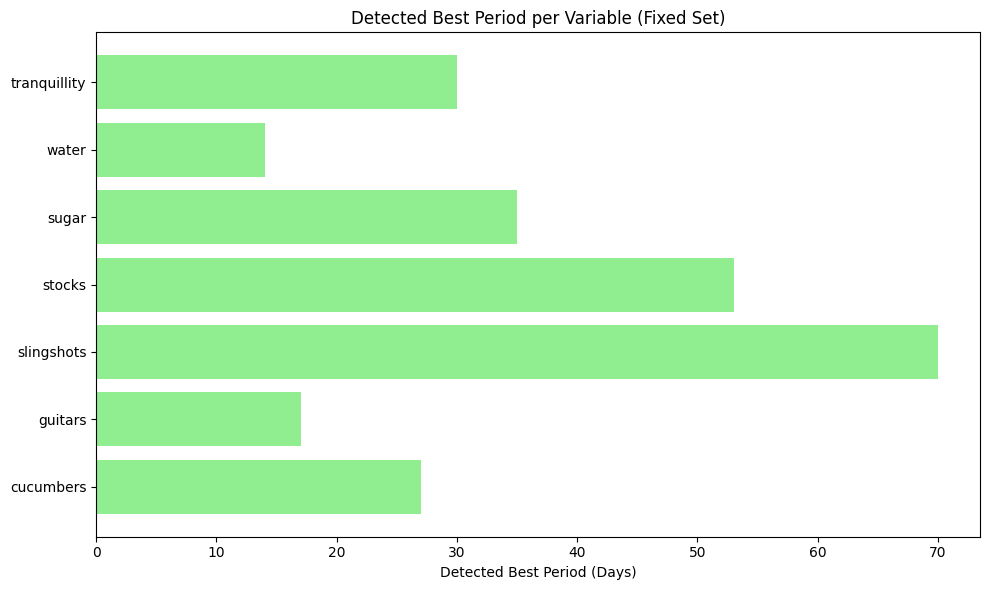

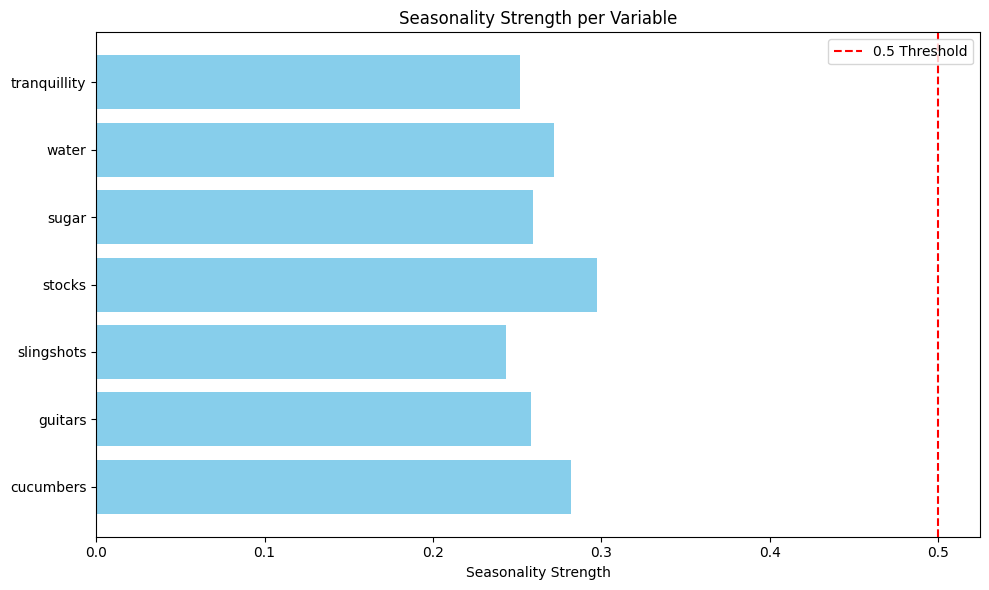

In [426]:
# Analyze seasonality on transformed data
for col in df.columns:
    if col == 'day':
        continue
    print(f"\nAnalyzing {col}...")
    series = pd.Series(detrended_df[col]).dropna()
    
    # Again get the periods for this column safely
    periods_for_col = list(periods_to_test.get(col, []))
    
    if not periods_for_col:
        print(f"No candidate periods found for {col}. Skipping.")
        continue
    
    best_period, best_strength = best_fixed_period(series, periods_for_col)
    
    if best_period is None:
        print(f"No good period found for {col}. Skipping.")
        continue
    
    best_periods[col] = best_period
    seasonality_strengths[col] = best_strength
    print(f"Best Period: {best_period} days (Strength: {best_strength:.3f})")

# --- Plot Results ---

plt.figure(figsize=(10, 6))
plt.barh(list(best_periods.keys()), list(best_periods.values()), color='lightgreen')
plt.xlabel("Detected Best Period (Days)")
plt.title("Detected Best Period per Variable (Fixed Set)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(list(seasonality_strengths.keys()), list(seasonality_strengths.values()), color='skyblue')
plt.xlabel("Seasonality Strength")
plt.title("Seasonality Strength per Variable")
plt.axvline(0.5, color='red', linestyle='--', label='0.5 Threshold')
plt.legend()
plt.tight_layout()
plt.show()
